<hr style="height: 1px;">
<i>This notebook was authored by the 8.S50x Course Team, Copyright 2022 MIT All Rights Reserved.</i>
<hr style="height: 1px;">
<br>

<h1>Lesson 22: Markov Chain Monte Carlo - Part I</h1>



<a name='section_23_0'></a>
<hr style="height: 1px;">


## <h2 style="border:1px; border-style:solid; padding: 0.25em; color: #FFFFFF; background-color: #90409C">L22.0 Overview</h2>


<h3>Navigation</h3>

<table style="width:100%">
    <tr>
        <td style="text-align: left; vertical-align: top; font-size: 10pt;"><a href="#section_23_1">L22.1 Markov Chain MC</a></td>
        <td style="text-align: left; vertical-align: top; font-size: 10pt;"><a href="#exercises_23_1">L22.1 Exercises</a></td>
    </tr>
    <tr>
        <td style="text-align: left; vertical-align: top; font-size: 10pt;"><a href="#section_23_2">L22.2 Understanding some details</a></td>
        <td style="text-align: left; vertical-align: top; font-size: 10pt;"><a href="#exercises_23_2">L22.2 Exercises</a></td>
    </tr>
    <tr>
        <td style="text-align: left; vertical-align: top; font-size: 10pt;"><a href="#section_23_3">L22.3 A more realistic Markov Chain MC</a></td>
        <td style="text-align: left; vertical-align: top; font-size: 10pt;"><a href="#exercises_23_3">L22.3 Exercises</a></td>
    </tr>
</table>

In [1]:
#>>>RUN: L22.0-runcell00

!git init
!git remote add -f origin https://github.com/mitx-8s50/nb_LEARNER/
!git config core.sparseCheckout true
!echo 'data/L23' >> .git/info/sparse-checkout
!git pull origin main


Initialized empty Git repository in /Users/josemanuelplaza/Documents/8.S50-MITx-Computational-Physics/8.S50.3x - Computational Data Science in Physics III/Unit-2-Montecarlo-Methods/Lesson-22-Markov Chain Monte Carlo-Part I/.git/
Updating origin
remote: Enumerating objects: 713, done.
remote: Counting objects: 100% (184/184), done.
remote: Compressing objects: 100% (122/122), done.
remote: Total 713 (delta 88), reused 79 (delta 62), pack-reused 529 (from 1)
Receiving objects: 100% (713/713), 37.17 MiB | 10.56 MiB/s, done.
Resolving deltas: 100% (339/339), done.
From https://github.com/mitx-8s50/nb_LEARNER
 * [new branch]      Alex       -> origin/Alex
 * [new branch]      main       -> origin/main
From https://github.com/mitx-8s50/nb_LEARNER
 * branch            main       -> FETCH_HEAD


In [2]:
#>>>RUN: L22.0-runcell01

!pip install corner
!pip install lmfit
!pip install bilby
!pip install gwpy lalsuite

In [3]:
#>>>RUN: L22.0-runcell01

import imageio
from PIL import Image

import lmfit
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import csv
import math
from scipy import optimize as opt
from scipy import stats
import matplotlib.cm as cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import corner
import warnings

import bilby
import scipy.signal as sig
from bilby.gw.source import lal_binary_black_hole
from bilby.gw.conversion import convert_to_lal_binary_black_hole_parameters

In [4]:
#>>>RUN: L22.0-runcell02
warnings.filterwarnings('ignore')

#set plot resolution
%config InlineBackend.figure_format = 'retina'

#set default figure parameters
plt.rcParams['figure.figsize'] = (9,6)

medium_size = 12
large_size = 15

plt.rc('font', size=medium_size)          # default text sizes
plt.rc('xtick', labelsize=medium_size)    # xtick labels
plt.rc('ytick', labelsize=medium_size)    # ytick labels
plt.rc('legend', fontsize=medium_size)    # legend
plt.rc('axes', titlesize=large_size)      # axes title
plt.rc('axes', labelsize=large_size)      # x and y labels
plt.rc('figure', titlesize=large_size)    # figure title

<a name='section_23_1'></a>
<hr style="height: 1px;">

## <h2 style="border:1px; border-style:solid; padding: 0.25em; color: #FFFFFF; background-color: #90409C">L22.1 Markov Chain Monte Carlo </h2>  

| [Top](#section_23_0) | [Previous Section](#section_23_0) | [Exercises](#exercises_23_1) | [Next Section](#section_23_2) |


Text(0, 0.5, 'N')

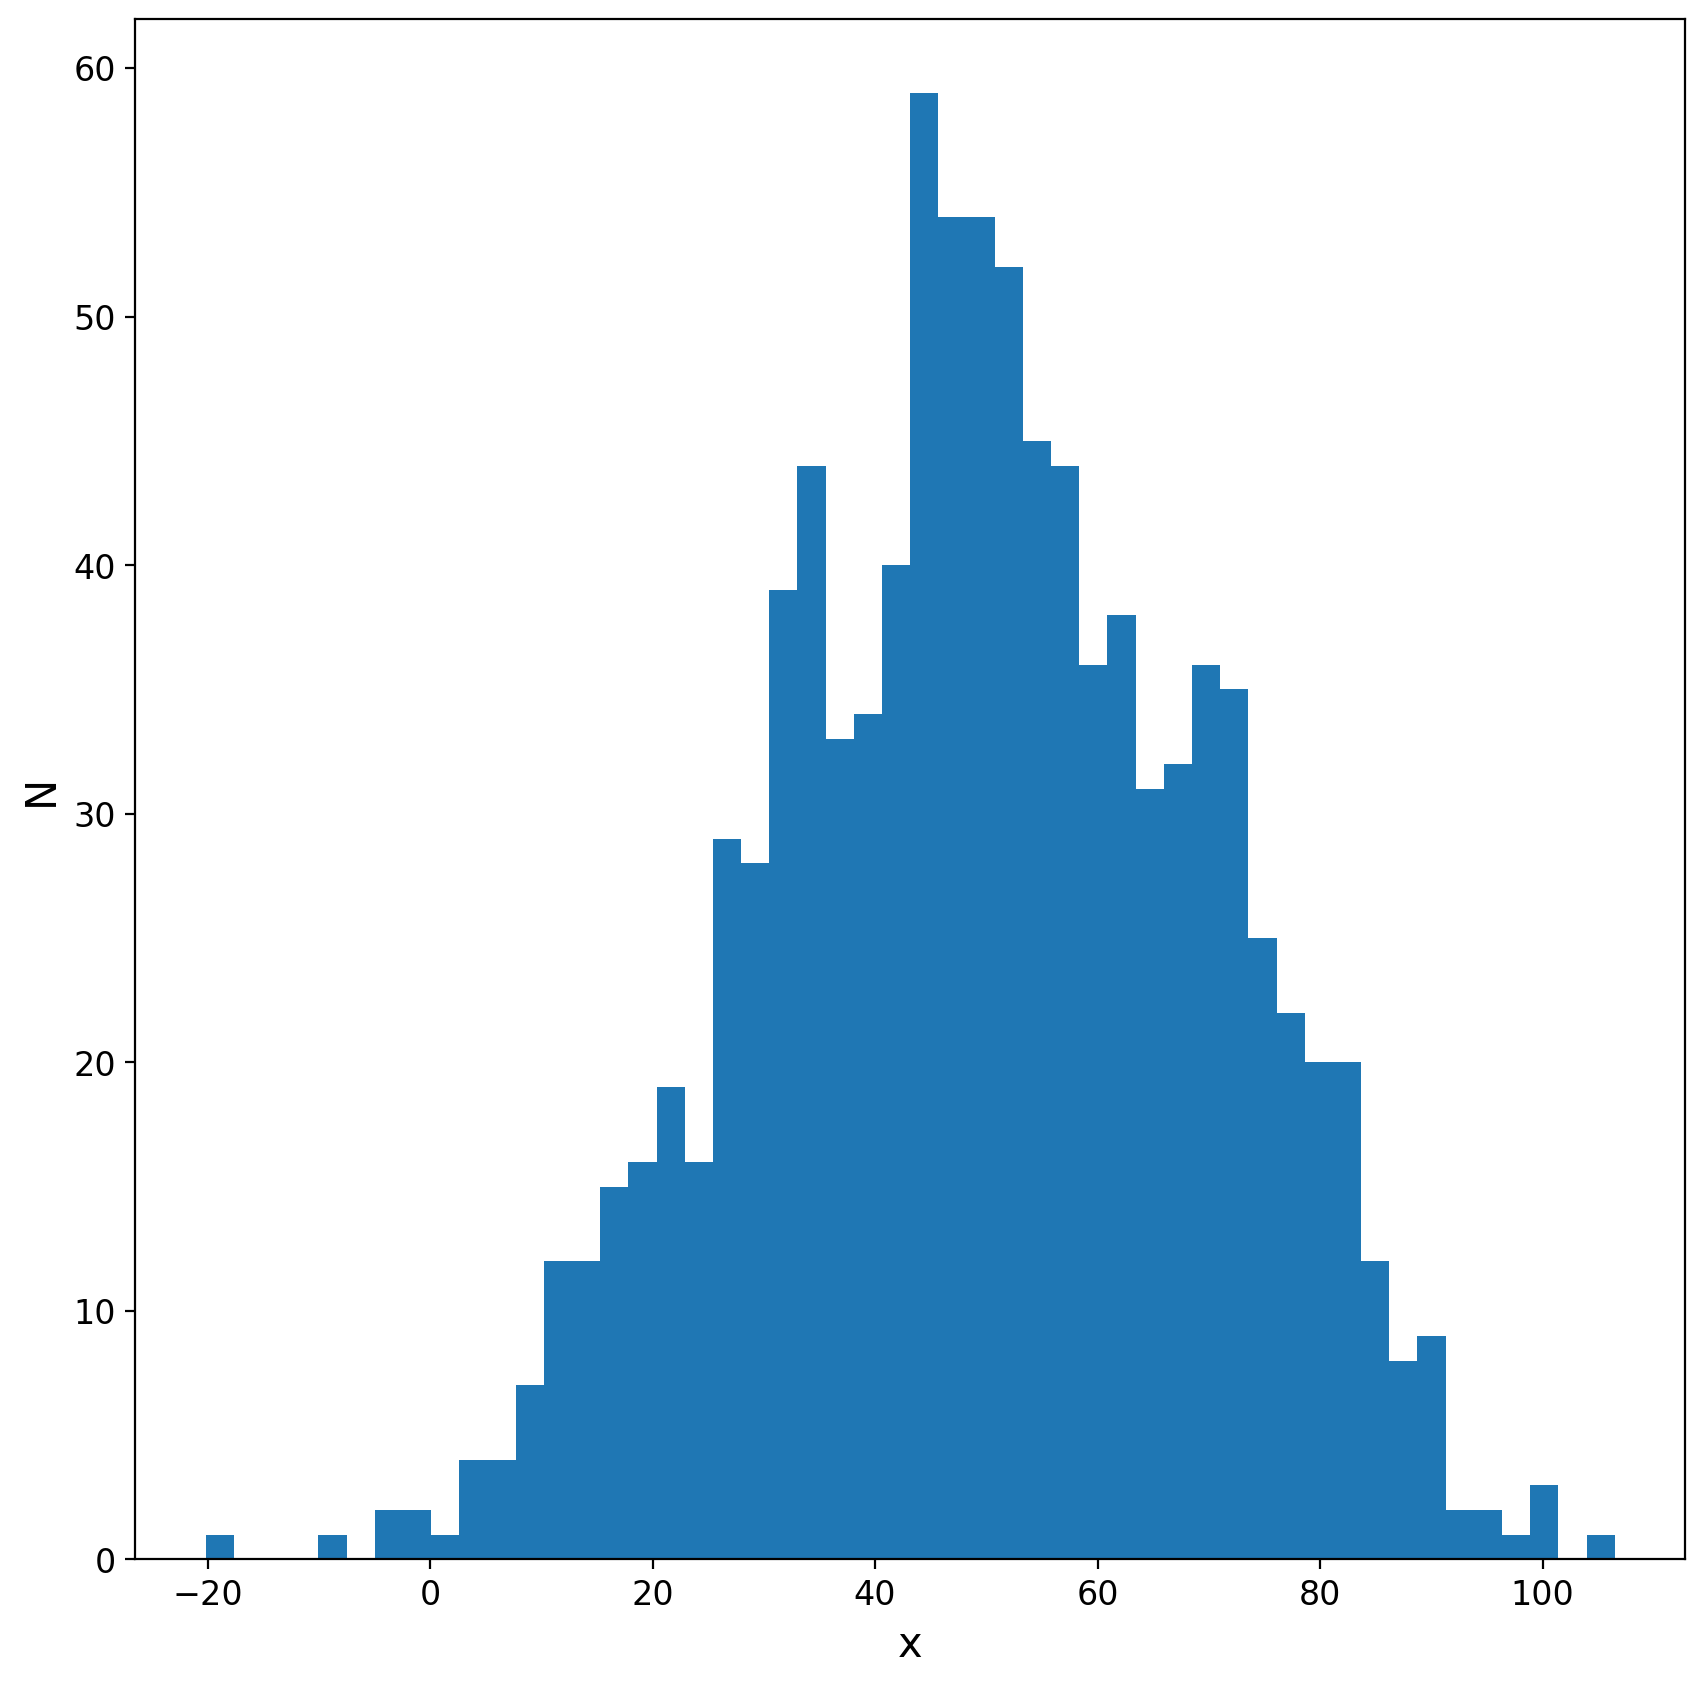

In [5]:
#>>>RUN: L22.1-runcell01

nsample=1000
values=np.random.normal(50,20,nsample)
fig = plt.figure(figsize=(10,10))
plt.hist(values,bins=50)
plt.xlabel("x")
plt.ylabel("N")


In [6]:
#>>>RUN: L22.1-runcell02

def log_like_normal(x,data):
    #x[0]=mu, x[1]=sigma (new or current)
    #data = the observation
    return np.sum(np.log(stats.norm(x[0],x[1]).pdf(data)))


In [7]:
#>>>RUN: L22.1-runcell03

def proposal(x):
    #x[0] = mu, x[1]=sigma (new or current)
    x_new = np.array([0,0])
    x_new = np.random.uniform(x-x[1]*np.ones(x.shape),x+x[1]*np.ones(x.shape))
    return x_new

#Let's run a quick test
xinit=np.array([25,10])
likeOld=log_like_normal(xinit,values)
xtry=proposal(xinit)
likeNew=log_like_normal(xtry,values)
print("Init:",xinit, "Likelihood:",likeOld)
print("Try:" ,xtry , "Likelihood:",likeNew)

Init: [25 10] Likelihood: -8269.015798170312
Try: [23.63663812  9.52971768] Likelihood: -9112.749553381977


In [8]:
#>>>RUN: L22.1-runcell04

#note, the notation below is different than what is presented in the corresponding video


#Defines whether to accept or reject the new sample
def acceptance(likeOld, likeNew):
    if likeNew>likeOld:
        return True
    else:
        accept=np.random.uniform(0,1)
        return (accept < (np.exp(likeNew-likeOld)))

def prior(like,x):
    #Adjust the likelihood by the prior
    prior=1
    if(x[1] <=0):
        prior=0
    return like+np.log(prior) #log(1)=0 so nothing gets added, log(0)=-infinity so this case always gets rejected

print("Init Prior:",prior(likeOld,xinit),"Try Prior:",prior(likeNew,xtry))
print("Accept:",acceptance(prior(likeOld,xinit),prior(likeNew,xtry)))

Init Prior: -8269.015798170312 Try Prior: -9112.749553381977
Accept: False


In [9]:
#>>>RUN: L22.1-runcell05

def metropolis_hastings(iLikelihood,iPrior,iProposal,iAcceptance,xinit,data,niterations):
    x = xinit
    accepted = []
    rejected = []
    likelihood = []
    for i in range(niterations):
        x_new   =  iProposal(x)  
        likeOld = iLikelihood(x,data)
        likeNew = iLikelihood(x_new,data) 
        if (iAcceptance(iPrior(likeOld,x),iPrior(likeNew,x_new))):            
            x = x_new
            accepted.append(x_new)
            likelihood.append(likeNew)
        else:
            rejected.append(x_new)
    accepted = np.array(accepted)
    rejected = np.array(rejected)
    likelihood = np.array(likelihood)
    return accepted, rejected, likelihood

xinit = np.array([25,10])
accepted, rejected, likelihood = metropolis_hastings(log_like_normal,prior,proposal,acceptance,xinit,values,15000)

Substituting symbol L from STIXNonUnicode
Substituting symbol L from STIXNonUnicode


[25.50659885  8.14743975]


Substituting symbol L from STIXNonUnicode


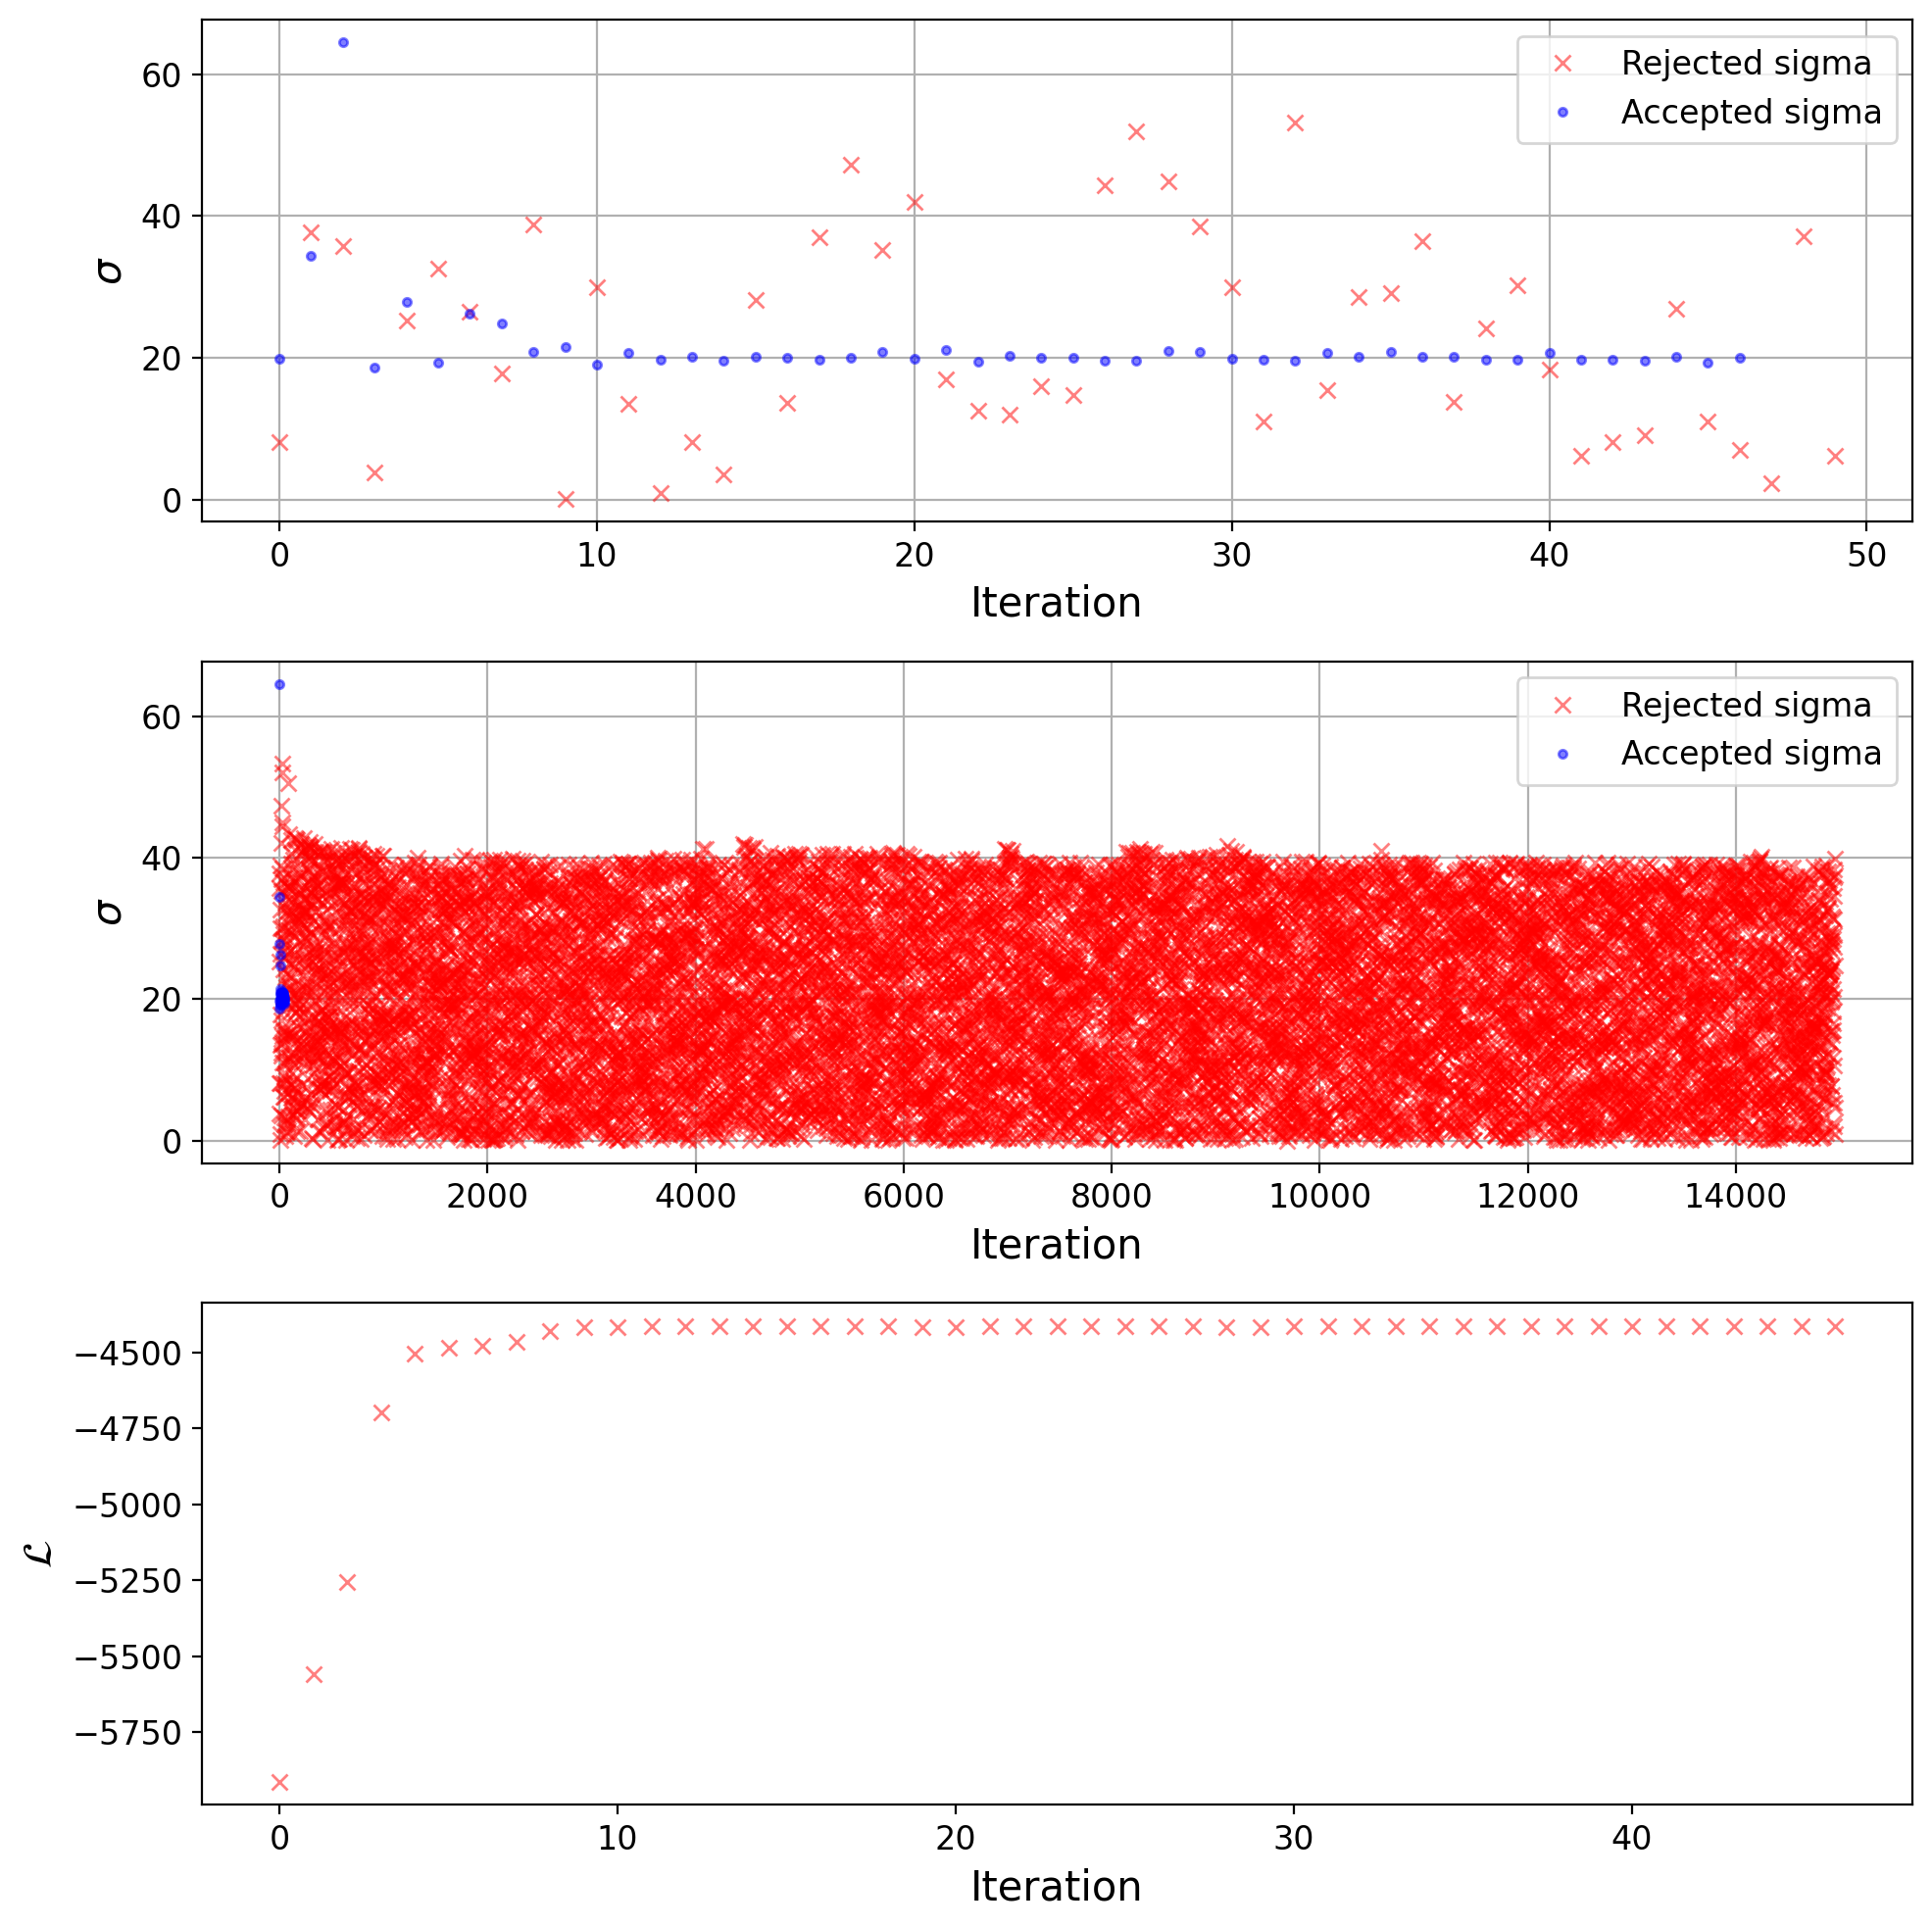

In [10]:
#>>>RUN: L22.1-runcell06

#PLOT SIGMA VALUES
fig = plt.figure(figsize=(10,10))
ax1 = fig.add_subplot(3,1,1)
print(rejected[0:50][0])

ax1.plot(rejected[0:50,1], 'rx', label='Rejected sigma',alpha=0.5)
ax1.plot(accepted[0:50,1], 'b.', label='Accepted sigma',alpha=0.5)
ax1.set_xlabel("Iteration")
ax1.set_ylabel("$\sigma$")
ax1.grid()
ax1.legend()


ax2 = fig.add_subplot(3,1,2)
#to_show=-accepted.shape[0]
ax2.plot( rejected[:,1], 'rx', label='Rejected sigma',alpha=0.5)
ax2.plot( accepted[:,1], 'b.', label='Accepted sigma',alpha=0.5)
ax2.set_xlabel("Iteration")
ax2.set_ylabel("$\sigma$")
ax2.grid()
ax2.legend()

ax3 = fig.add_subplot(3,1,3)
ax3.plot( likelihood, 'rx', label='Likelihood',alpha=0.5)
ax3.set_xlabel("Iteration")
ax3.set_ylabel("$\mathcal{L}$")

fig.tight_layout()
accepted.shape
plt.show()

Substituting symbol L from STIXNonUnicode
Substituting symbol L from STIXNonUnicode


[25.50659885  8.14743975]


Substituting symbol L from STIXNonUnicode


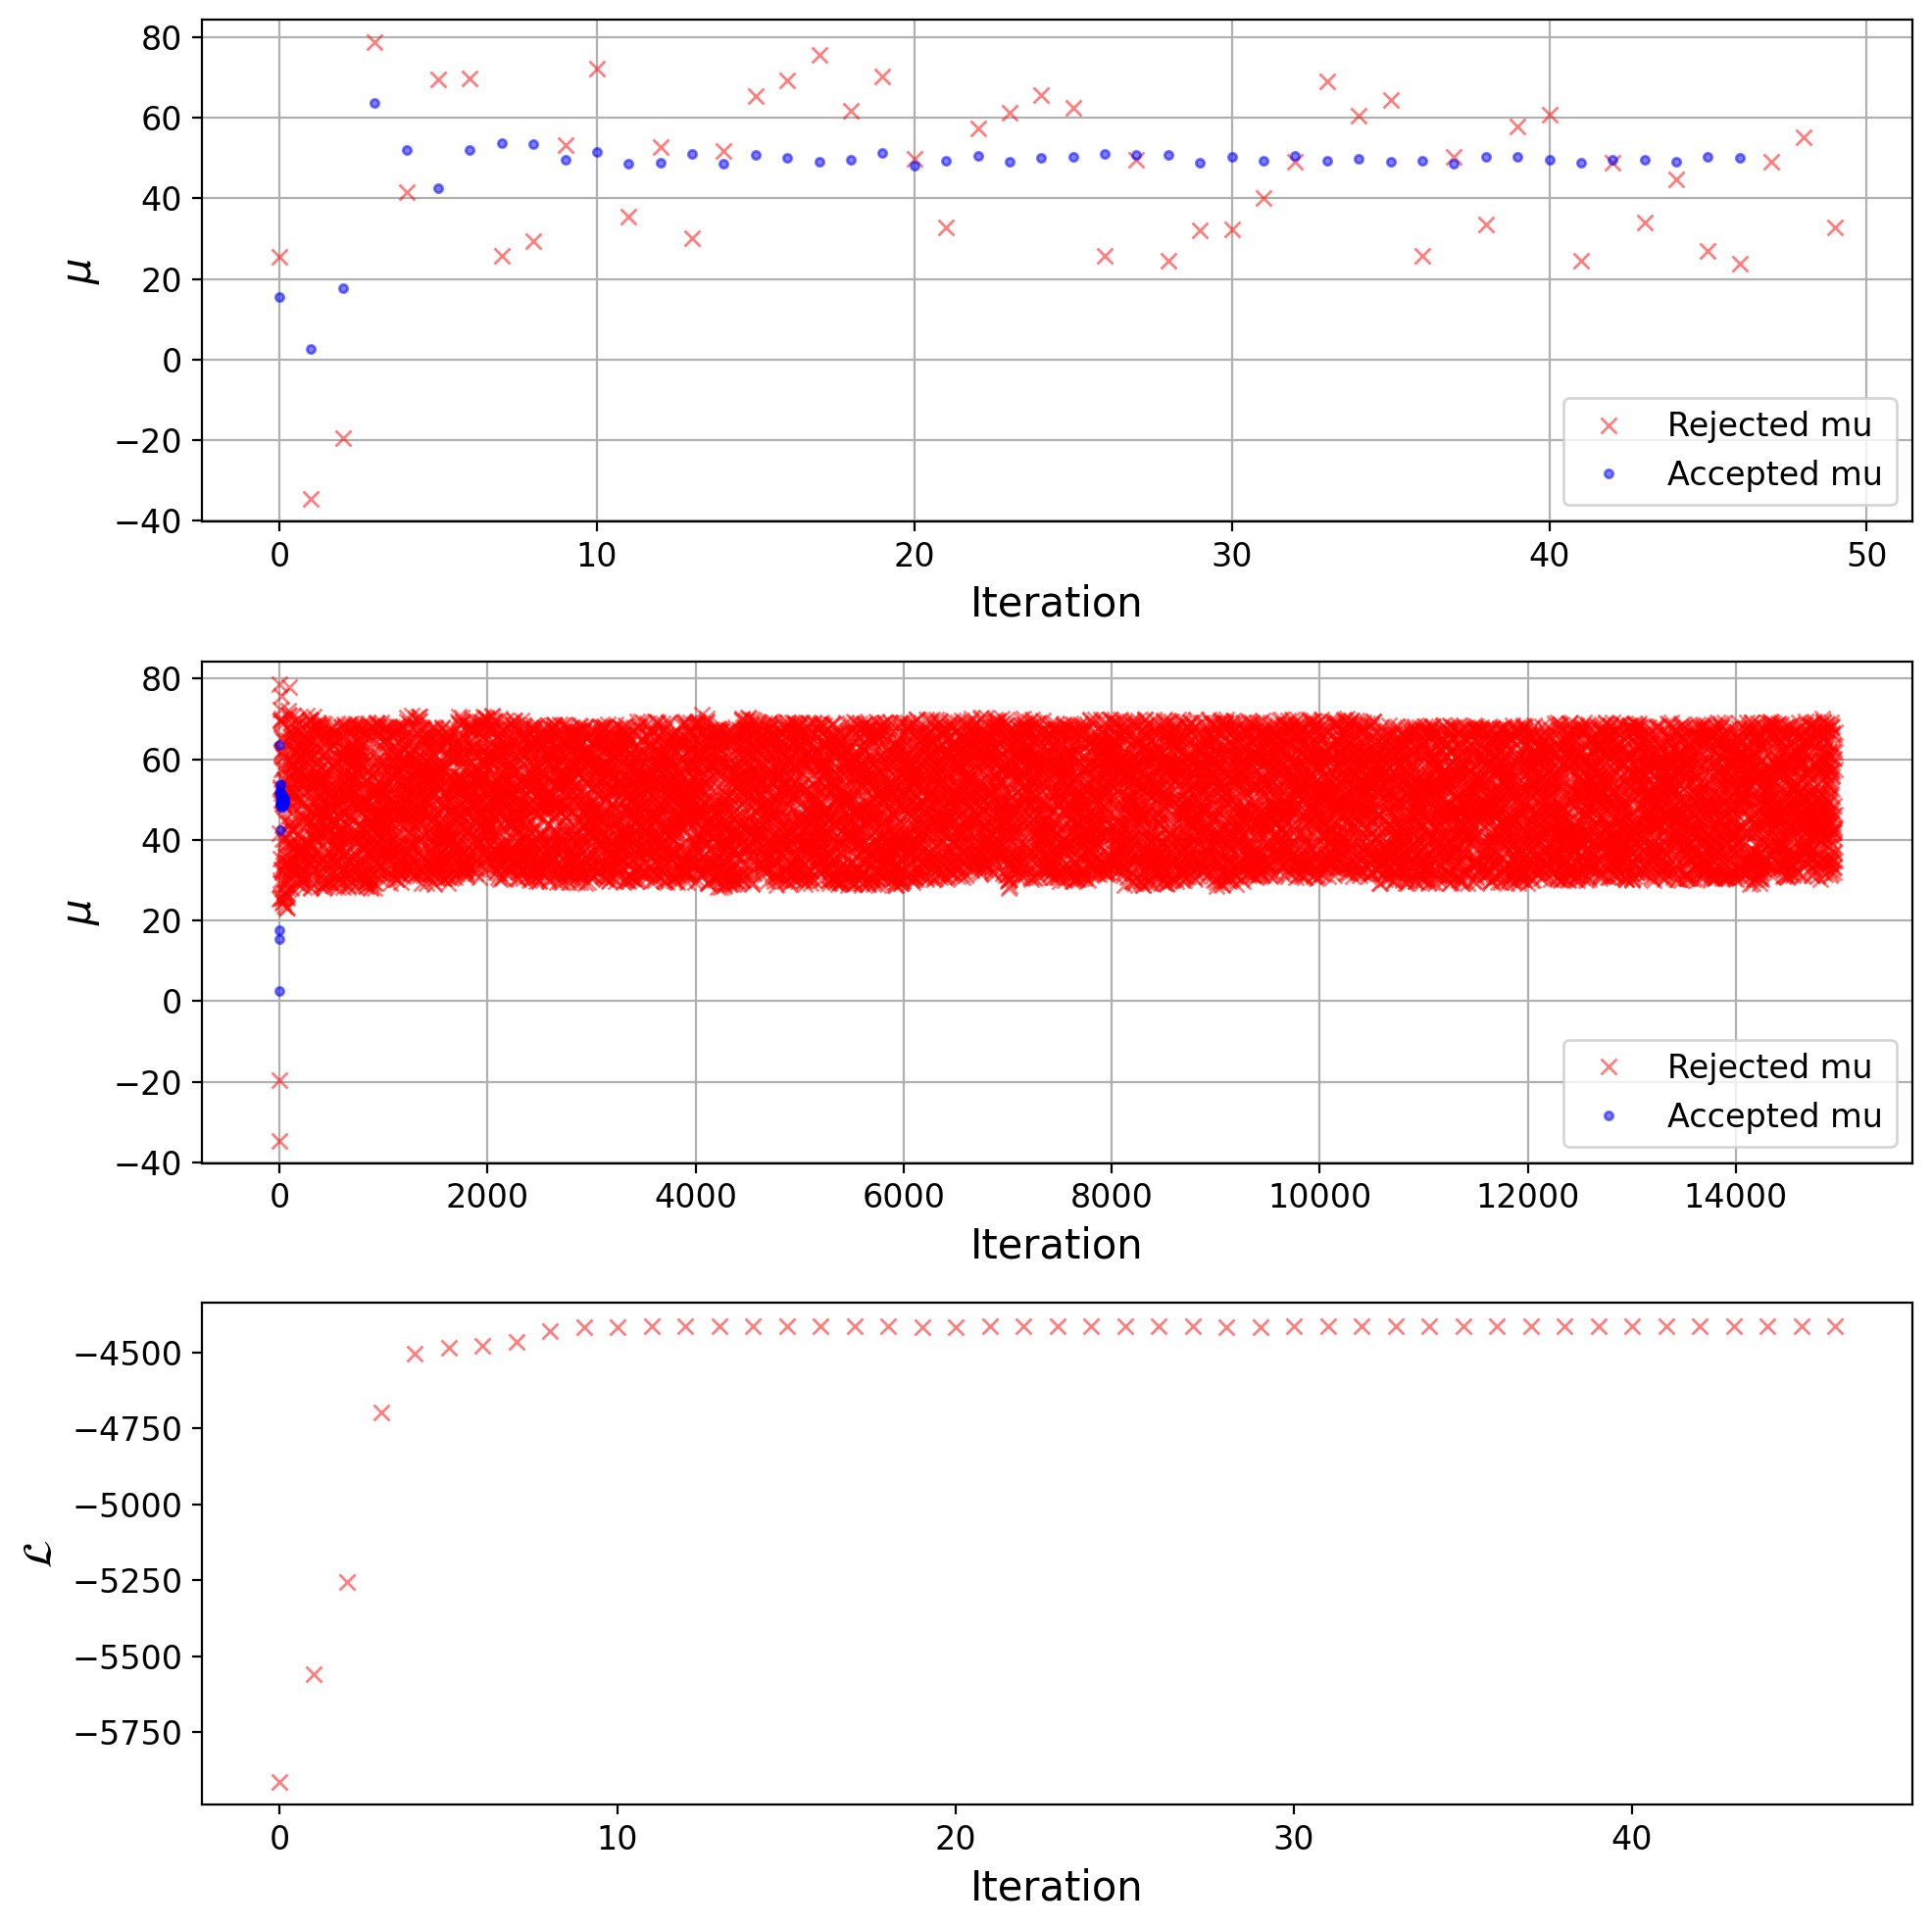

In [11]:
#>>>RUN: L22.1-runcell07

#PLOT MU VALUES
fig = plt.figure(figsize=(10,10))
ax1 = fig.add_subplot(3,1,1)
print(rejected[0:50][0])

ax1.plot(rejected[0:50,0], 'rx', label='Rejected mu',alpha=0.5)
ax1.plot(accepted[0:50,0], 'b.', label='Accepted mu',alpha=0.5)
ax1.set_xlabel("Iteration")
ax1.set_ylabel("$\mu$")
ax1.grid()
ax1.legend()


ax2 = fig.add_subplot(3,1,2)
ax2.plot( rejected[:,0], 'rx', label='Rejected mu',alpha=0.5)
ax2.plot( accepted[:,0], 'b.', label='Accepted mu',alpha=0.5)
ax2.set_xlabel("Iteration")
ax2.set_ylabel("$\mu$")
ax2.grid()
ax2.legend()

ax3 = fig.add_subplot(3,1,3)
ax3.plot( likelihood, 'rx', label='Likelihood',alpha=0.5)
ax3.set_xlabel("Iteration")
ax3.set_ylabel("$\mathcal{L}$")

fig.tight_layout()
accepted.shape
plt.show()

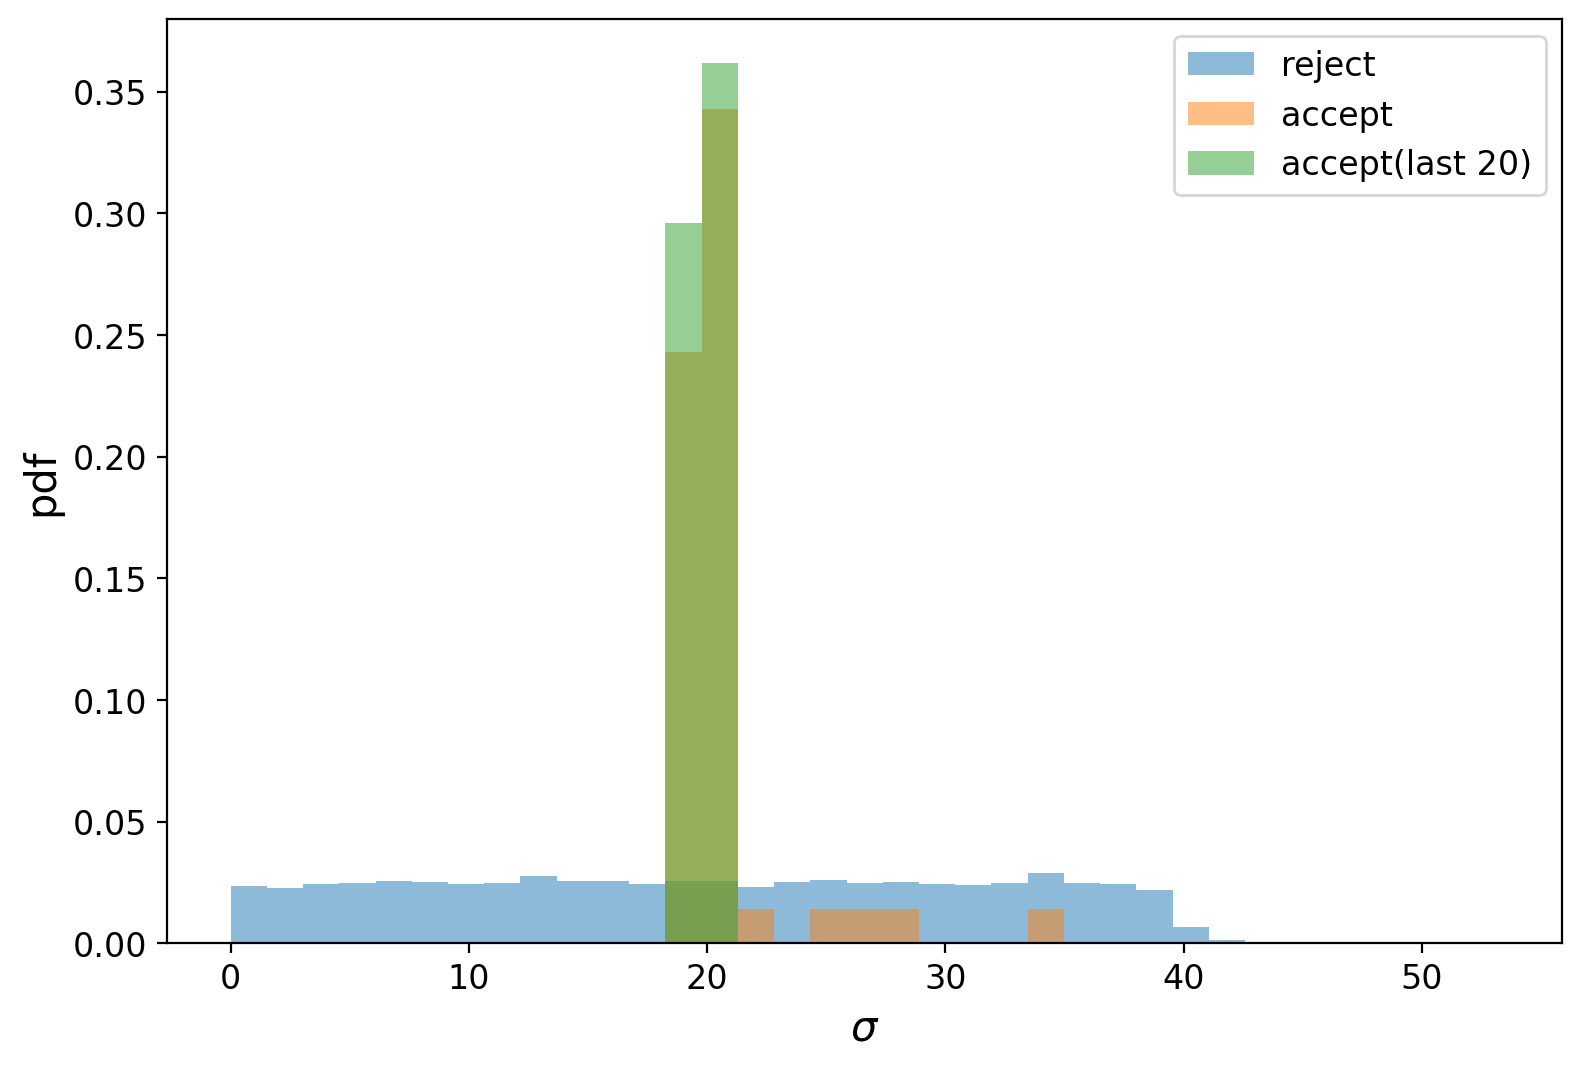

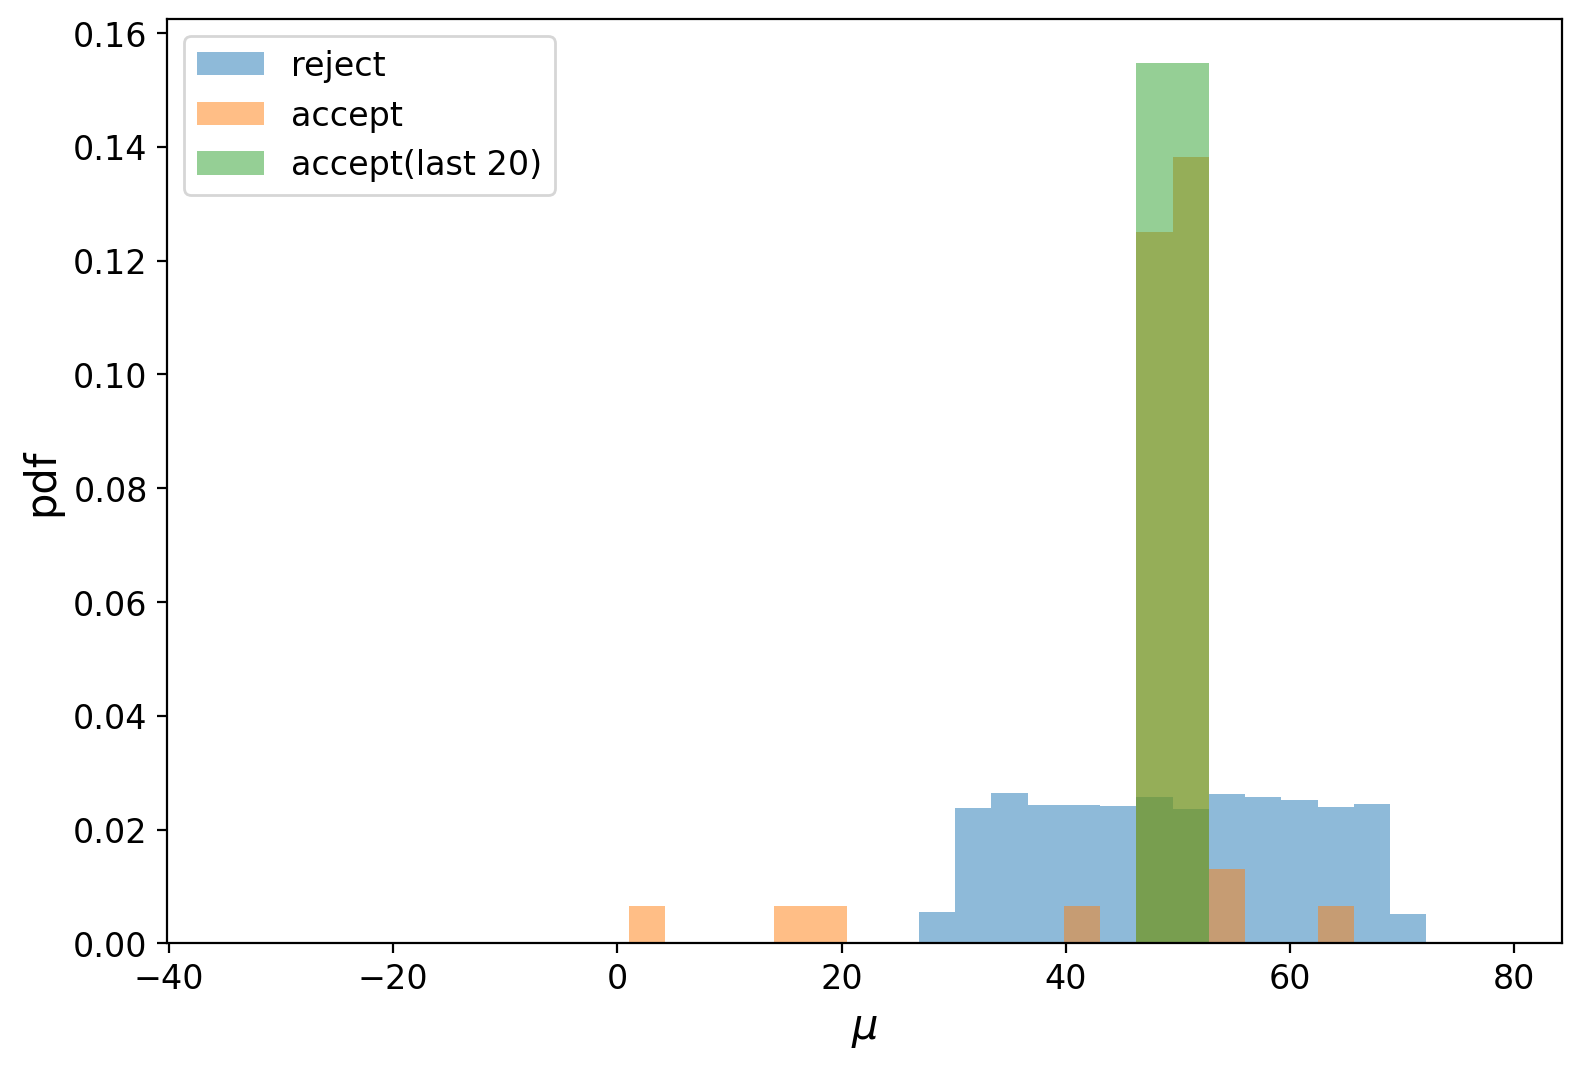

Average and stdev of all accepted mu: 47.72166433931534 +/- 9.833961312477316
Average and stdev of all accepted sigma: 21.670514969100378 +/- 6.835976981363652
Average and stdev of last 20 accepted mu: 49.67401714561732 +/- 0.5999582230729762
Average and stdev of last 20 accepted sigma: 20.037172748548223 +/- 0.34872061864304693


In [12]:
#>>>RUN: L22.1-runcell07

_,bins,_ = plt.hist(rejected[:,1],bins=35,density=True,label='reject',alpha=0.5)
_,bins,_ = plt.hist(accepted[:,1],bins=bins,density=True,label='accept',alpha=0.5)
_,bins,_ = plt.hist(accepted[-20:,1],bins=bins,density=True,label='accept(last 20)',alpha=0.5)
plt.xlabel("$\sigma$")
plt.ylabel("pdf")
plt.legend()
plt.show()

_,bins,_ = plt.hist(rejected[:,0],bins=35,density=True,label='reject',alpha=0.5)
_,bins,_ = plt.hist(accepted[:,0],bins=bins,density=True,label='accept',alpha=0.5)
_,bins,_ = plt.hist(accepted[-20:,0],bins=bins,density=True,label='accept(last 20)',alpha=0.5)
plt.xlabel("$\mu$")
plt.ylabel("pdf")
plt.legend()
plt.show()

print("Average and stdev of all accepted mu:",accepted[:,0].mean(),"+/-",accepted[:,0].std())
print("Average and stdev of all accepted sigma:",accepted[:,1].mean(),"+/-",accepted[:,1].std())

print("Average and stdev of last 20 accepted mu:",accepted[-20:,0].mean(),"+/-",accepted[-10:,0].std())
print("Average and stdev of last 20 accepted sigma:",accepted[-20:,1].mean(),"+/-",accepted[-10:,1].std())


Analytic results for mean and standard deviation of the data:
Mu: 49.72617849141577 +/- 0.6309631776934106
Sigma: 19.952807612087238 +/- 0.44615834162602314

Fitted results for mean ("center") and standard deviation ("sigma") of the data:
[[Model]]
    Model(gaussian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 62
    # data points      = 35
    # variables        = 3
    chi-square         = 32.6188471
    reduced chi-square = 1.01933897
    Akaike info crit   = 3.53397669
    Bayesian info crit = 8.20002088
    R-squared          = 0.94253693
[[Variables]]
    amplitude:  3515.82308 +/- 116.132316 (3.30%) (init = 1)
    center:     49.5501380 +/- 0.68614807 (1.38%) (init = 25)
    sigma:      19.9000183 +/- 0.51347513 (2.58%) (init = 10)
    fwhm:       46.8609610 +/- 1.20914149 (2.58%) == '2.3548200*sigma'
    height:     70.4828773 +/- 2.85591786 (4.05%) == '0.3989423*amplitude/max(1e-15, sigma)'


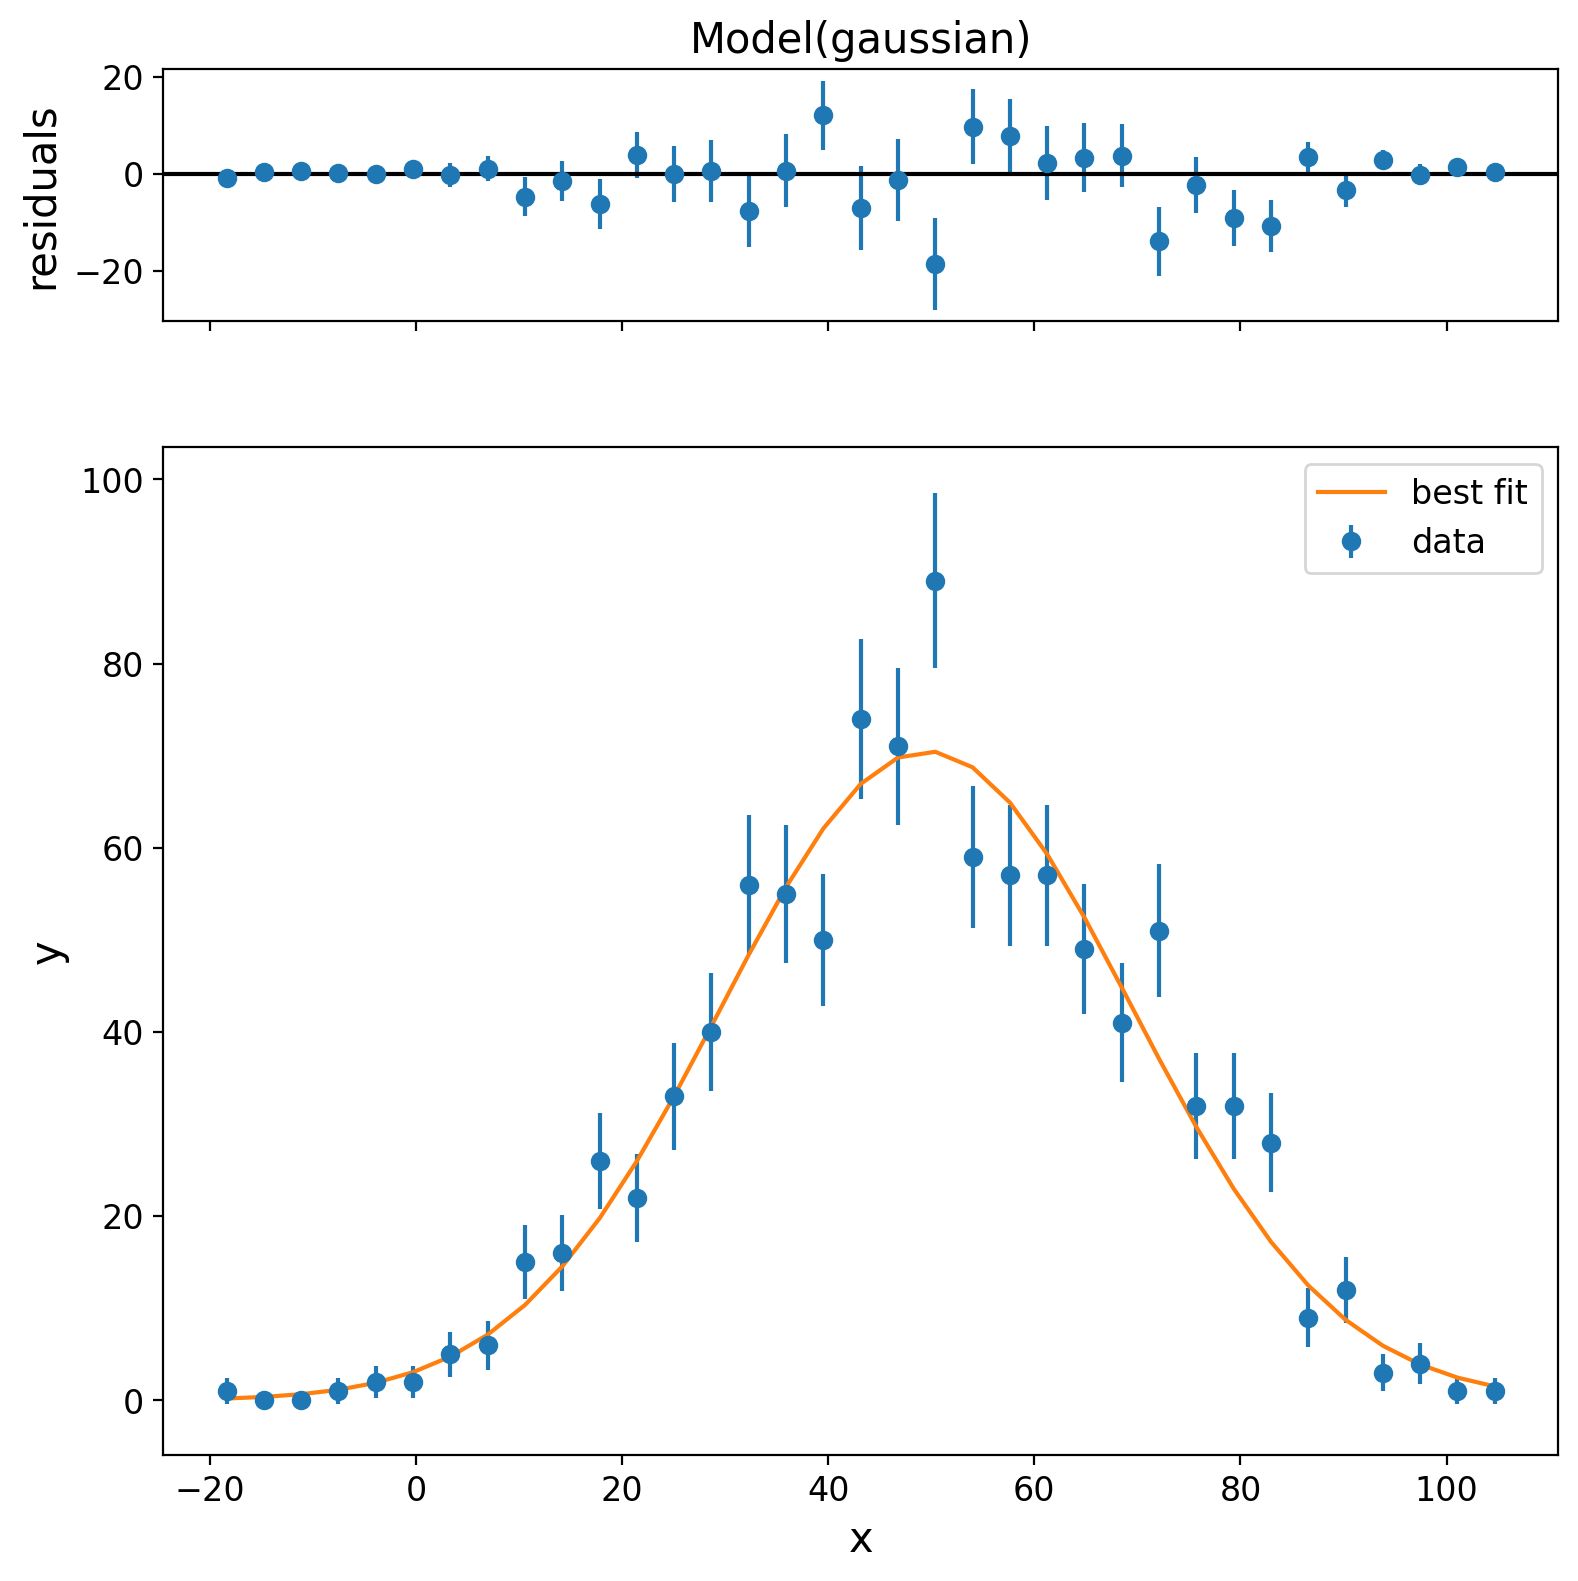

In [13]:
#>>>RUN: L22.1-runcell09

##Analytic
print("Analytic results for mean and standard deviation of the data:")
print("Mu:",values.mean(),"+/-",values.std()/np.sqrt(len(values)))
print("Sigma:",values.std(),"+/-",values.std()/np.sqrt(2.*len(values)))
print()

y,bin_edges=np.histogram(values,bins=35)
bin_centers = 0.5*(bin_edges[1:] + bin_edges[:-1])
#lmfit
from lmfit.models import GaussianModel
model = GaussianModel()
params = model.make_params(center=25, amplitude=1, sigma=10)
result = model.fit(y, params, x=bin_centers,weights=1./np.sqrt(y+1))
result.plot()
print("Fitted results for mean (\"center\") and standard deviation (\"sigma\") of the data:")
print(result.fit_report())

In [14]:
#>>>RUN: L22.1-runcell10

def proposal(x,n=1000):
    #x[0] = mu, x[1]=sigma (new or current)
    x_new     = x.copy()
    x_new[0]  = x[0] + np.random.randn()*x[1]/np.sqrt(n)
    x_new[1]  = x[1] + np.random.randn()*x[1]/np.sqrt(2*n)
    return x_new

xinit = np.array([25.,10.])
accepted, rejected,likelihood = metropolis_hastings(log_like_normal,prior,proposal,acceptance,xinit,values,15000)

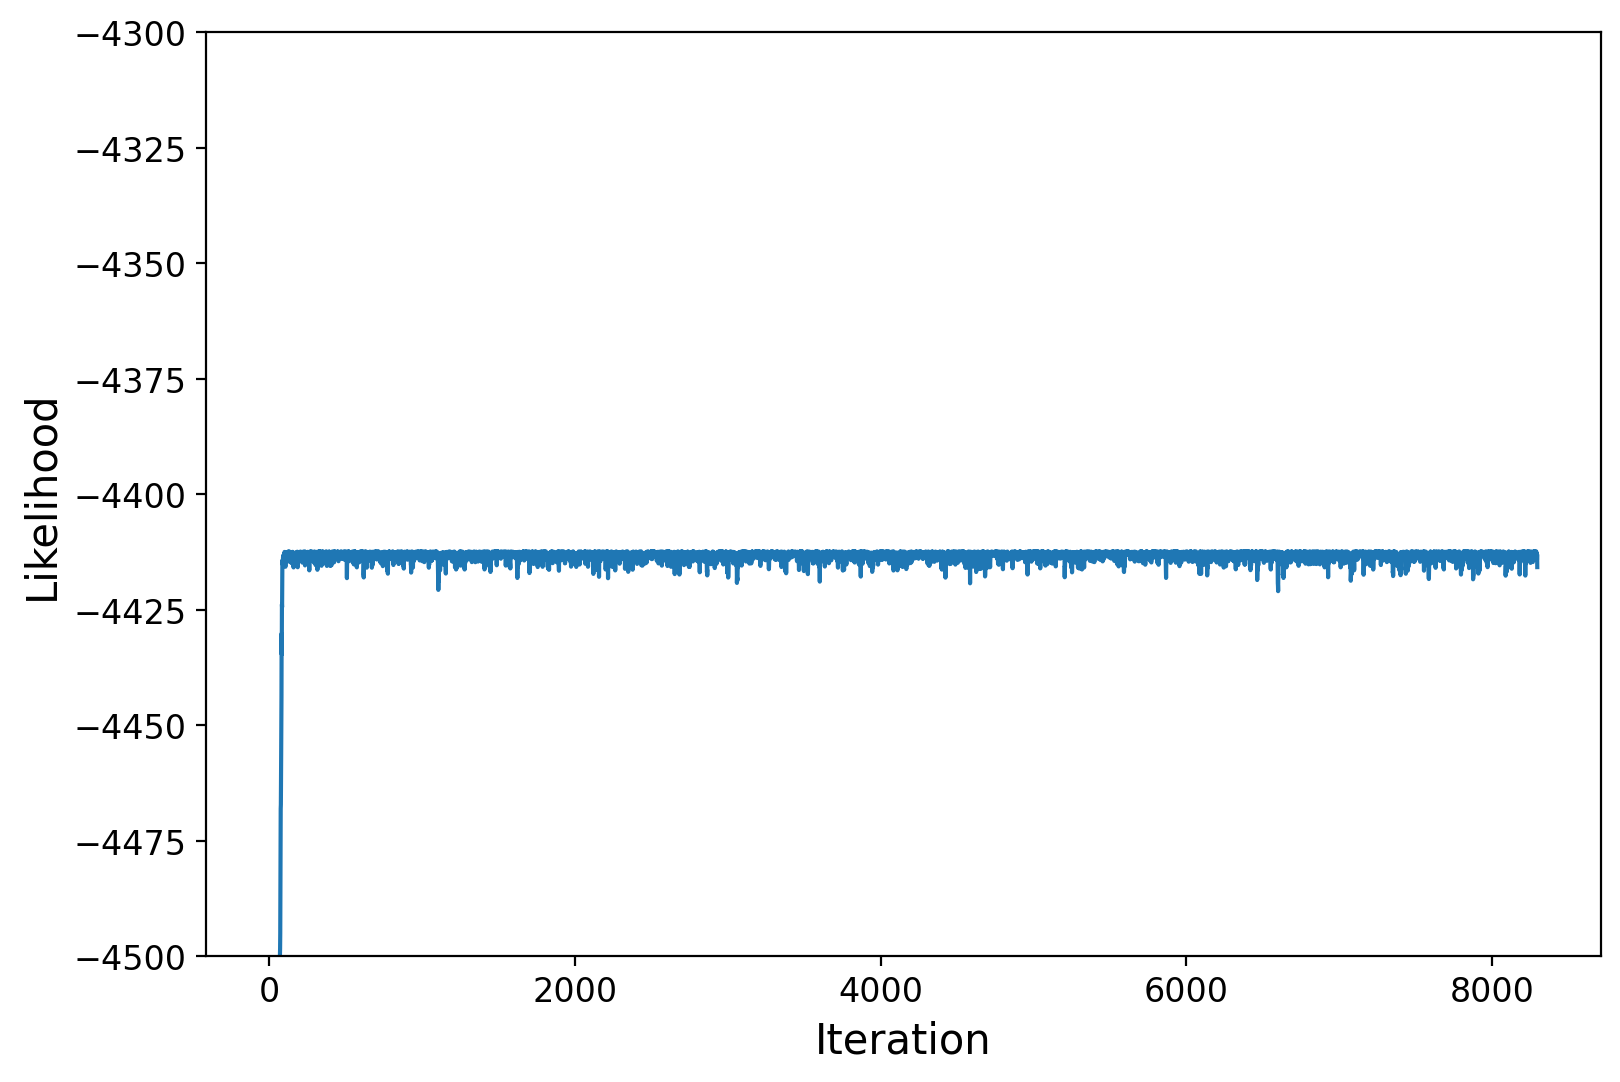

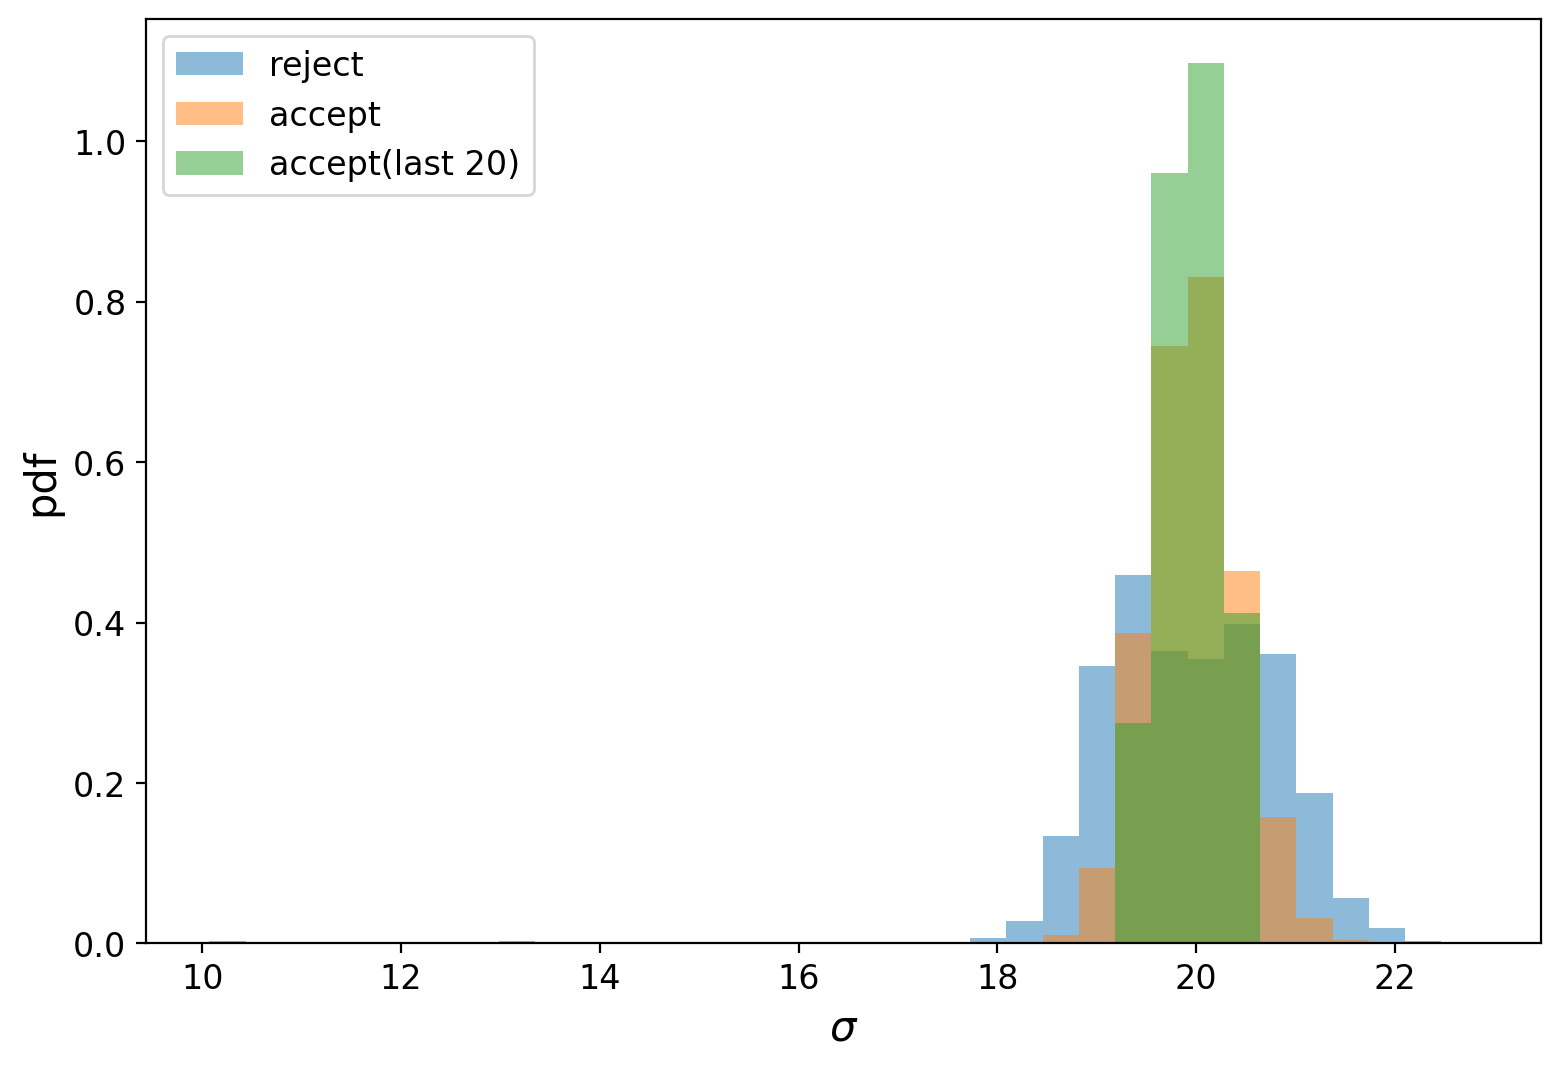

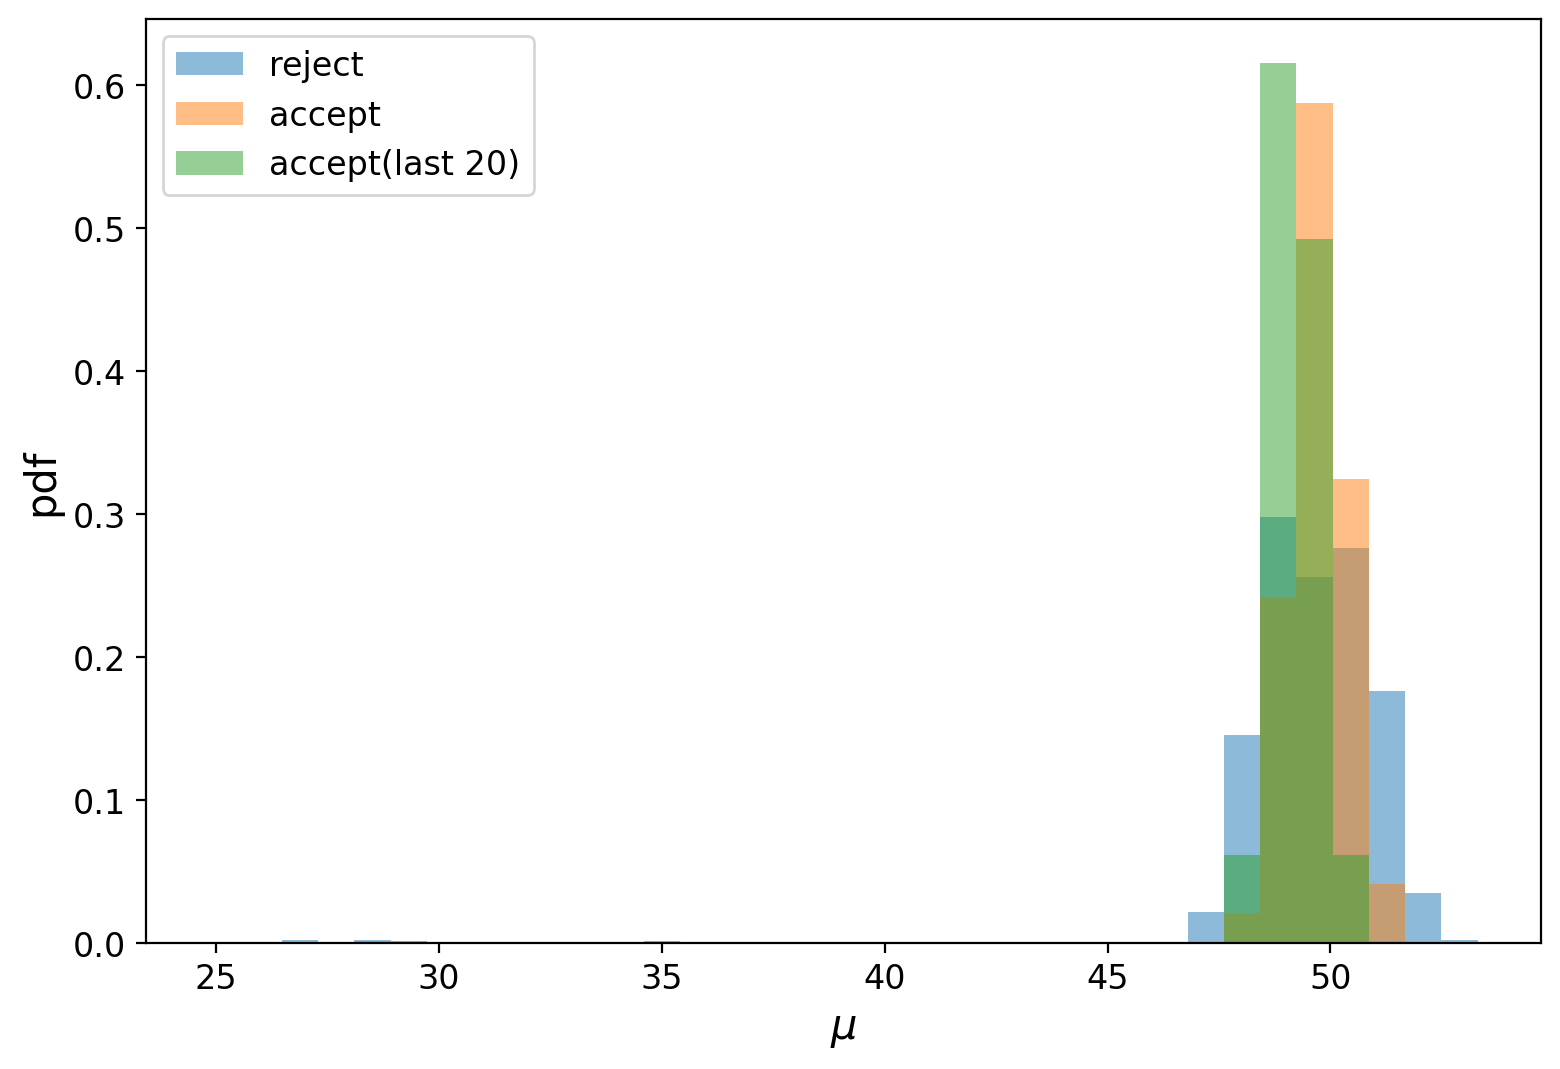

Average and stdev of all accepted mu: 49.55103086260391 +/- 1.949061389121128
Average and stdev of all accepted sigma: 19.93436639916778 +/- 0.6785268116181434
Average and stdev of last 1000 accepted mu: 49.80652076425201 +/- 0.6441724055031539
Average and stdev of last 1000 accepted sigma: 19.968796613126855 +/- 0.464769478257359


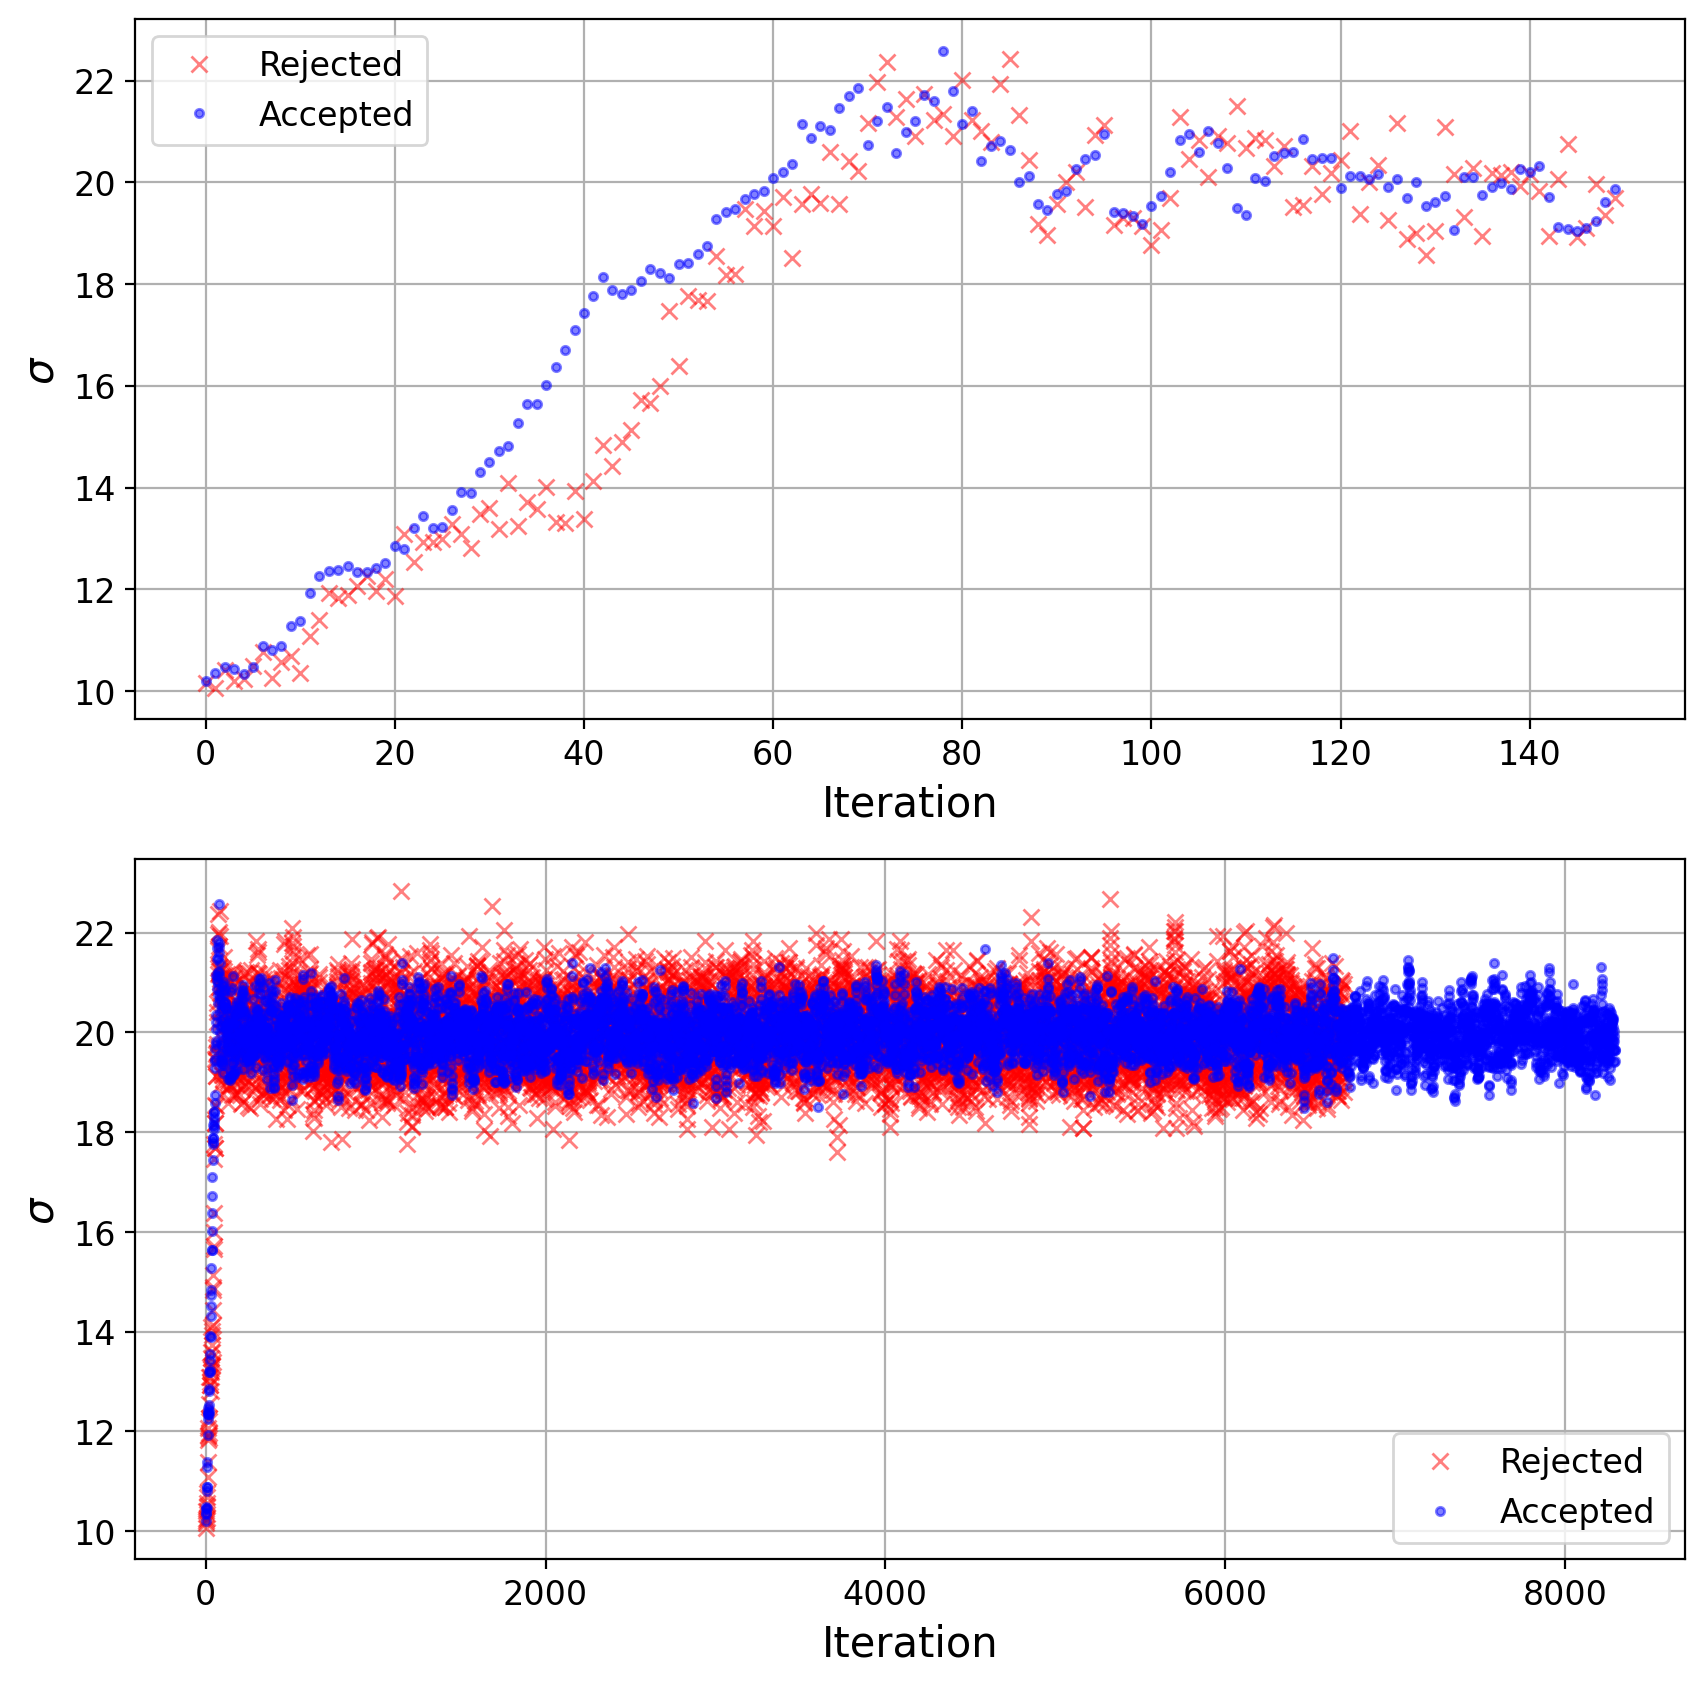

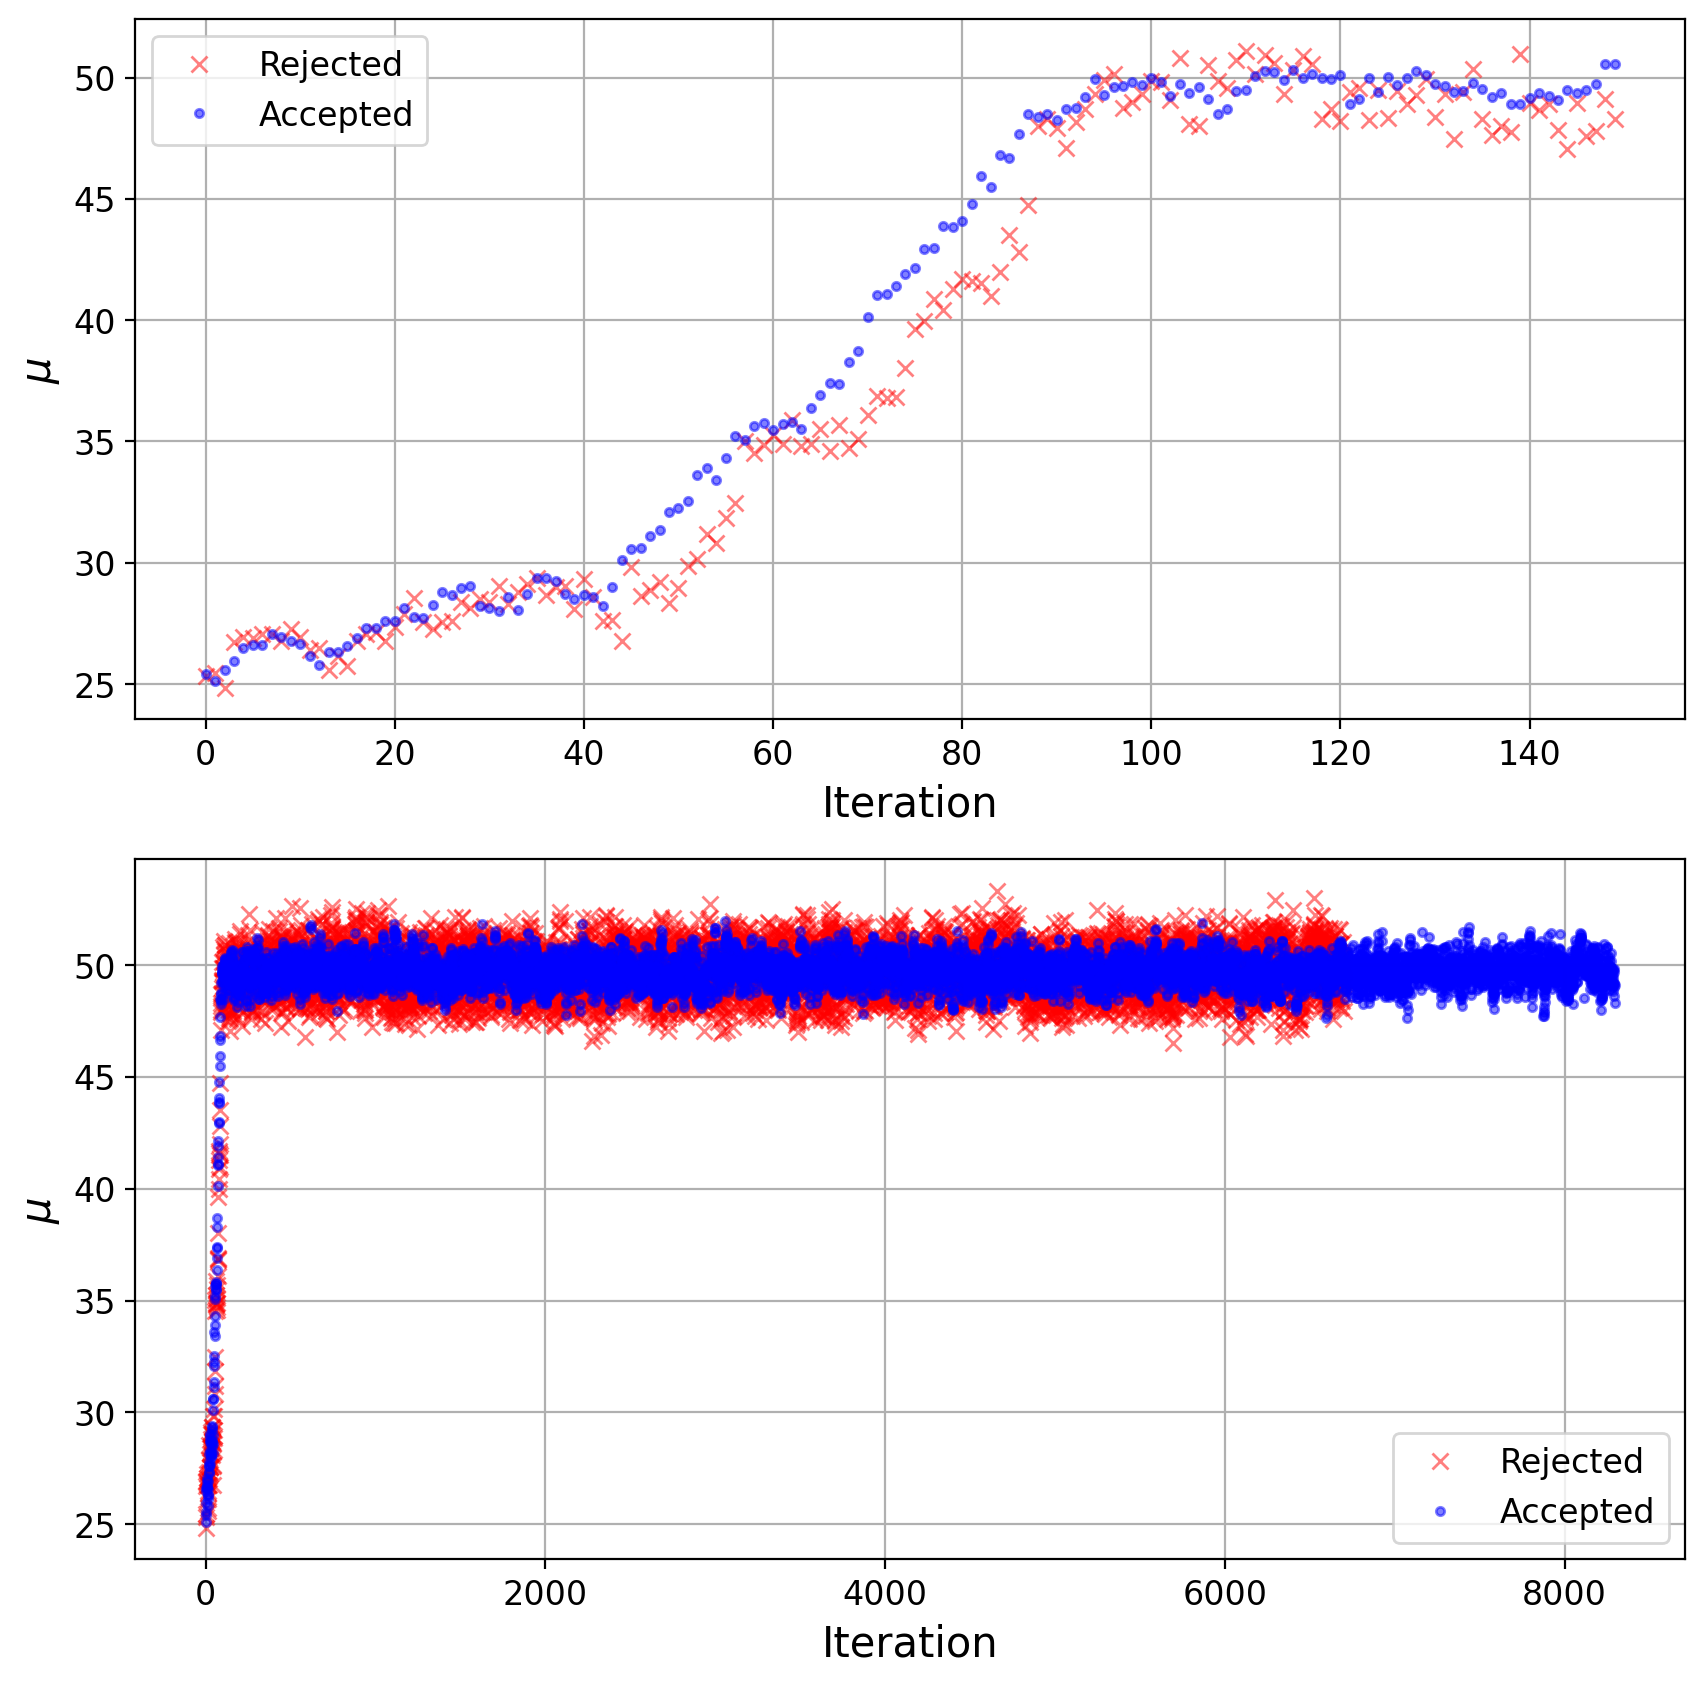

In [15]:
#>>>RUN: L22.1-runcell11

plt.plot(likelihood)
plt.xlabel("Iteration")
plt.ylabel("Likelihood")
plt.ylim(-4500,-4300)
plt.show()

_,bins,_ = plt.hist(rejected[:,1],bins=35,density=True,label='reject',alpha=0.5)
_,bins,_ = plt.hist(accepted[:,1],bins=bins,density=True,label='accept',alpha=0.5)
_,bins,_ = plt.hist(accepted[-20:,1],bins=bins,density=True,label='accept(last 20)',alpha=0.5)
plt.xlabel("$\sigma$")
plt.ylabel("pdf")
plt.legend()
plt.show()

_,bins,_ = plt.hist(rejected[:,0],bins=35,density=True,label='reject',alpha=0.5)
_,bins,_ = plt.hist(accepted[:,0],bins=bins,density=True,label='accept',alpha=0.5)
_,bins,_ = plt.hist(accepted[-20:,0],bins=bins,density=True,label='accept(last 20)',alpha=0.5)
plt.xlabel("$\mu$")
plt.ylabel("pdf")
plt.legend()
plt.show()

print("Average and stdev of all accepted mu:",accepted[:,0].mean(),"+/-",accepted[:,0].std())
print("Average and stdev of all accepted sigma:",accepted[:,1].mean(),"+/-",accepted[:,1].std())

print("Average and stdev of last 1000 accepted mu:",accepted[-1000:,0].mean(),"+/-",accepted[-1000:,0].std())
print("Average and stdev of last 1000 accepted sigma:",accepted[-1000:,1].mean(),"+/-",accepted[-1000:,1].std())


fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(2,1,1)
ax.plot(rejected[0:150,1], 'rx', label='Rejected',alpha=0.5)
ax.plot(accepted[0:150,1], 'b.', label='Accepted',alpha=0.5)
ax.set_xlabel("Iteration")
ax.set_ylabel("$\sigma$")
ax.grid()
ax.legend()


ax2 = fig.add_subplot(2,1,2)
#to_show=-accepted.shape[0]
ax2.plot( rejected[:,1], 'rx', label='Rejected',alpha=0.5)
ax2.plot( accepted[:,1], 'b.', label='Accepted',alpha=0.5)
ax2.set_xlabel("Iteration")
ax2.set_ylabel("$\sigma$")
ax2.grid()
ax2.legend()



fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(2,1,1)
ax.plot(rejected[0:150,0], 'rx', label='Rejected',alpha=0.5)
ax.plot(accepted[0:150,0], 'b.', label='Accepted',alpha=0.5)
ax.set_xlabel("Iteration")
ax.set_ylabel("$\mu$")
ax.grid()
ax.legend()


ax2 = fig.add_subplot(2,1,2)
#to_show=-accepted.shape[0]
ax2.plot( rejected[:,0], 'rx', label='Rejected',alpha=0.5)
ax2.plot( accepted[:,0], 'b.', label='Accepted',alpha=0.5)
ax2.set_xlabel("Iteration")
ax2.set_ylabel("$\mu$")
ax2.grid()
ax2.legend()



<a name='exercises_23_1'></a>     

| [Top](#section_23_0) | [Restart Section](#section_23_1) | [Next Section](#section_23_2) |


### <span style="border:3px; border-style:solid; padding: 0.15em; border-color: #90409C; color: #90409C;">Ex-22.1.1</span>

What happens when your proposal function gets too narrow or too wide? Edit the function `proposal_1` in the starting code shown below to try the fit with a range for finding $\vec{\theta^{\prime}}$ (called `x_new` in the code) that is a factor of 10 smaller than that used in code cell `L22.1-runcell09`, and edit `proposal_2` to try with a range 10X larger. Let's focus specifically on the uncertainties in the final values of the parameters as calculated using the standard deviation of the accepted parameter sets near the end of the iterations. What changes do you observe? You could also plot the distributions of accepted and rejected points vs. iteration, to gain further insight (as done above).

Try several runs to check whether or not you see a clear trend.

A) The uncertainties that are computed do not change at all.\
B) The uncertainties change from run to run, but do not seem to have a consistent dependence on the proposal that is used.\
C) The uncertainties depend on the proposal that is used, and seem to be positively correlated, meaning that the computed uncertainty increases when a wider proposal function is used.\
D) The uncertainties depend on the proposal that is used, and seem to be negatively correlated (anticorrelated), meaning that the computed uncertainty decreases when a wider proposal function is used.


1/10 original uncertainty
Length of last 1000 accepted: 1000
Average and stdev of last 1000 accepted mu: 74.84663836560979 +/- 6.742350598518487
Average and stdev of last 1000 accepted sigma: 29.012993367906507 +/- 4.529430218220402

10X original uncertainty
Length of last 1000 accepted: 30
Average and stdev of last 1000 accepted mu: 45.43588739633789 +/- 10.31458151959788
(Average and stdev of last 1000 accepted sigma: 18.874765063167725 +/- 3.6374419302456102



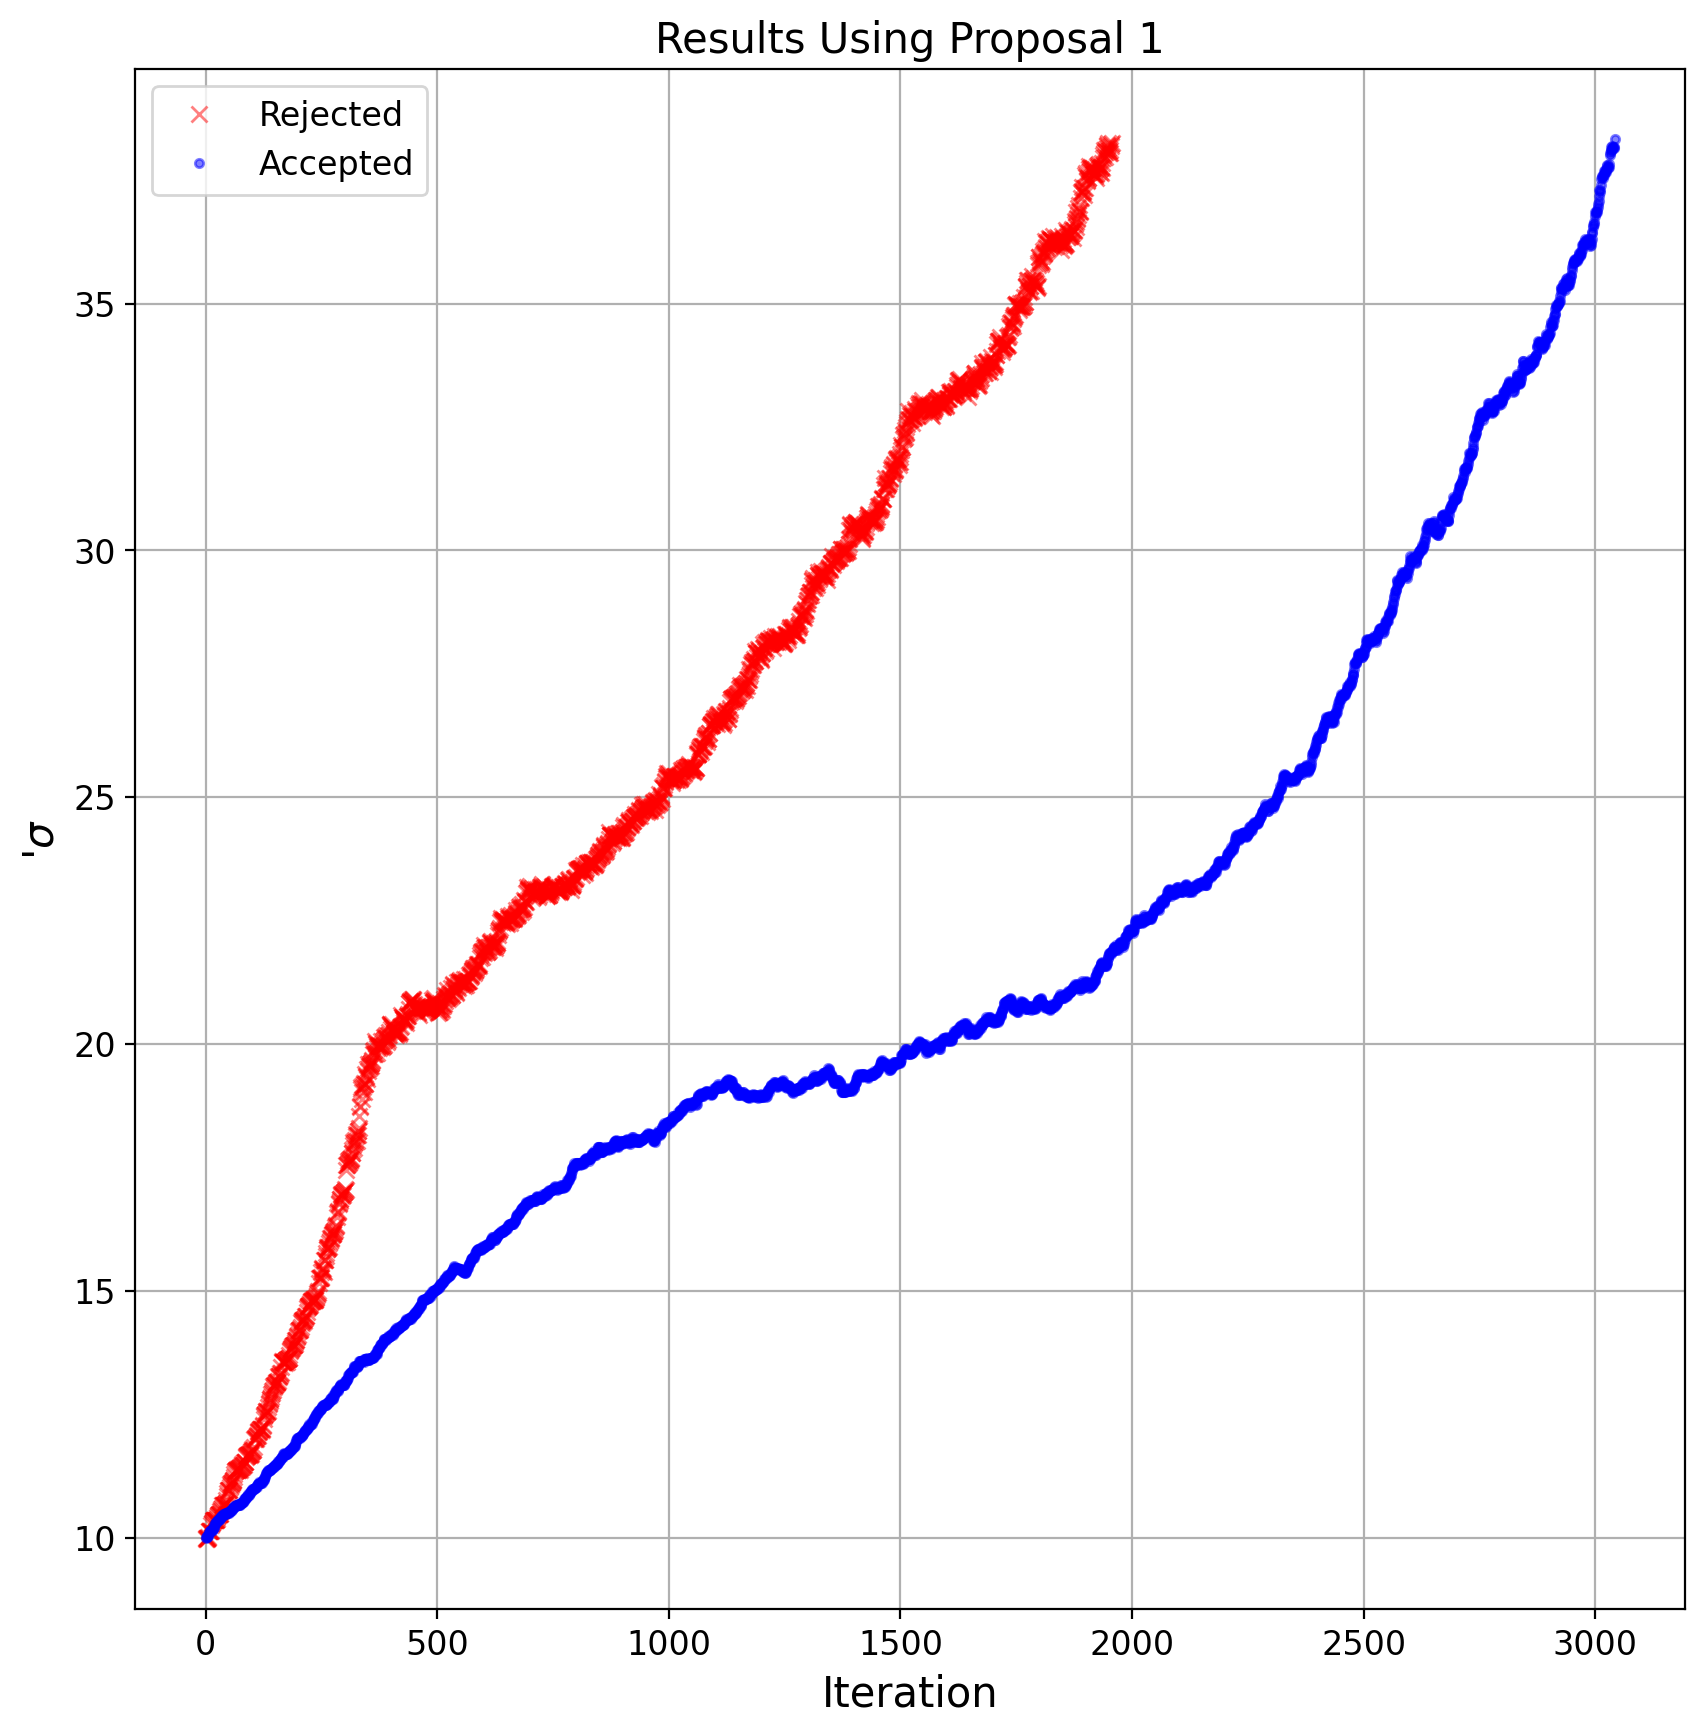

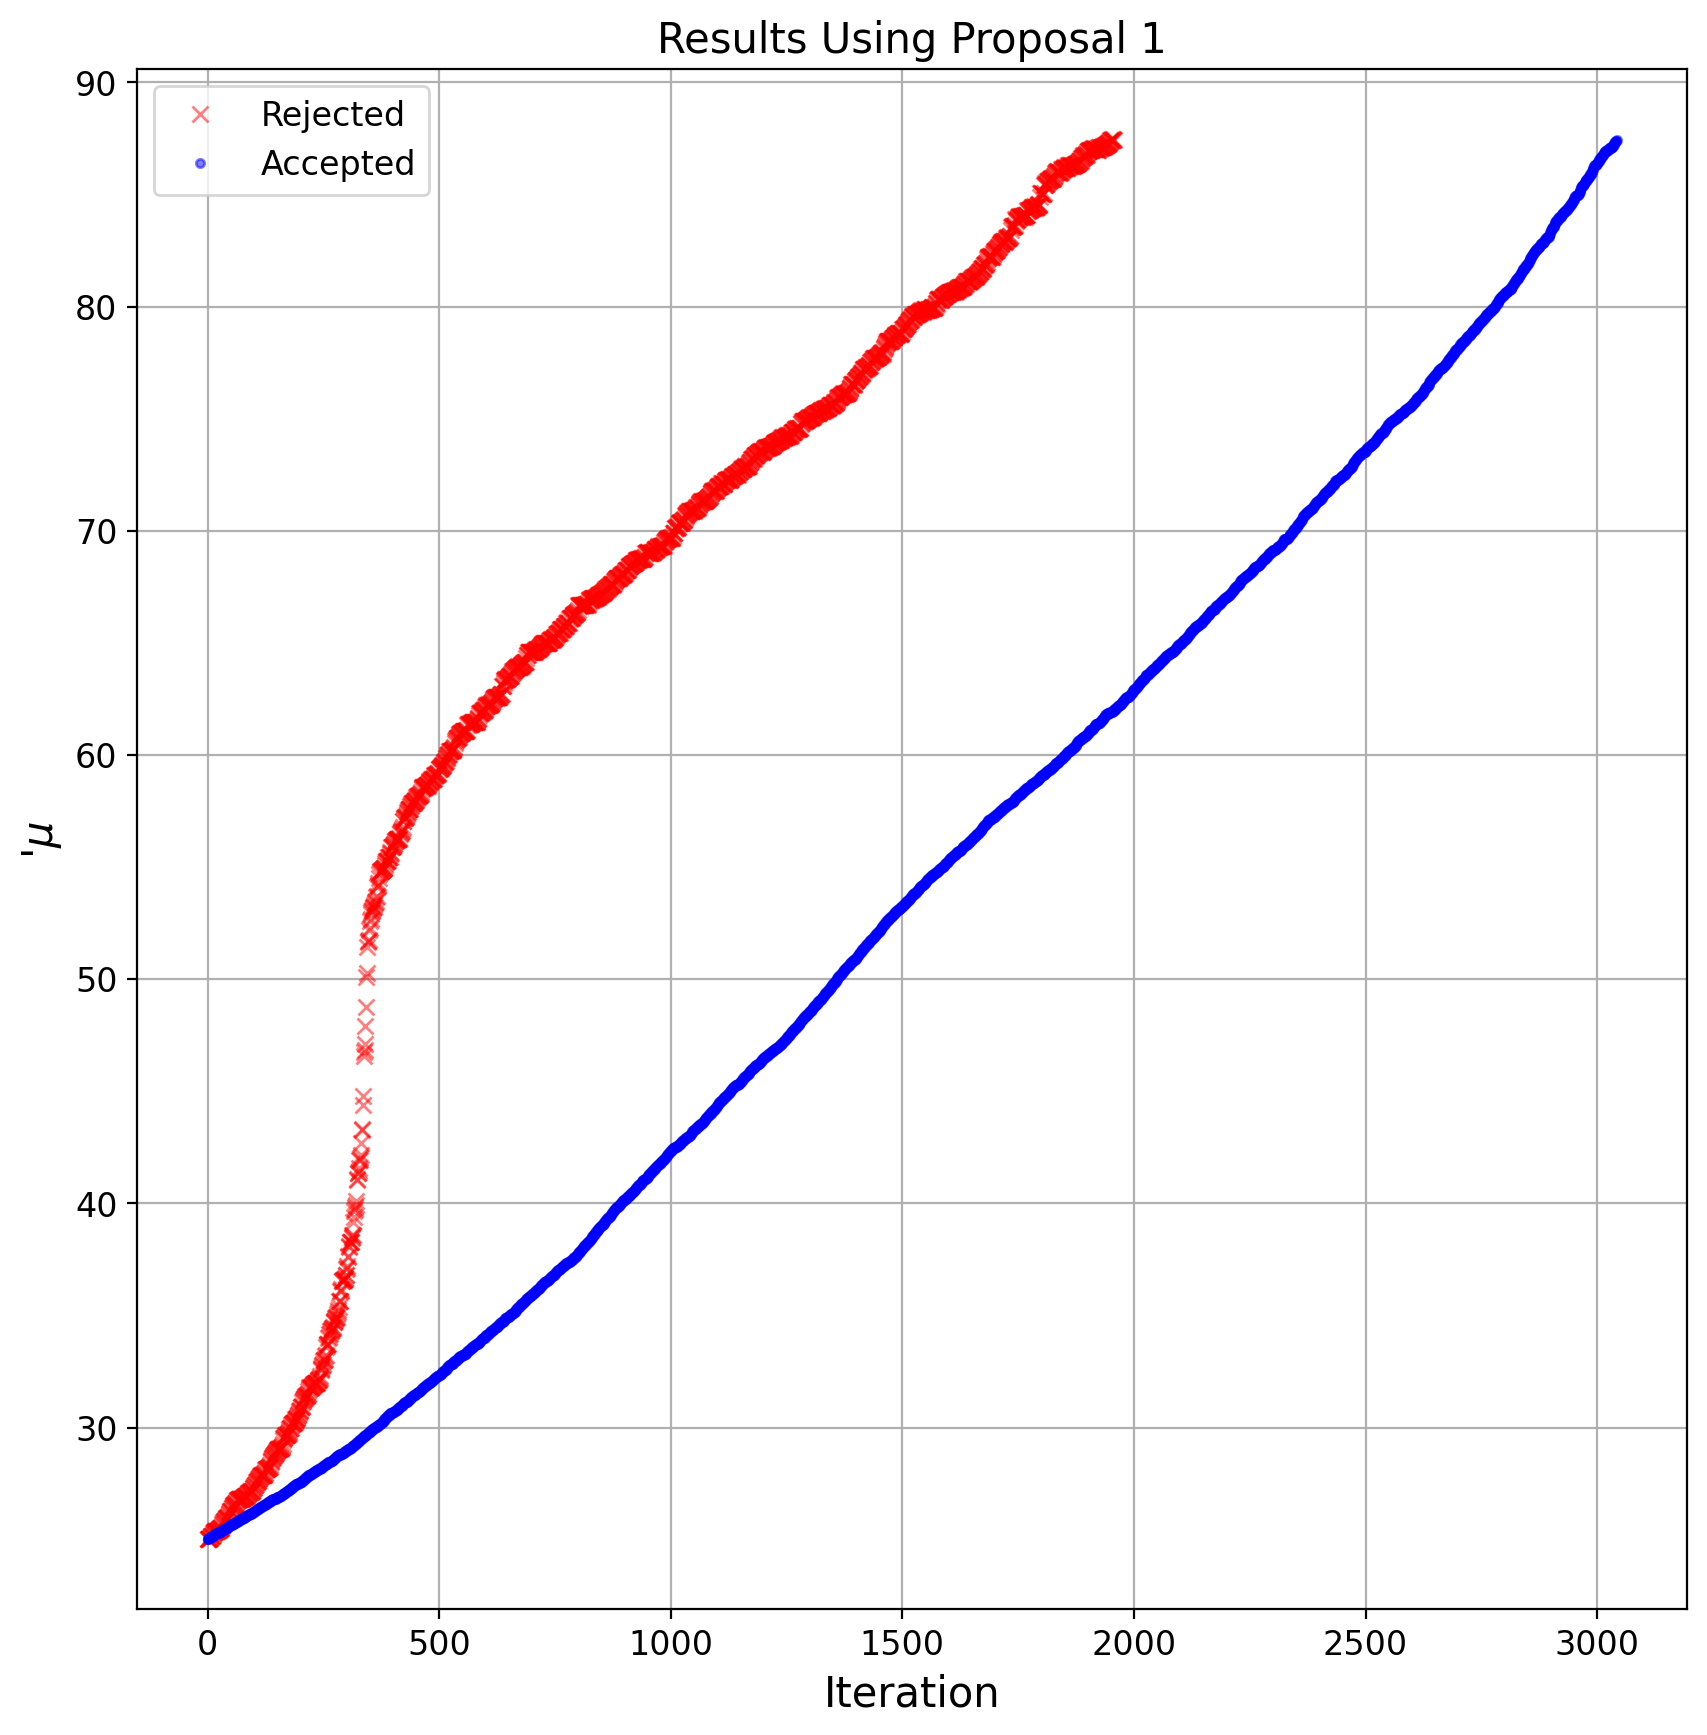

In [16]:
#>>>EXERCISE: L22.1.1

def proposal_1(x,n=2000):
    #[0] = mu, x[11=sigma (new or current)
    x_new = x.copy()
    x_new[0] = x[0] + np.random.rand() *x [1]/np.sqrt(n) /10.
    x_new[1] = x[1] + np.random.randn ()*x[1]/np.sqrt (2*n)/10.
    return x_new

xinit = np.array([25.,10.])
accepted_1, rejected_1, _ = metropolis_hastings(log_like_normal,prior,proposal_1,acceptance,xinit,values,5000)

print("1/10 original uncertainty")
print("Length of last 1000 accepted:",len(accepted_1[-1000:,1]))
print("Average and stdev of last 1000 accepted mu:",accepted_1[-1000:,0].mean(),"+/-",accepted_1[-1000:,0].std())
print("Average and stdev of last 1000 accepted sigma:",accepted_1[-1000:,1].mean(),"+/-",accepted_1[-1000:,1].std())
print()

def proposal_2(x,n=2000):
    x_new = x.copy()
    x_new[0] = x[0] + 10*np.random.rand() *x [1]/np.sqrt(n)
    x_new[1] = x[1] + 10*np.random.randn ()*x[1]/np.sqrt (2*n)
    return x_new

xinit = np.array([25.,10.])
accepted_2, rejected_2, _ = metropolis_hastings(log_like_normal,prior,proposal_2,acceptance,xinit,values,5000)


print("10X original uncertainty")
print("Length of last 1000 accepted:",len(accepted_2[-1000:,1]))
print("Average and stdev of last 1000 accepted mu:",accepted_2[-1000:,0].mean(),"+/-",accepted_2[-1000:,0].std())
print("(Average and stdev of last 1000 accepted sigma:",accepted_2[-1000:,1].mean(),"+/-",accepted_2[-1000:,1].std())
print()


#PLOT REJECTED VS. ACCEPTED
#YOUR CODE HERE (if you want)
fig = plt.figure(figsize=(10,10))
ax2 = fig.add_subplot (1,1,1)

#to_show=-accepted. shape [0]
ax2.set_title( 'Results Using Proposal 1') 
ax2.plot( rejected_1[:,1], 'rx', label='Rejected' ,alpha=0.5)
ax2.plot( accepted_1[:,1], 'b.', label='Accepted' , alpha=0.5)
ax2.set_xlabel("Iteration")
ax2.set_ylabel ("'$\sigma$")
ax2.grid()
ax2.legend ()

fig = plt.figure(figsize=(10,10))
ax2 = fig.add_subplot (1,1,1)

#to_show=-accepted. shape [0]
ax2.set_title( 'Results Using Proposal 1') 
ax2.plot( rejected_1[:,0], 'rx', label='Rejected', alpha=0.5)
ax2.plot( accepted_1[:,0], 'b.', label='Accepted' , alpha=0.5)
ax2.set_xlabel ("Iteration" )
ax2.set_ylabel ("'$\mu$")
ax2.grid ( )
ax2.legend ()
plt.show ()


### <span style="border:3px; border-style:solid; padding: 0.15em; border-color: #90409C; color: #90409C;">Ex-22.1.2</span>

Let's now see what happens when we use a smaller number of events to calculate the parameters and uncertainties. Using your definitions for `proposal_1` and `proposal_2` that you had above, change the final number of events you sample to take just the last 100 events? Play with the results, which answer gives you the correct result (note the cramer-rao bound holds).

A) The uncertainties on both are fine.\
B) Taking the larger range is good for a wide proposal, and the smaller range is good for a narrow proposal. \
C) Taking the larger range is good for a narrow proposal, and the smaller range is good for a wide proposal. \
D) A smaller range is needed for the wide proposal because of turn on, while the narrow proposal gives uncertainties that are too small (below the Cramer-Rao bound) because it is sampling parameters with too small a proposal distribution. 



1/10 original uncertainty
Length of last 100 accepted: 100
Average and stdev of last 100 accepted mu: 86.0042856936447 +/- 0.7705631006162992
Average and stdev of last 100 accepted sigma: 35.450093012726555 +/- 0.5287877849184546

10X original uncertainty
Length of last 100 accepted: 43
Average and stdev of last 100 accepted mu: 47.330023710830844 +/- 7.694185158087741
Average and stdev of last 100 accepted sigma: 19.819213726709197 +/- 1.989476394106189


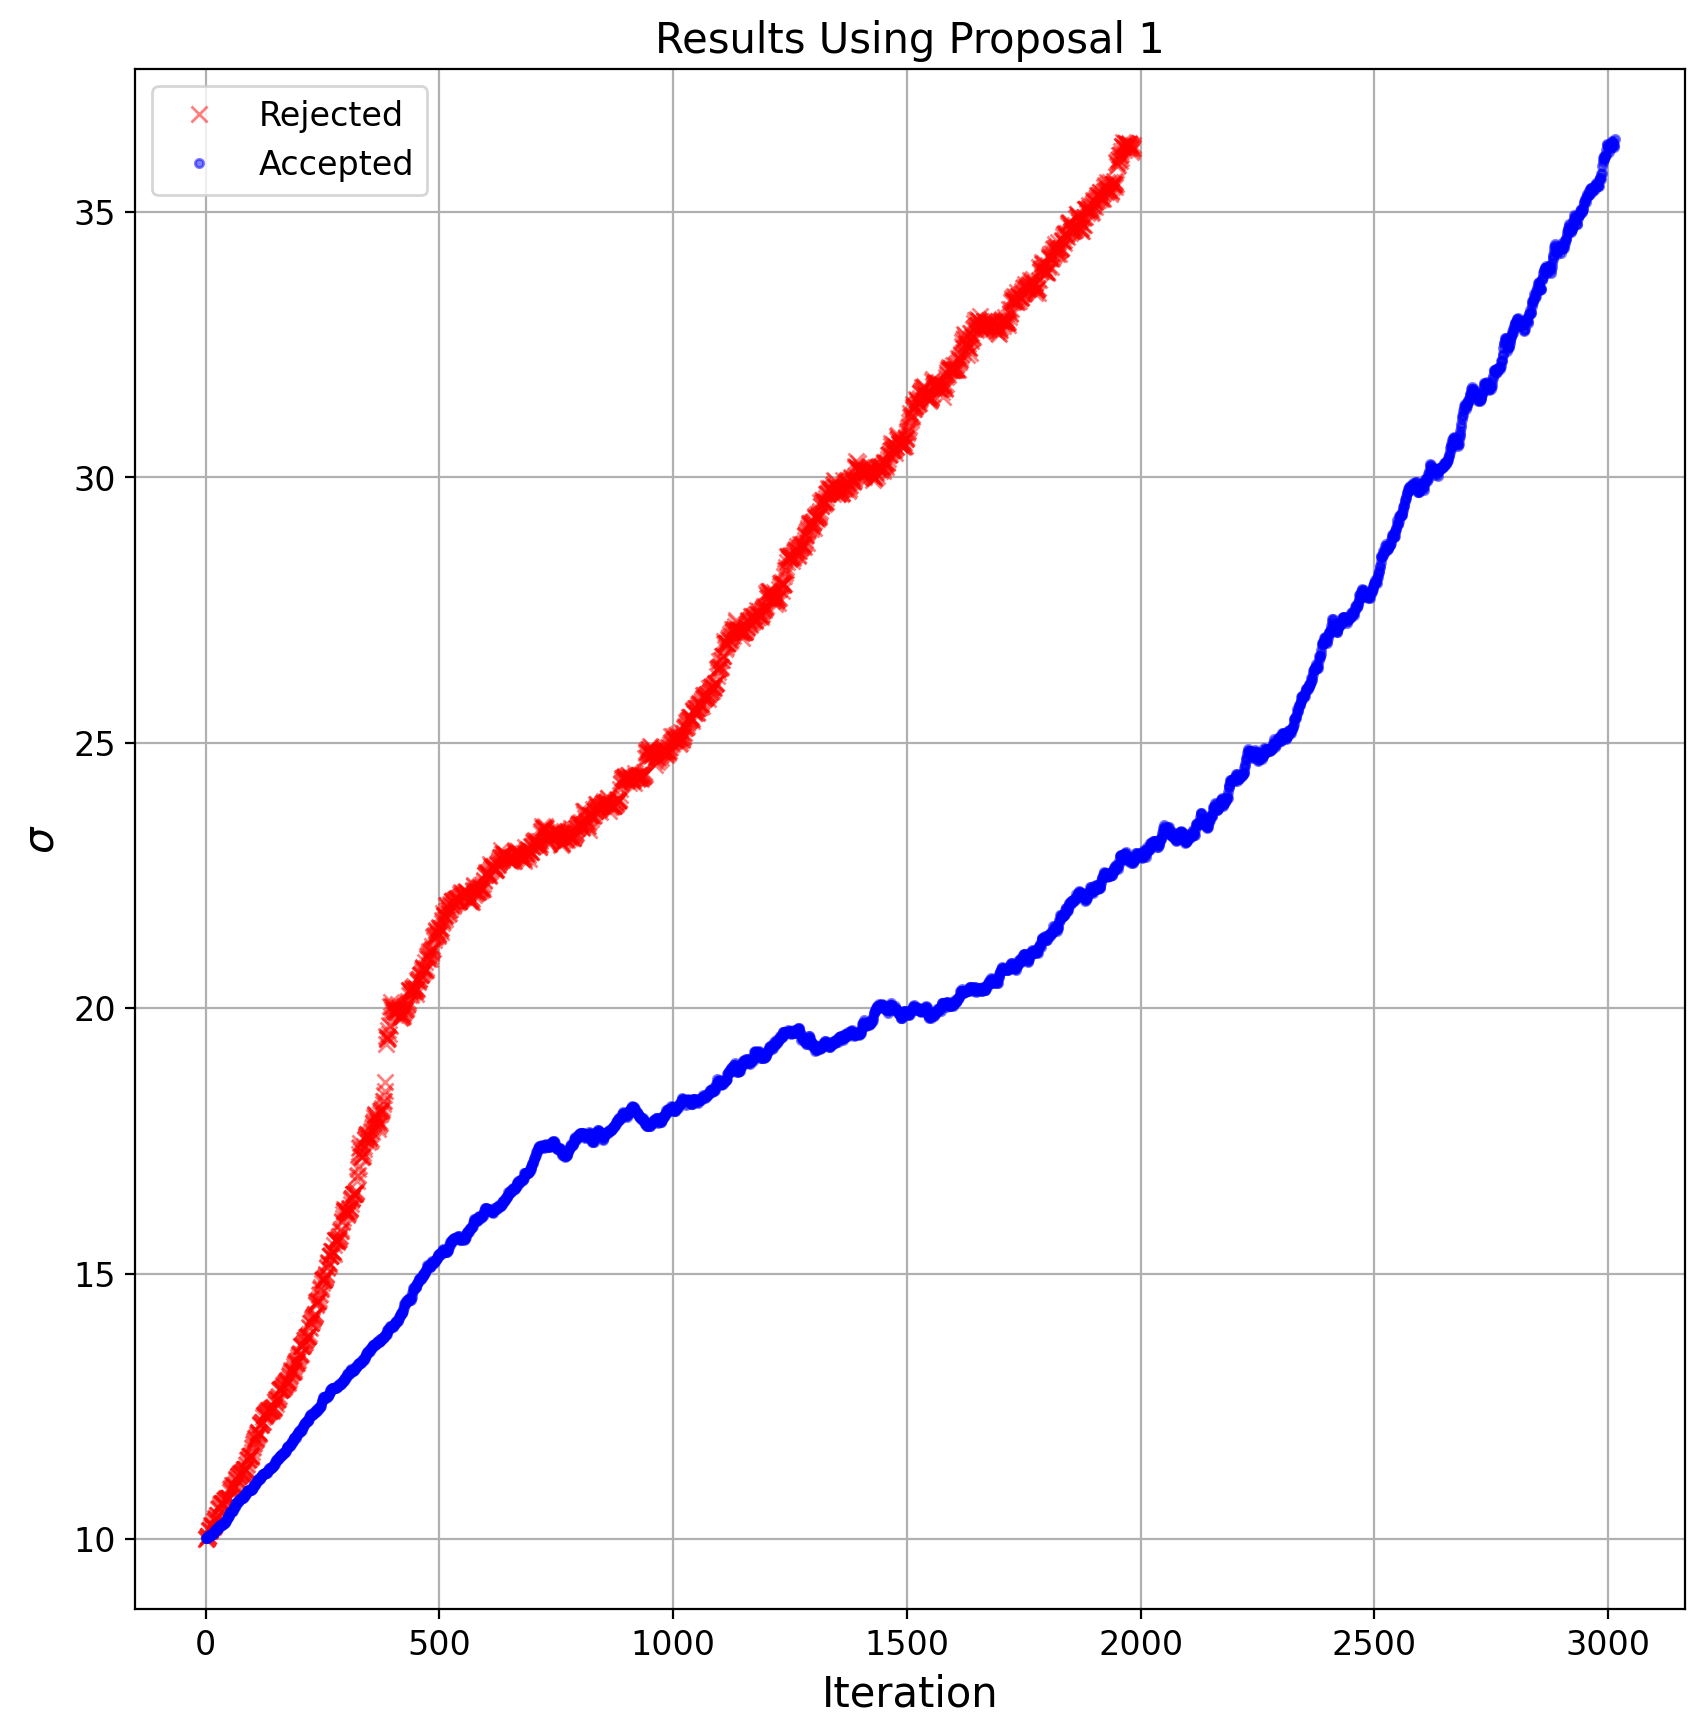

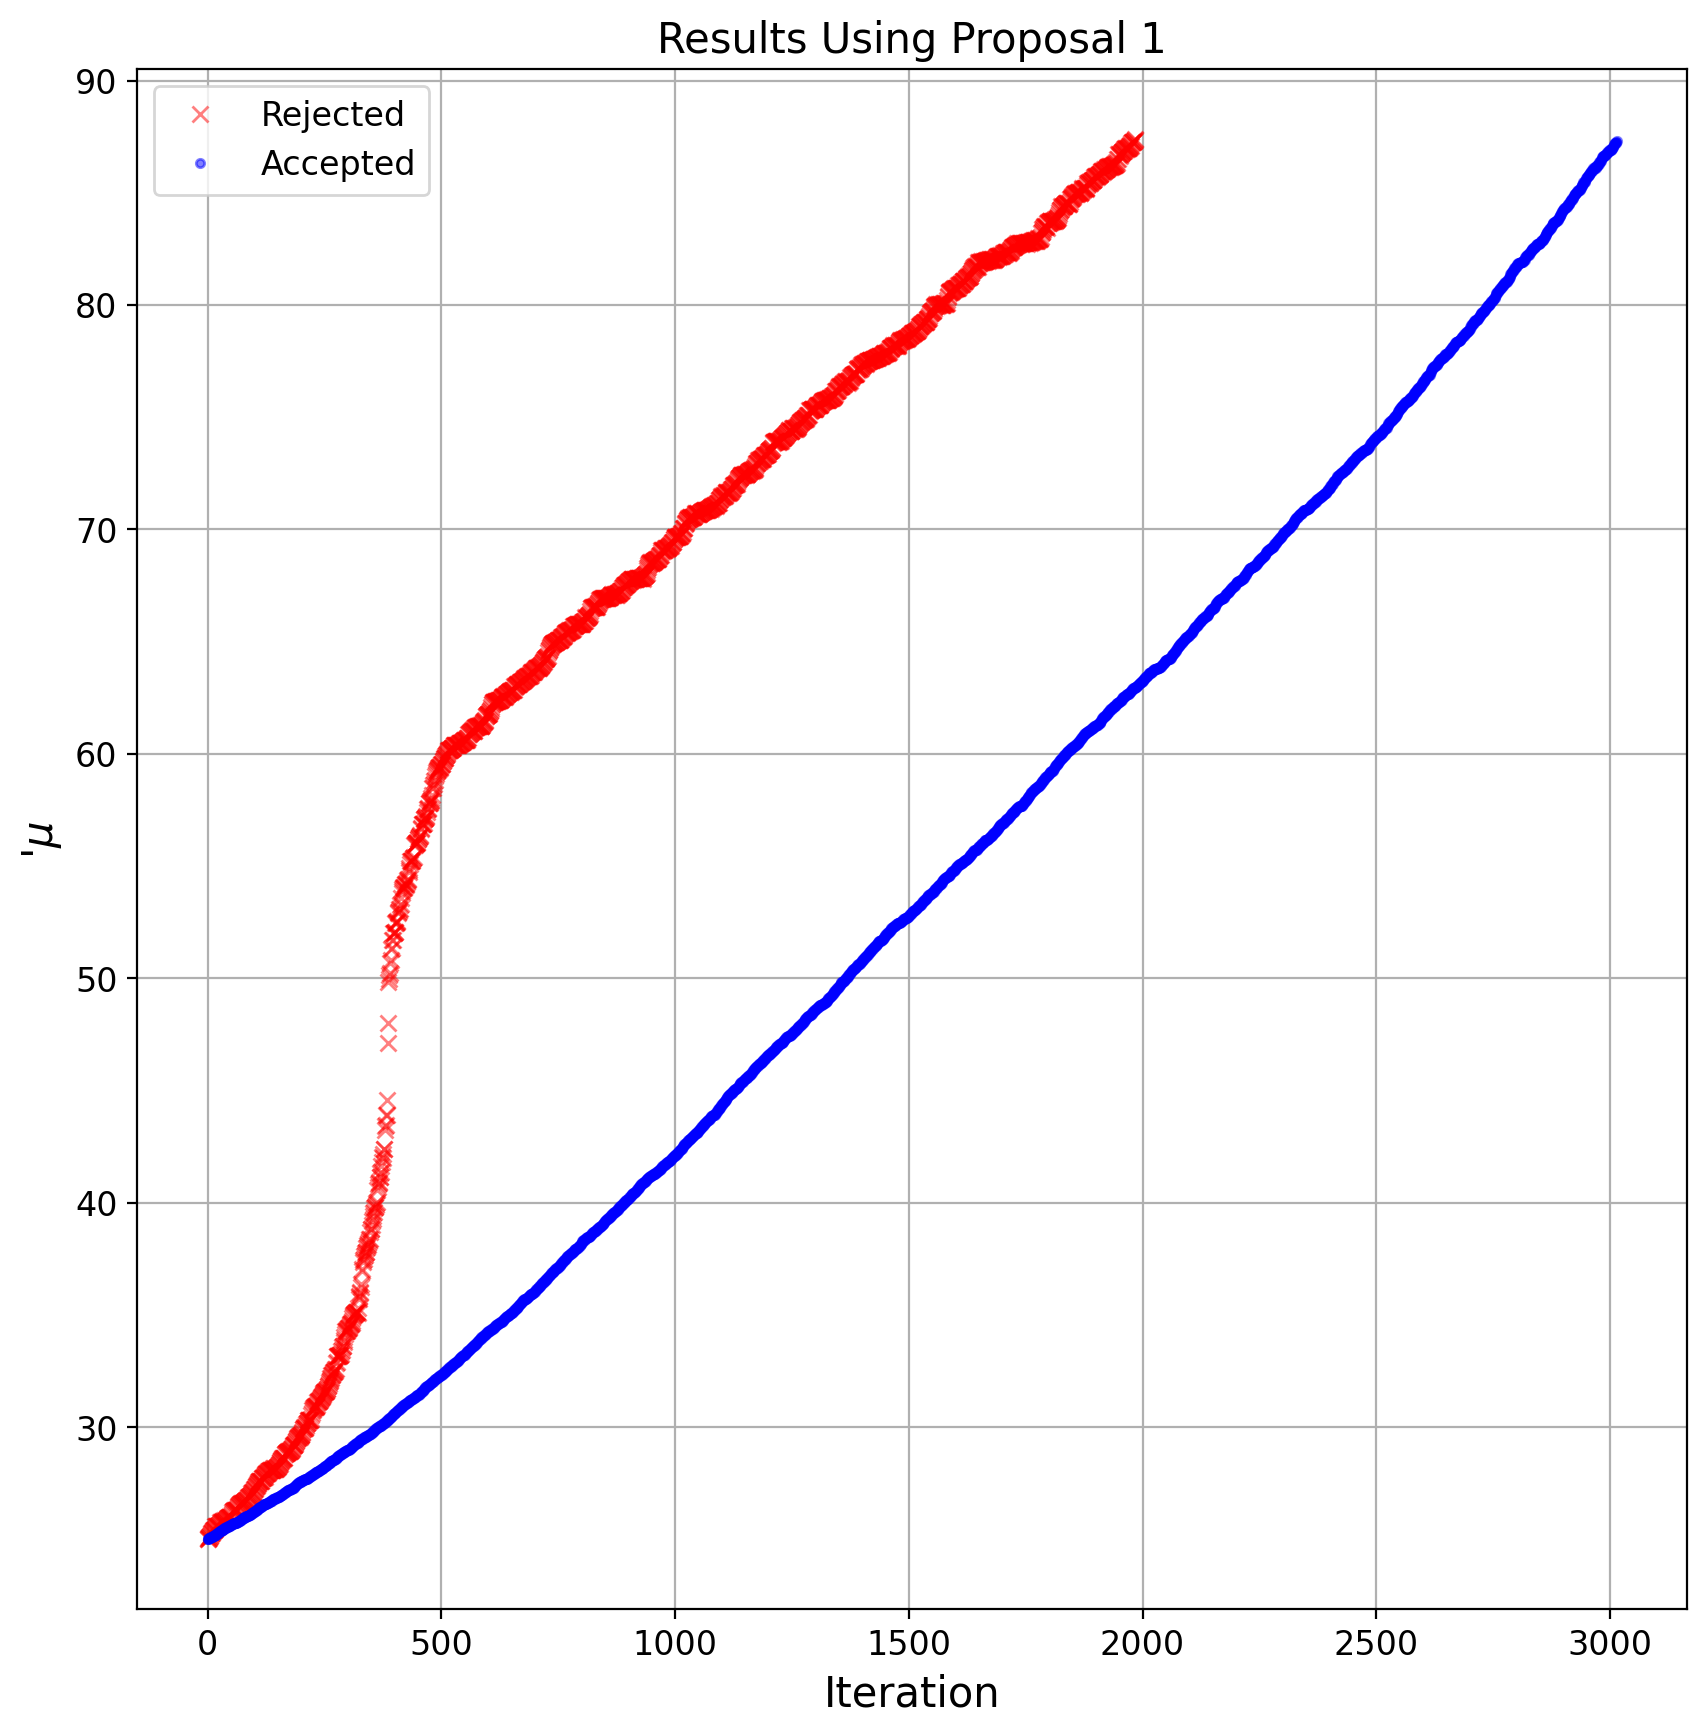

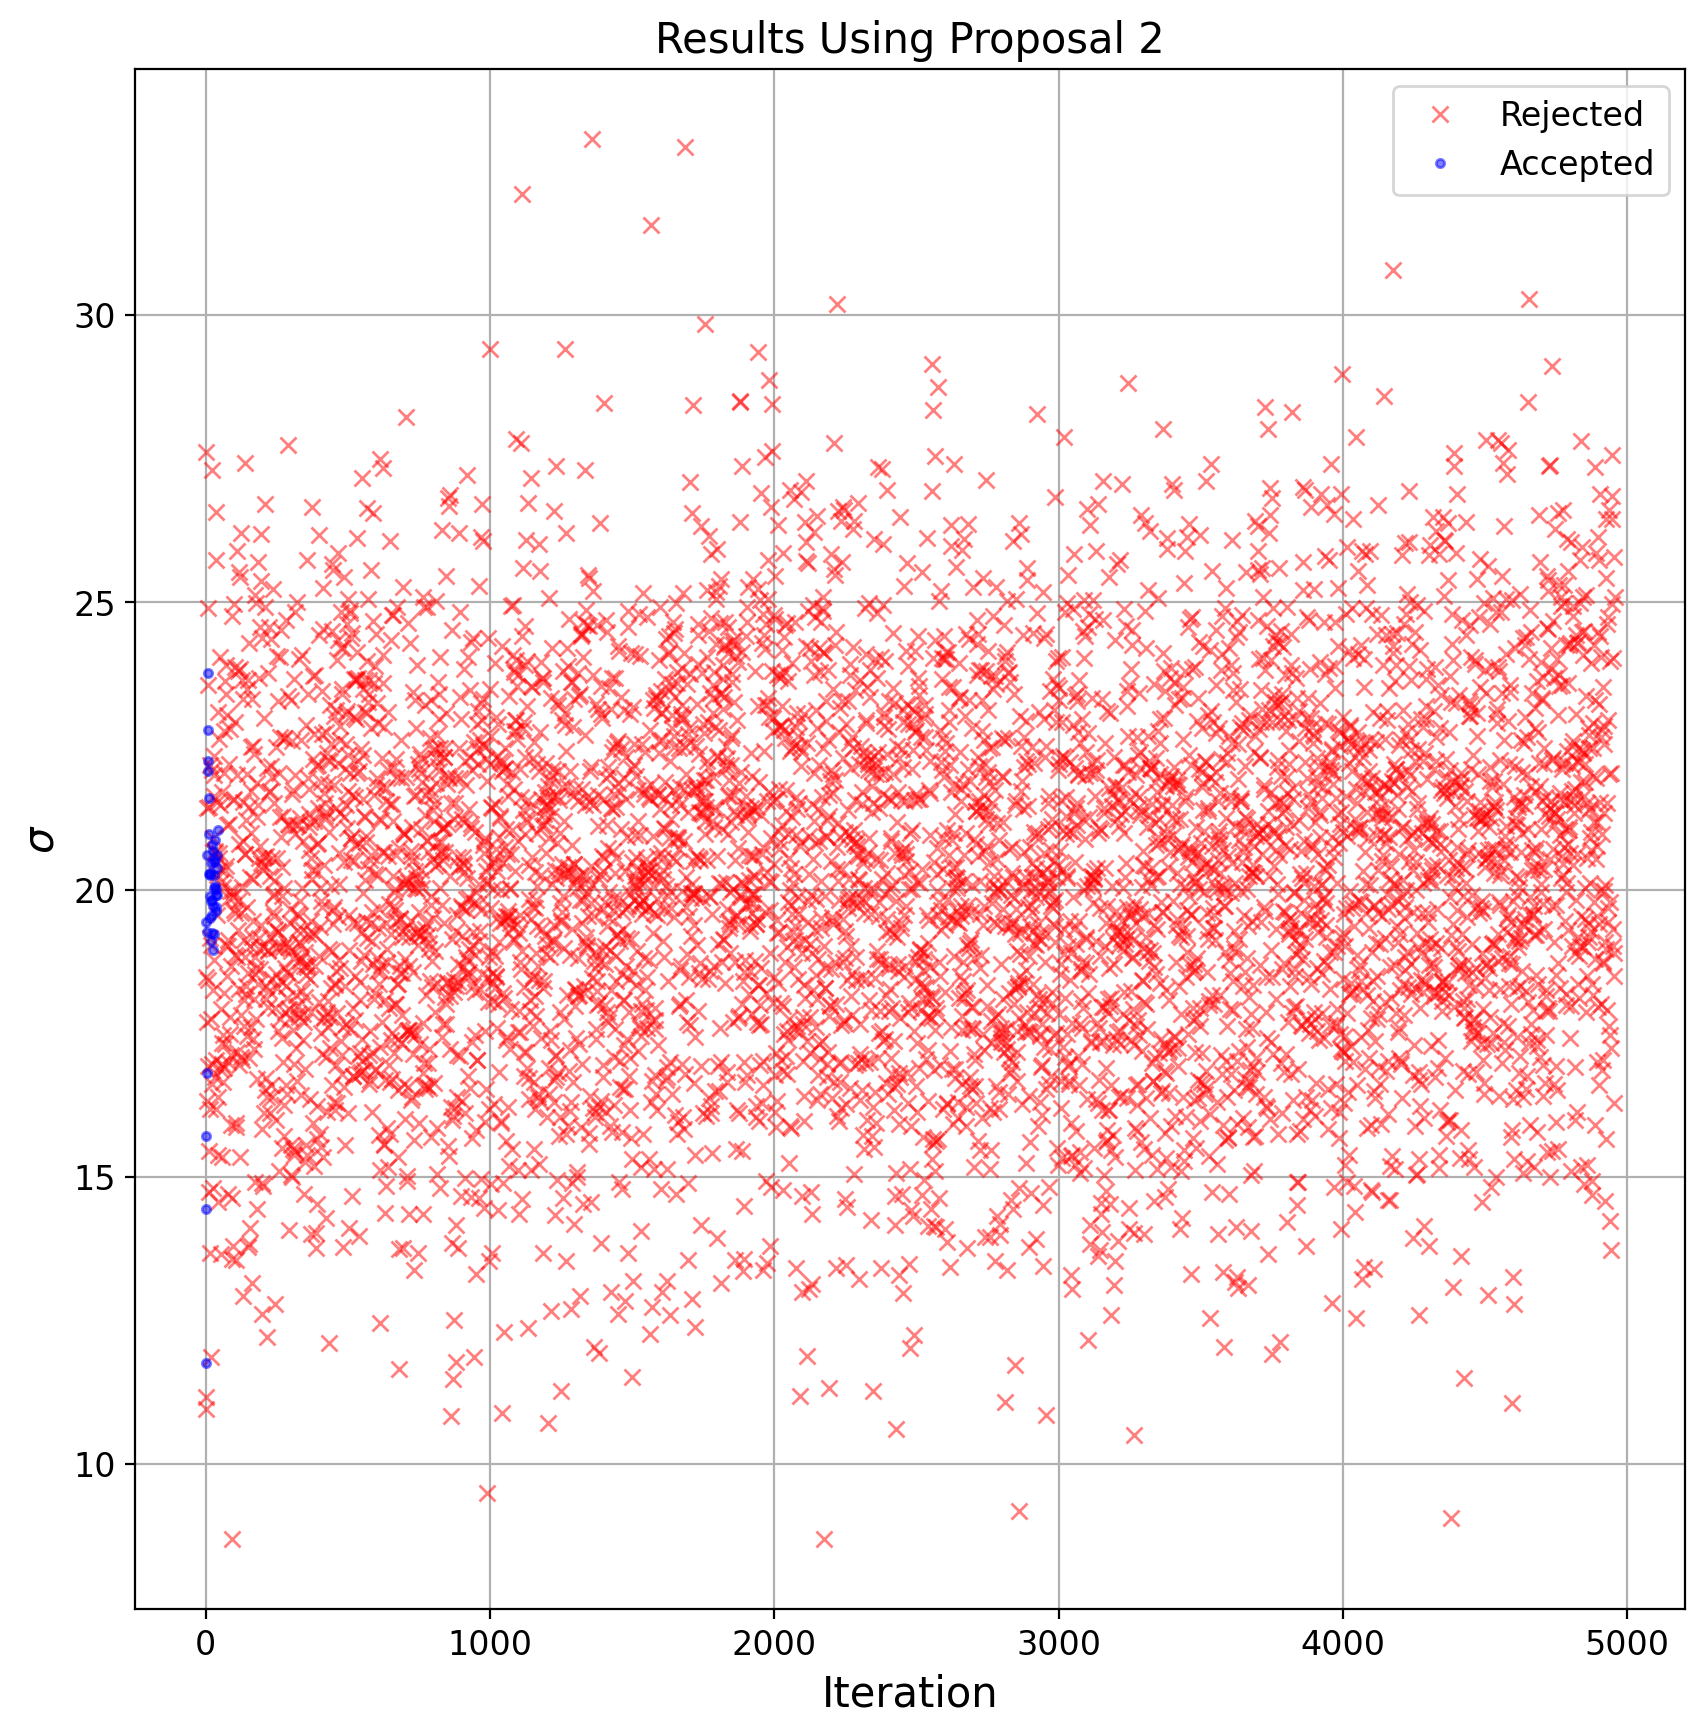

In [17]:
#>>>EXERCISE: L22.1.2

def proposal_1(x,n=2000):
    x_new = x.copy()
    x_new[0] = x[0] + np.random.rand()  *x [1]/np.sqrt(n) /10.
    x_new[1] = x[1] + np.random.randn() *x[1]/np.sqrt (2*n)/10.
    return x_new

xinit = np.array([25.,10.])
accepted_1, rejected_1, _ = metropolis_hastings(log_like_normal,prior,proposal_1,acceptance,xinit,values,5000)

print("1/10 original uncertainty")
print("Length of last 100 accepted:",len(accepted_1[-100:,1]))
print("Average and stdev of last 100 accepted mu:",accepted_1[-100:,0].mean(),"+/-",accepted_1[-100:,0].std())
print("Average and stdev of last 100 accepted sigma:",accepted_1[-100:,1].mean(),"+/-",accepted_1[-100:,1].std())
print()

def proposal_2(x,n=2000):
    x_new = x.copy()
    x_new[0] = x[0] + 10*np.random.rand()  *x[1]/np.sqrt(n)
    x_new[1] = x[1] + 10*np.random.randn() *x[1]/np.sqrt (2*n)
    return x_new

xinit = np.array([25.,10.])
accepted_2, rejected_2, _ = metropolis_hastings(log_like_normal,prior,proposal_2,acceptance,xinit,values,5000)

print("10X original uncertainty")
print("Length of last 100 accepted:", len (accepted_2 [-100:, 1]) )
print ("Average and stdev of last 100 accepted mu:", accepted_2 [-100:, 0].mean (), "+/-", accepted_2 [-100:, 0].std())
print("Average and stdev of last 100 accepted sigma:", accepted_2 [-100:, 1].mean ( ), "+/-", accepted_2 [-100:, 1].std())
                   
                                                                  
#PLOT REJECTED VS. ACCEPTED
fig = plt.figure(figsize=(10,10))
ax2 = fig.add_subplot (1,1,1)
                                                                  
#to_show=-accepted. shape [0]
ax2.set_title( 'Results Using Proposal 1') 
ax2.plot(rejected_1[:,1],   'rx',   label='Rejected', alpha=0.5)
ax2.plot (accepted_1[:,1], 'b.',   label='Accepted', alpha=0.5)
ax2.set_xlabel("Iteration")
ax2.set_ylabel("$\sigma$")
ax2.grid()
ax2.legend ()
                                                                  
fig = plt.figure(figsize=(10,10))
ax2 = fig.add_subplot (1,1,1)
                                                                  
#to_show=-accepted. shape |0]
ax2.set_title( 'Results Using Proposal 1')
ax2.plot(rejected_1[:,0], 'rx',   label='Rejected' ,alpha=0.5) 
ax2. plot( accepted_1[:,0], 'b.', label='Accepted' ,alpha=0.5)
ax2.set_xlabel("Iteration")
ax2.set_ylabel ("'$\mu$")
ax2.grid()
ax2.legend ()
plt.show()
                                                                  
fig = plt. figure (figsize=(10,10))
ax2 = fig.add_subplot (1,1,1)
#to_show=-accepted. shape [0]

ax2.set_title( 'Results Using Proposal 2')
ax2.plot( rejected_2[:,1], 'rx', label='Rejected' ,alpha=0.5)
ax2.plot( accepted_2[:,1], 'b.', label='Accepted', alpha=0.5)
ax2.set_xlabel("Iteration")
ax2.set_ylabel ("$\sigma$")
ax2.grid()                                                                  
ax2.legend ()
plt.show()

<a name='section_23_2'></a>
<hr style="height: 1px;">

## <h2 style="border:1px; border-style:solid; padding: 0.25em; color: #FFFFFF; background-color: #90409C">L22.2 Understanding Some Details </h2>  

| [Top](#section_23_0) | [Previous Section](#section_23_1) | [Exercises](#exercises_23_2) | [Next Section](#section_23_3) |

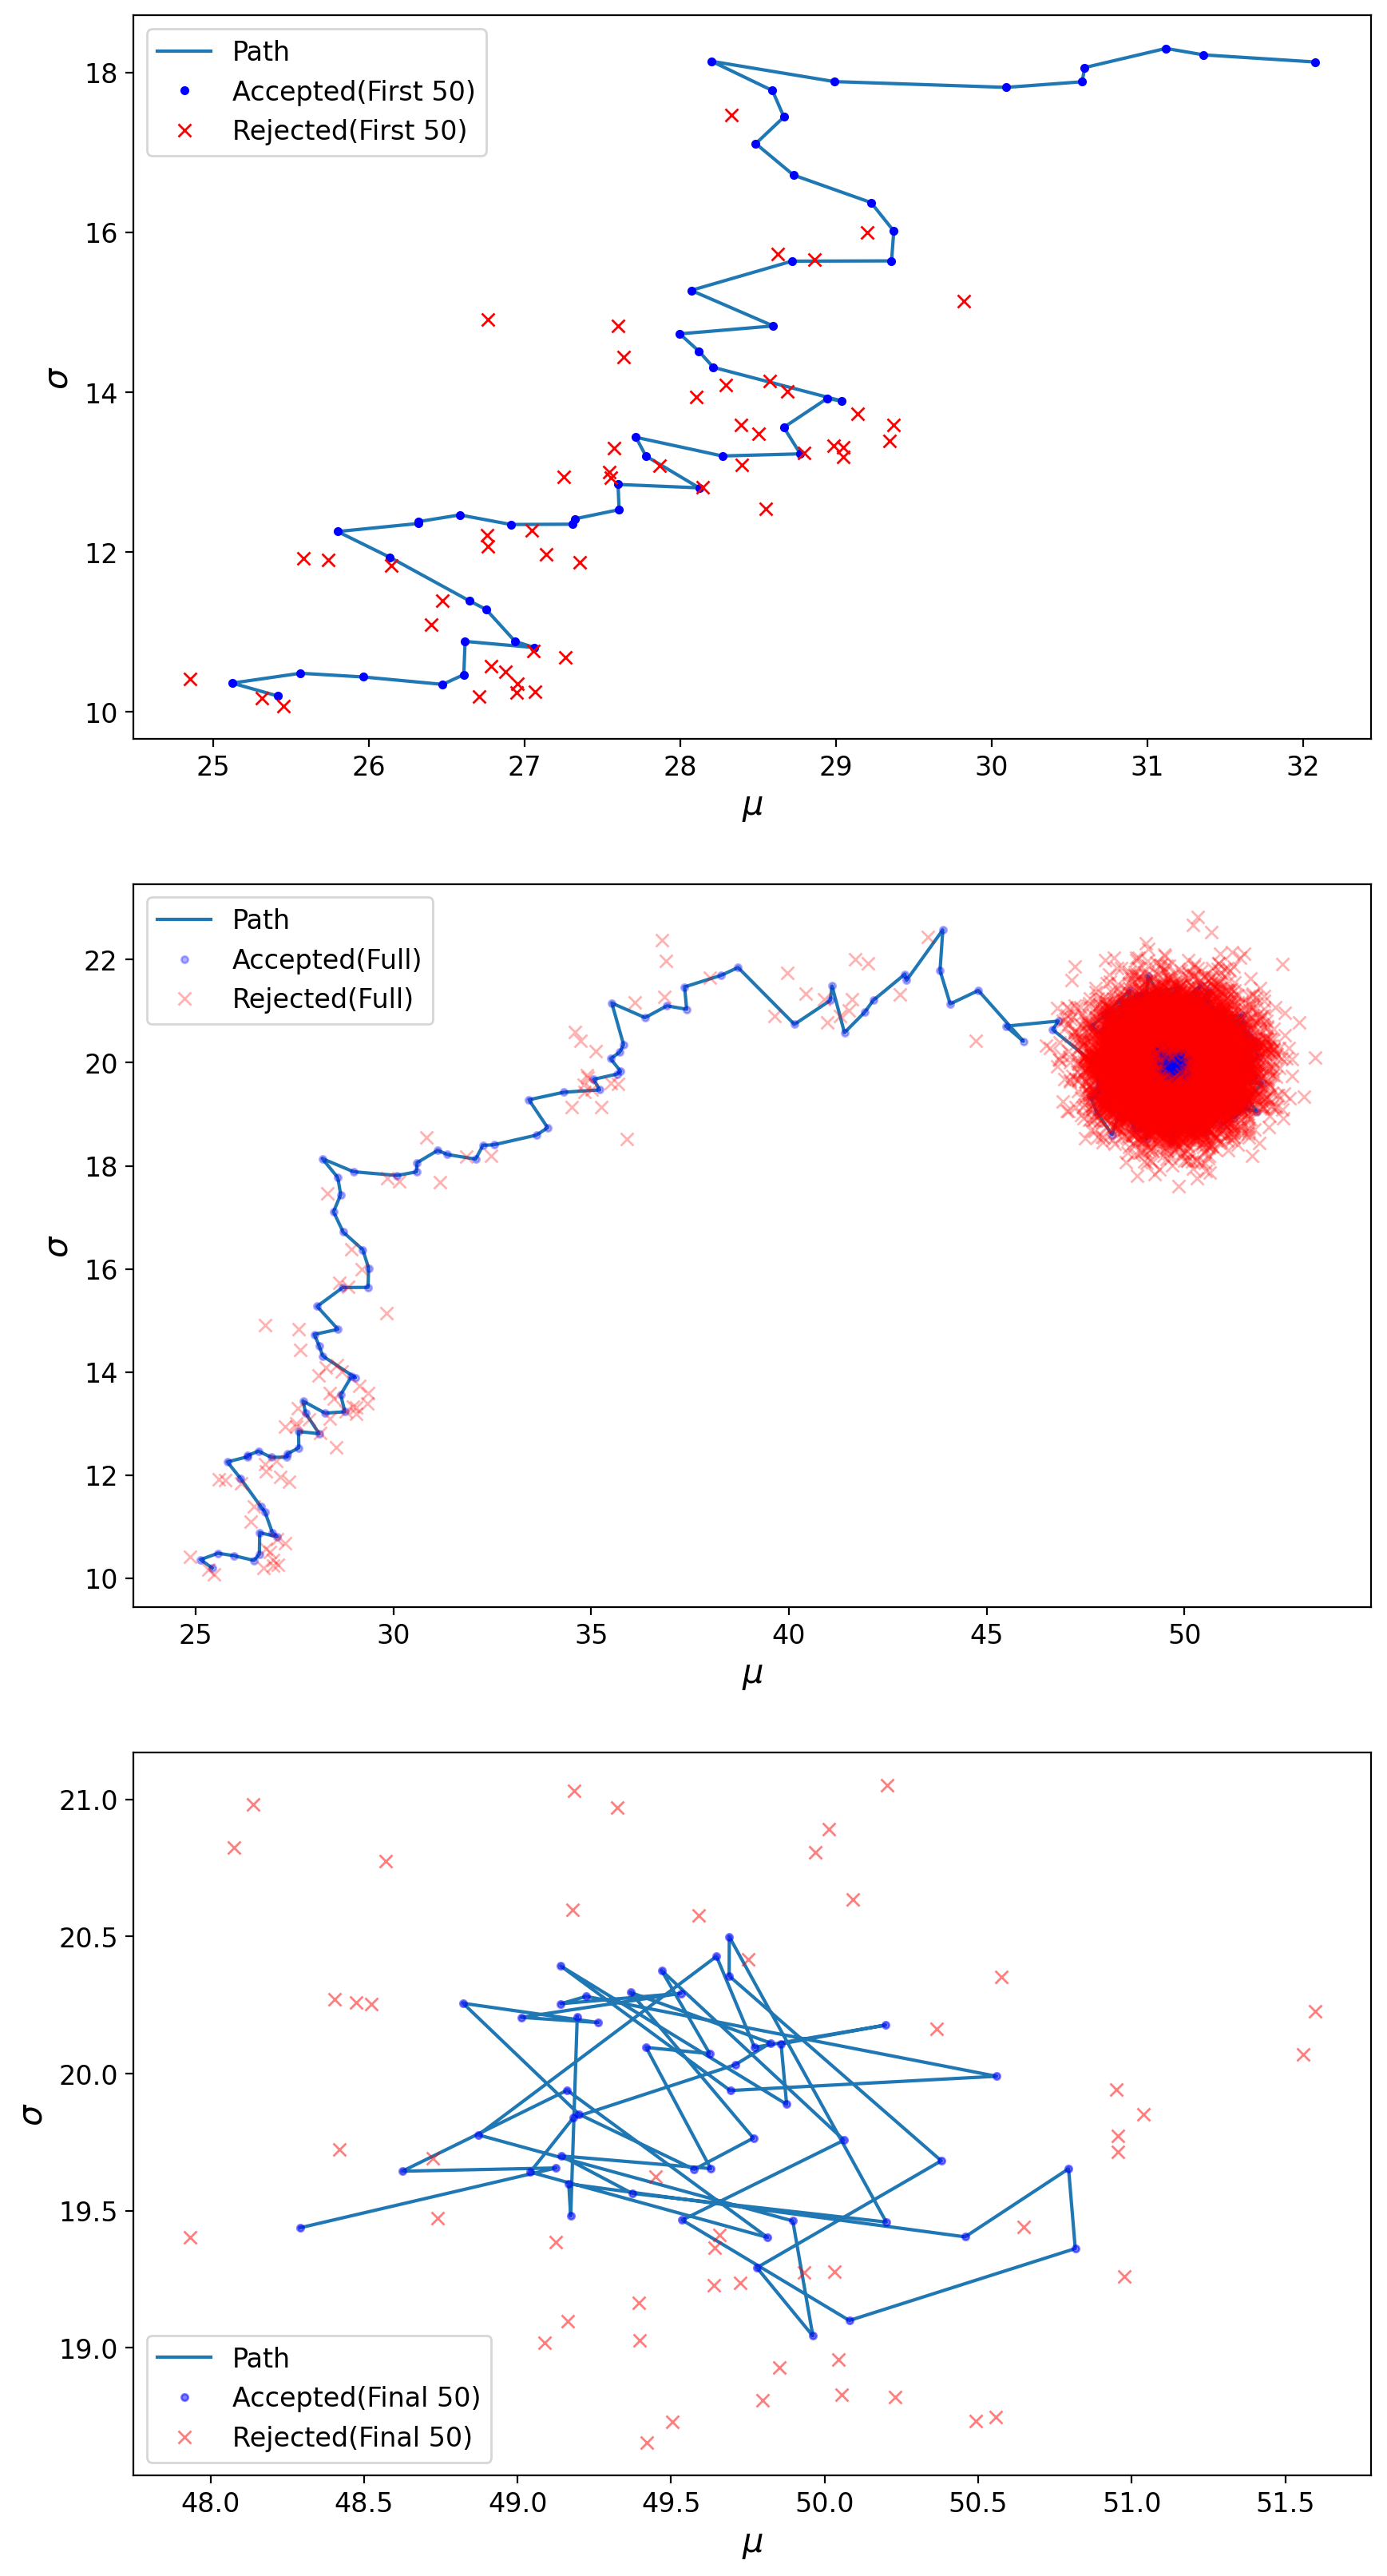

In [18]:
#>>>RUN: L22.2-runcell01

#This cell plots results from our original run, which produced the array `accepted`

fig = plt.figure(figsize=(10,20))
ax = fig.add_subplot(3,1,1)
ax.plot(accepted[:50,0], accepted[:50,1], label="Path")
ax.plot(accepted[:50,0], accepted[:50,1], 'b.', label='Accepted(First 50)')
ax.plot(rejected[:50,0], rejected[:50,1], 'rx', label='Rejected(First 50)')
ax.set_xlabel("$\mu$")
ax.set_ylabel("$\sigma$")
ax.legend()


ax = fig.add_subplot(3,1,2)
ax.plot(accepted[:,0], accepted[:,1], label="Path")
ax.plot(accepted[:,0], accepted[:,1], 'b.', label='Accepted(Full)',alpha=0.3)
ax.plot(rejected[:,0], rejected[:,1], 'rx', label='Rejected(Full)',alpha=0.3)
ax.set_xlabel("$\mu$")
ax.set_ylabel("$\sigma$")
ax.legend()
ax.set_title("") 

to_show=50
ax = fig.add_subplot(3,1,3)
ax.plot(accepted[-to_show:,0], accepted[-to_show:,1], label="Path")
ax.plot(accepted[-to_show:,0], accepted[-to_show:,1], 'b.', label='Accepted(Final 50)',alpha=0.5)
ax.plot(rejected[-to_show:,0], rejected[-to_show:,1], 'rx', label='Rejected(Final 50)',alpha=0.5)
ax.set_xlabel("$\mu$")
ax.set_ylabel("$\sigma$")
ax.legend()


49.56521475209044 19.932784108821217


[Text(0.5, 0, 'steps'), Text(0, 0.5, 'autocorrelation'), (-1.0, 1.0)]

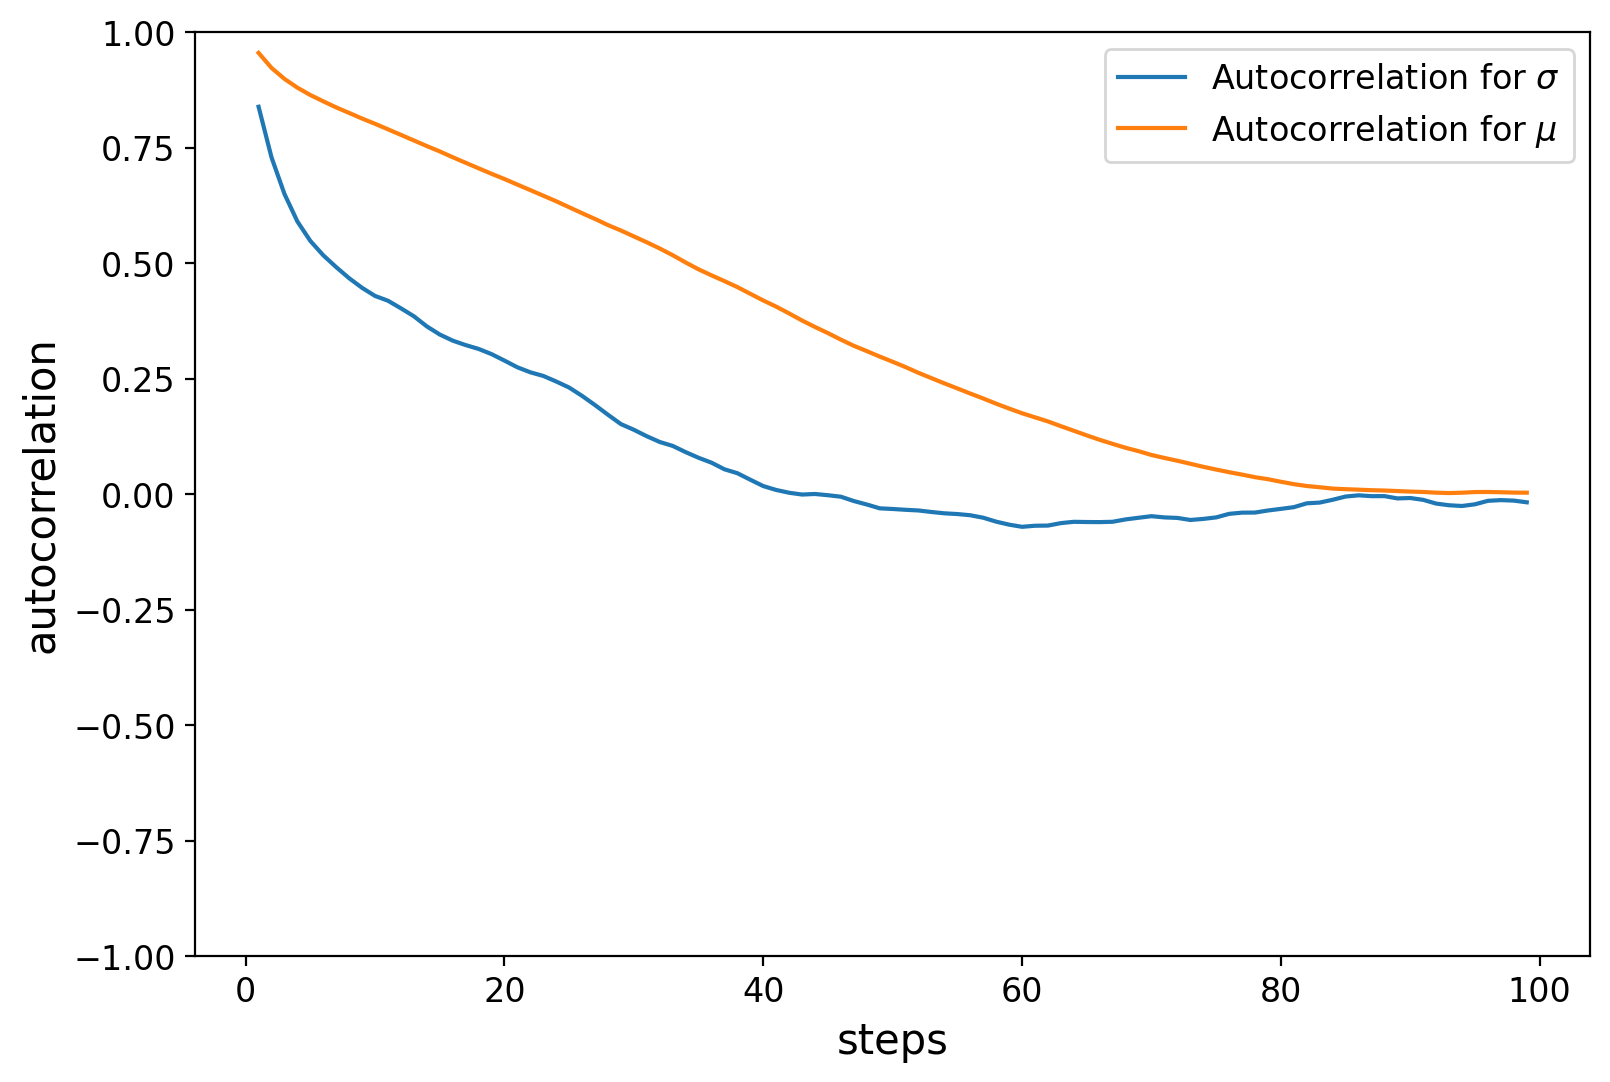

In [19]:
#>>>RUN: L22.2-runcell02

mean_acc_mu=accepted[-100:,0].mean()
mean_acc_sig=accepted[-100:,1].mean()
print(mean_acc_mu,mean_acc_sig)

def autocorr(accepted,lag):
    num_mu=0
    denom_mu=0
    num_sig=0
    denom_sig=0
    rk_mu,rk_sig = 0, 0
    for i in range(accepted.shape[0]-lag):
        num_mu+=(accepted[i,0]-mean_acc_mu)*(accepted[i+lag,0]-mean_acc_mu)
        num_sig+=(accepted[i,1]-mean_acc_sig)*(accepted[i+lag,1]-mean_acc_sig)
        denom_mu+=(mean_acc_mu-accepted[i,0])**2
        denom_sig+=(mean_acc_sig-accepted[i,1])**2
    if denom_mu > 0 and denom_sig > 0:
        rk_mu=num_mu/denom_mu
        rk_sig=num_sig/denom_sig
    return rk_mu, rk_sig


lag=np.arange(1,100)
result=np.zeros((2,lag.shape[0]))
for l in lag:
    result[:,l-1]=autocorr(accepted,l)


fig, ax = plt.subplots()
ax.plot(lag, result[1,:], label='Autocorrelation for $\sigma$')
ax.plot(lag, result[0,:], label='Autocorrelation for $\mu$')
ax.legend(loc=0)
ax.set(xlabel='steps', ylabel='autocorrelation', ylim=(-1, 1))

(8296, 2)


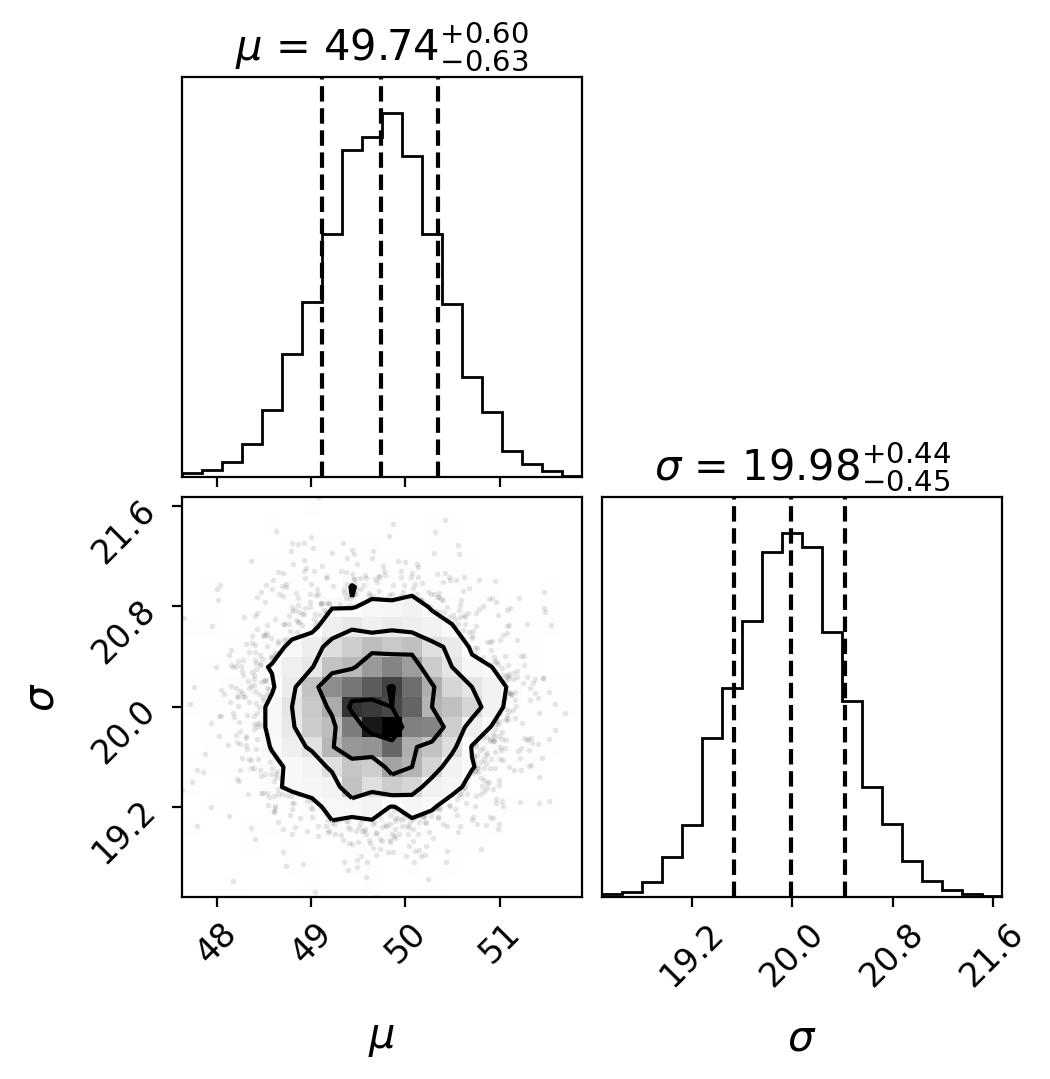

In [20]:
#>>>RUN: L22.2-runcell03
 
labels = ['$\mu$','$\sigma$']
print(accepted.shape)
samples=accepted[-5000:-1,:]
#samples=np.reshape(samples,(samples.shape[0]*samples.shape[1],samples.shape[2]))
#print(samples.shape)
fig = corner.corner(samples,show_titles=True,labels=labels,plot_datapoints=True,quantiles=[0.16, 0.5, 0.84])


### <span style="border:3px; border-style:solid; padding: 0.15em; border-color: #90409C; color: #90409C;">Exercise 22.2.1</span>

Plot the corner plot for the first 100 steps of the fit. What do your parameters look like, and do you observe a correlation (why or why not)?

A) The fitted parameters are similar to those in `L22.2-runcell03`, and can be used. There is no correlation. \
B) The equilibration stage is present in the corner plots, and you see parameters move to the best fit with a positive correltion. \
C) There is a negative correlation between the parameters.
<br>

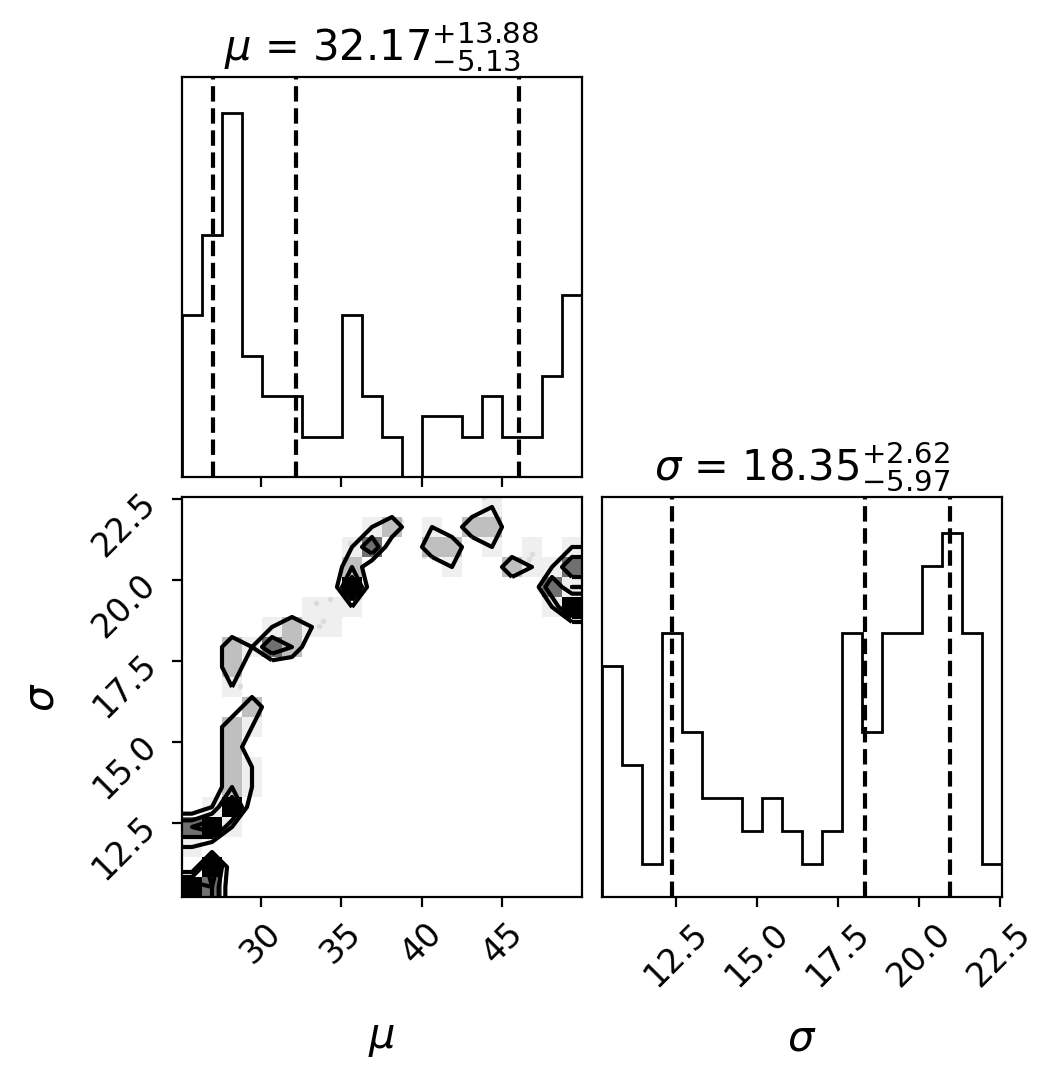

In [21]:
#>>>EXERCISE: L22.2.1

samples=samples=accepted [0:100,:]
fig = corner.corner(samples,show_titles=True,labels=labels,plot_datapoints=True,quantiles=[0.16, 0.5, 0.84])

<a name='section_23_3'></a>
<hr style="height: 1px;">

## <h2 style="border:1px; border-style:solid; padding: 0.25em; color: #FFFFFF; background-color: #90409C">L22.3 A More Realistic Markov Chain MC</h2>  

| [Top](#section_23_0) | [Previous Section](#section_23_2) | [Exercises](#exercises_23_3) |

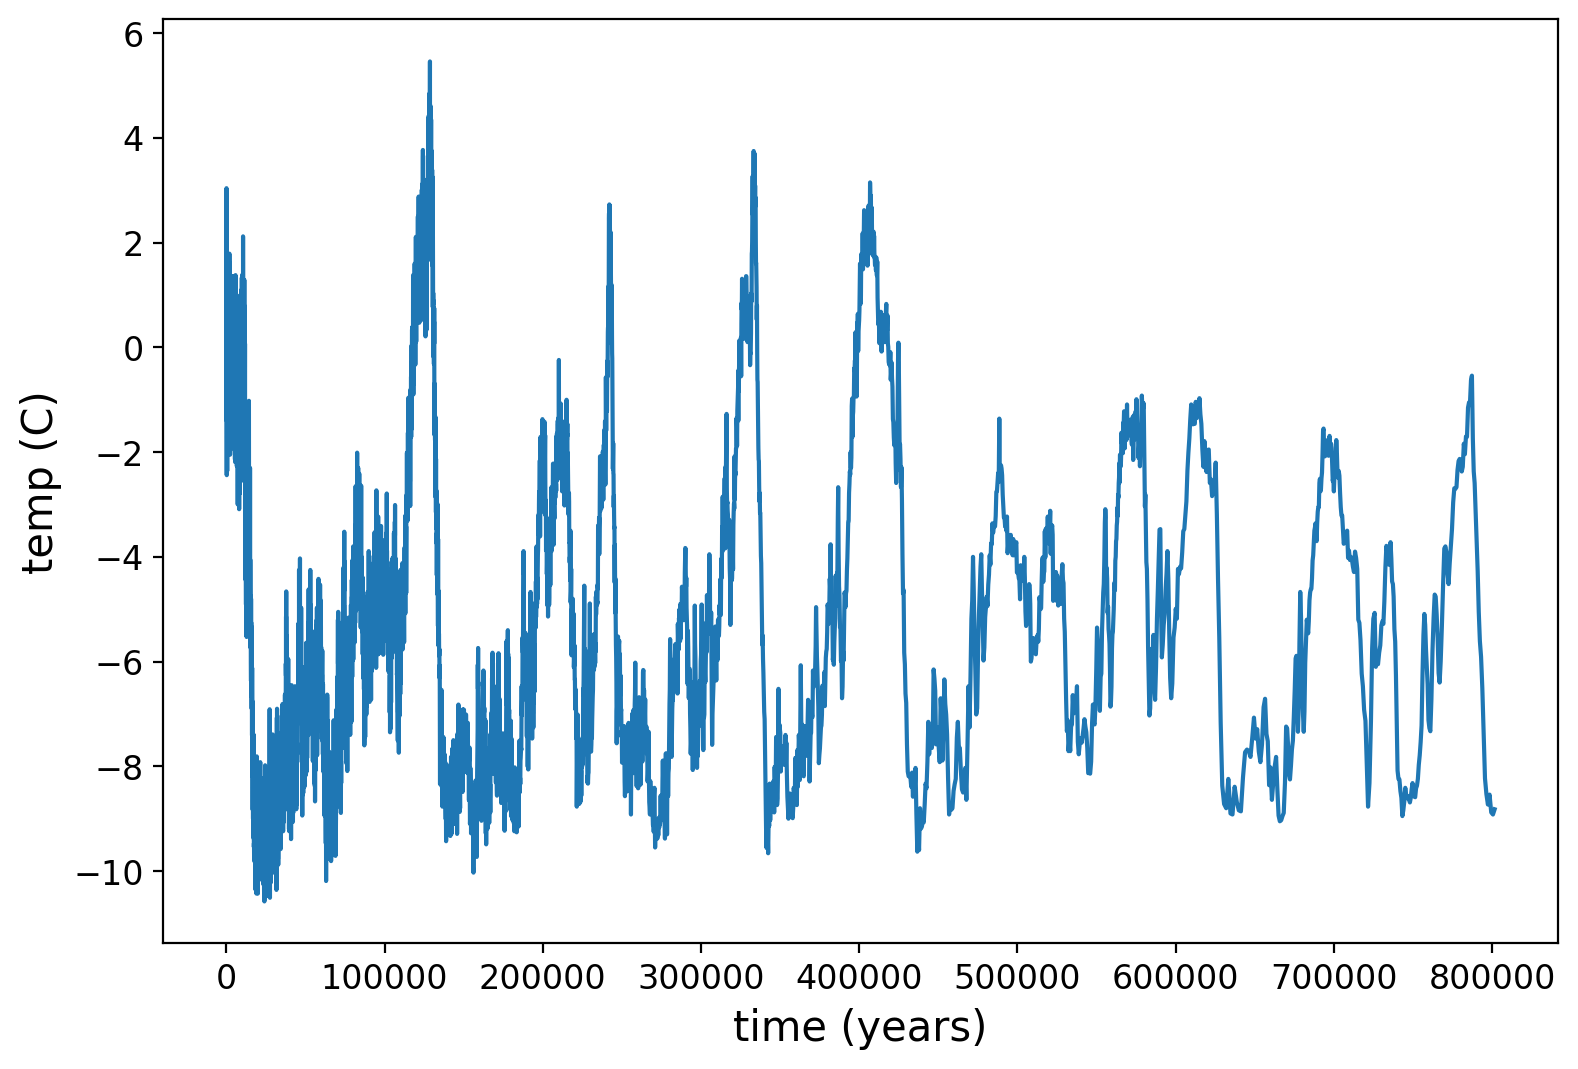

In [22]:
#>>>RUN: L22.3-runcell01

import csv 

def load(iFile='data/L23/ice_core_data.txt'):
    times=np.array([])
    amps =np.array([])
    with open(iFile, newline='') as csvfile:
        line = csv.reader(csvfile, delimiter='\t')
        for row in line:
            arr=row[0].split()
            #print(', '.join(row))
            pT=float(arr[2])
            pA=float(arr[4])
            times=np.append(pT,times)
            amps =np.append(pA,amps)
    #amps  = (amps-amps.mean())/(2.*np.max(amps))
    return times,amps

times,amps=load()
plt.plot(times,amps)
plt.xlabel('time (years)')
plt.ylabel('temp (C)')
plt.show()

data = np.vstack((times,amps))
data = data.T

In [23]:
#>>>RUN: L22.3-runcell02

def func(x,t):
    return x[0]*np.sin(x[1]*t) +  x[2]*np.sin(x[3]*t) +  x[4]*np.sin(x[5]*t) + x[6]

def log_like(x,data):
    return -1.*np.sum((func(x,data[:,0])-data[:,1])**2)

def prior(like,x):
    #Adjust the likelihood by the prior
    prior=0
    if(x[1] < x[3]) or (x[3] < x[5]) or (x[1] < x[5]):
        prior=1
    return like+np.log(prior)

def proposal(x,n=5000):
    #x[0] = mu, x[1]=sigma (new or current)
    x_new     = x.copy()
    #x_new[0]  = x[0] + np.random.randn()*x[0]/np.sqrt(n)
    #x_new[1]  = x[1] + np.random.randn()*x[1]/np.sqrt(n)
    #x_new[2]  = x[2] + np.random.randn()*x[0]/np.sqrt(n)
    #x_new[3]  = x[3] + np.random.randn()*x[1]/np.sqrt(n)
    #x_new[4]  = x[4] + np.random.randn()*x[0]/np.sqrt(n)
    #x_new[5]  = x[5] + np.random.randn()*x[1]/np.sqrt(n)
    #x_new[5]  = x[6] + np.random.randn()*x[1]/np.sqrt(n)
    x_new      = x + np.random.normal(x.shape[0])*(x*0.0001+1e-6)
    #np.random.normal(loc=0,scale=1,size=x.shape[0])*(x+1.0*np.ones(x.shape[0]))
    return x_new

def metropolis_hastings(iLikelihood,iPrior,iProposal,iAcceptance,xinit,data,niterations):
    x = xinit
    accepted = []
    rejected = []
    likelihood = []
    for i in range(niterations):
        x_new   =  iProposal(x)  
        likeOld = iLikelihood(x,data)
        likeNew = iLikelihood(x_new,data) 
        if (iAcceptance(iPrior(likeOld,x),iPrior(likeNew,x_new))):            
            x = x_new
            accepted.append(x_new)
            likelihood.append(likeNew)
        else:
            rejected.append(x_new)
    accepted = np.array(accepted)
    rejected = np.array(rejected)
    likelihood = np.array(likelihood)
    return accepted, rejected, likelihood

xinit = np.array([5.,1./10000.,5.,1./5000.,-5.,1./1000.,-5.])
accepted, rejected, likelihood = metropolis_hastings(log_like,prior,proposal,acceptance,xinit,data,15000)
print(accepted)

[[ 5.00348640e+00  1.07028469e-04  5.00348640e+00  2.07098058e-04
  -5.00347248e+00  1.00765477e-03 -5.00347248e+00]
 [ 5.00761243e+00  1.15346411e-04  5.00761243e+00  2.15498356e-04
  -5.00758204e+00  1.01671391e-03 -5.00758204e+00]]


Substituting symbol L from STIXNonUnicode
Substituting symbol L from STIXNonUnicode


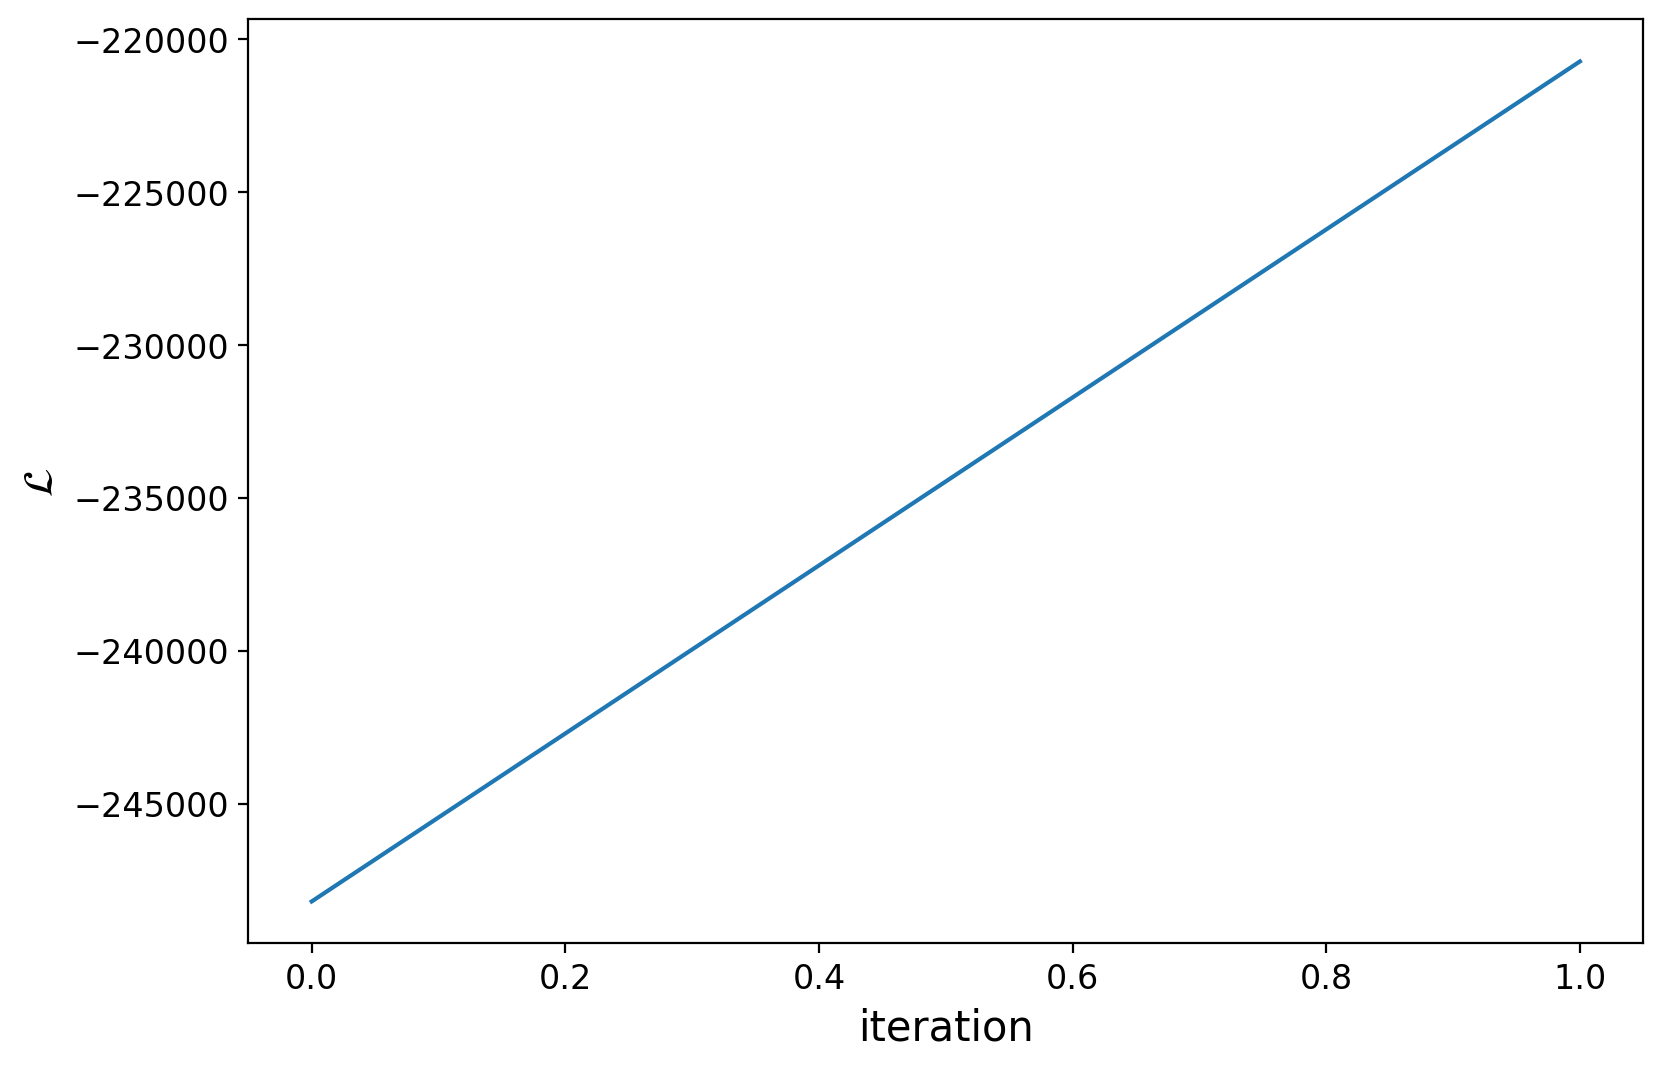

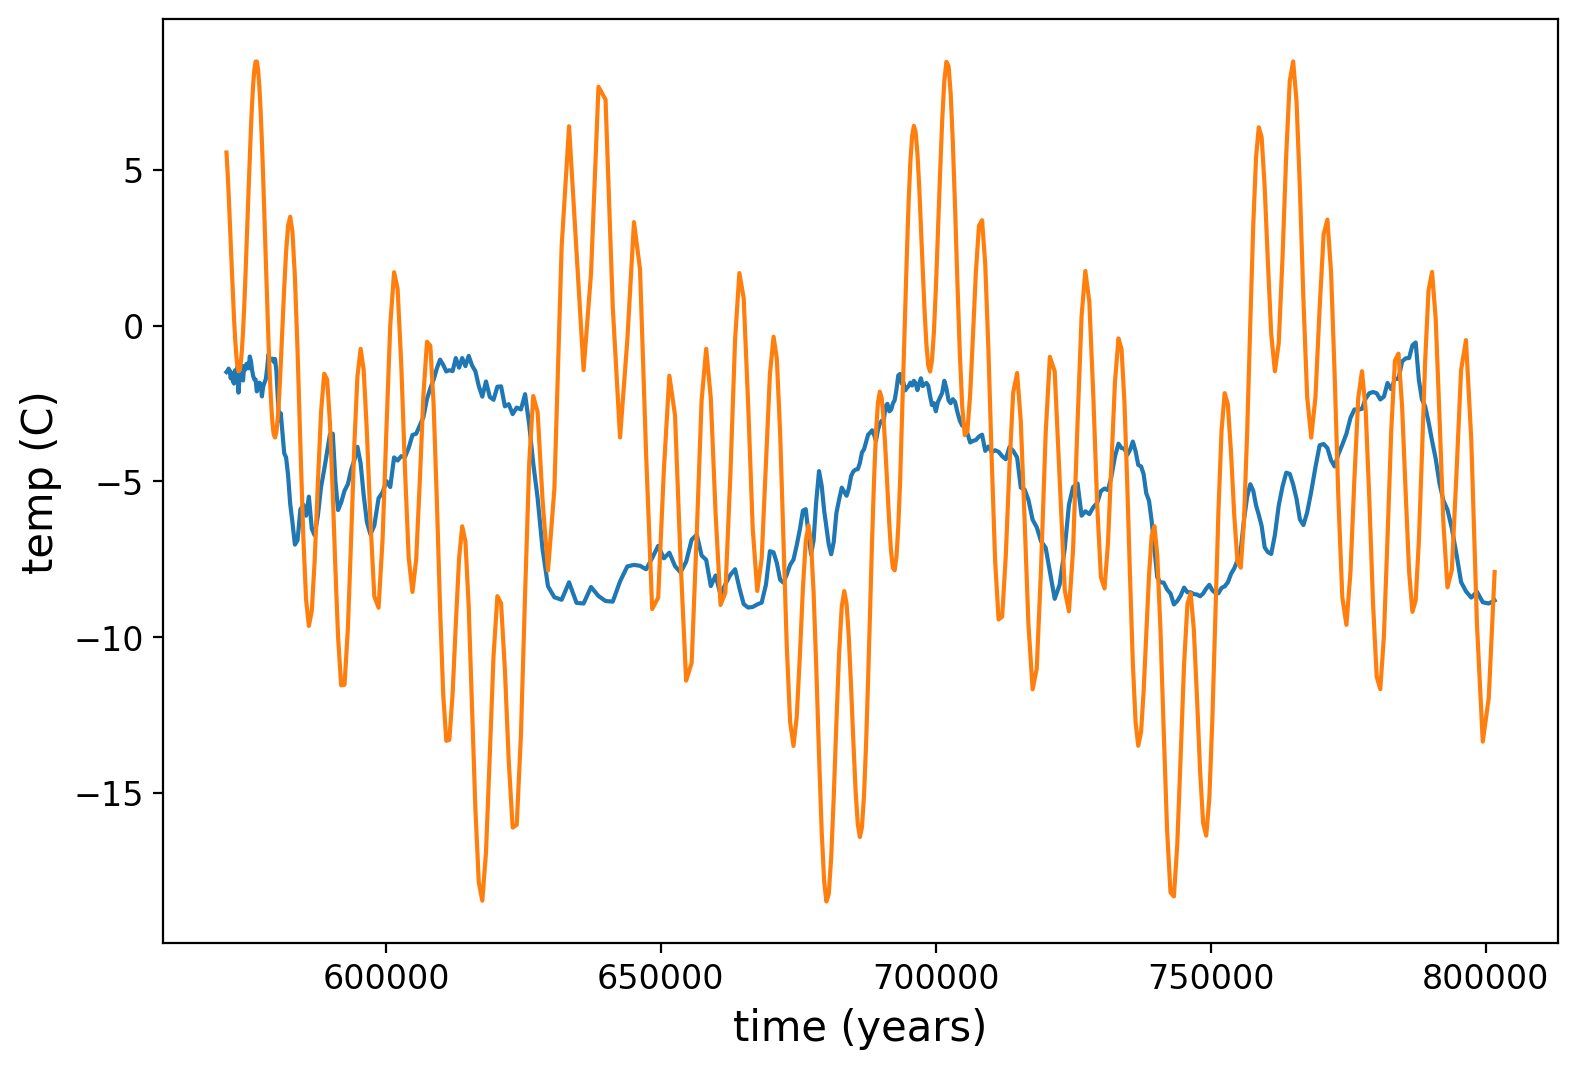

In [24]:
#>>>RUN: L22.3-runcell03

plt.plot(likelihood)
plt.xlabel("iteration")
plt.ylabel("$\mathcal{L}$")
plt.show()

#print(accepted[-1])
plt.plot(times[0:400],amps[0:400])
plt.plot(times[0:400],func(xinit,times)[0:400])
plt.xlabel('time (years)')
plt.ylabel('temp (C)')
plt.show()


Substituting symbol L from STIXNonUnicode
Substituting symbol L from STIXNonUnicode


19


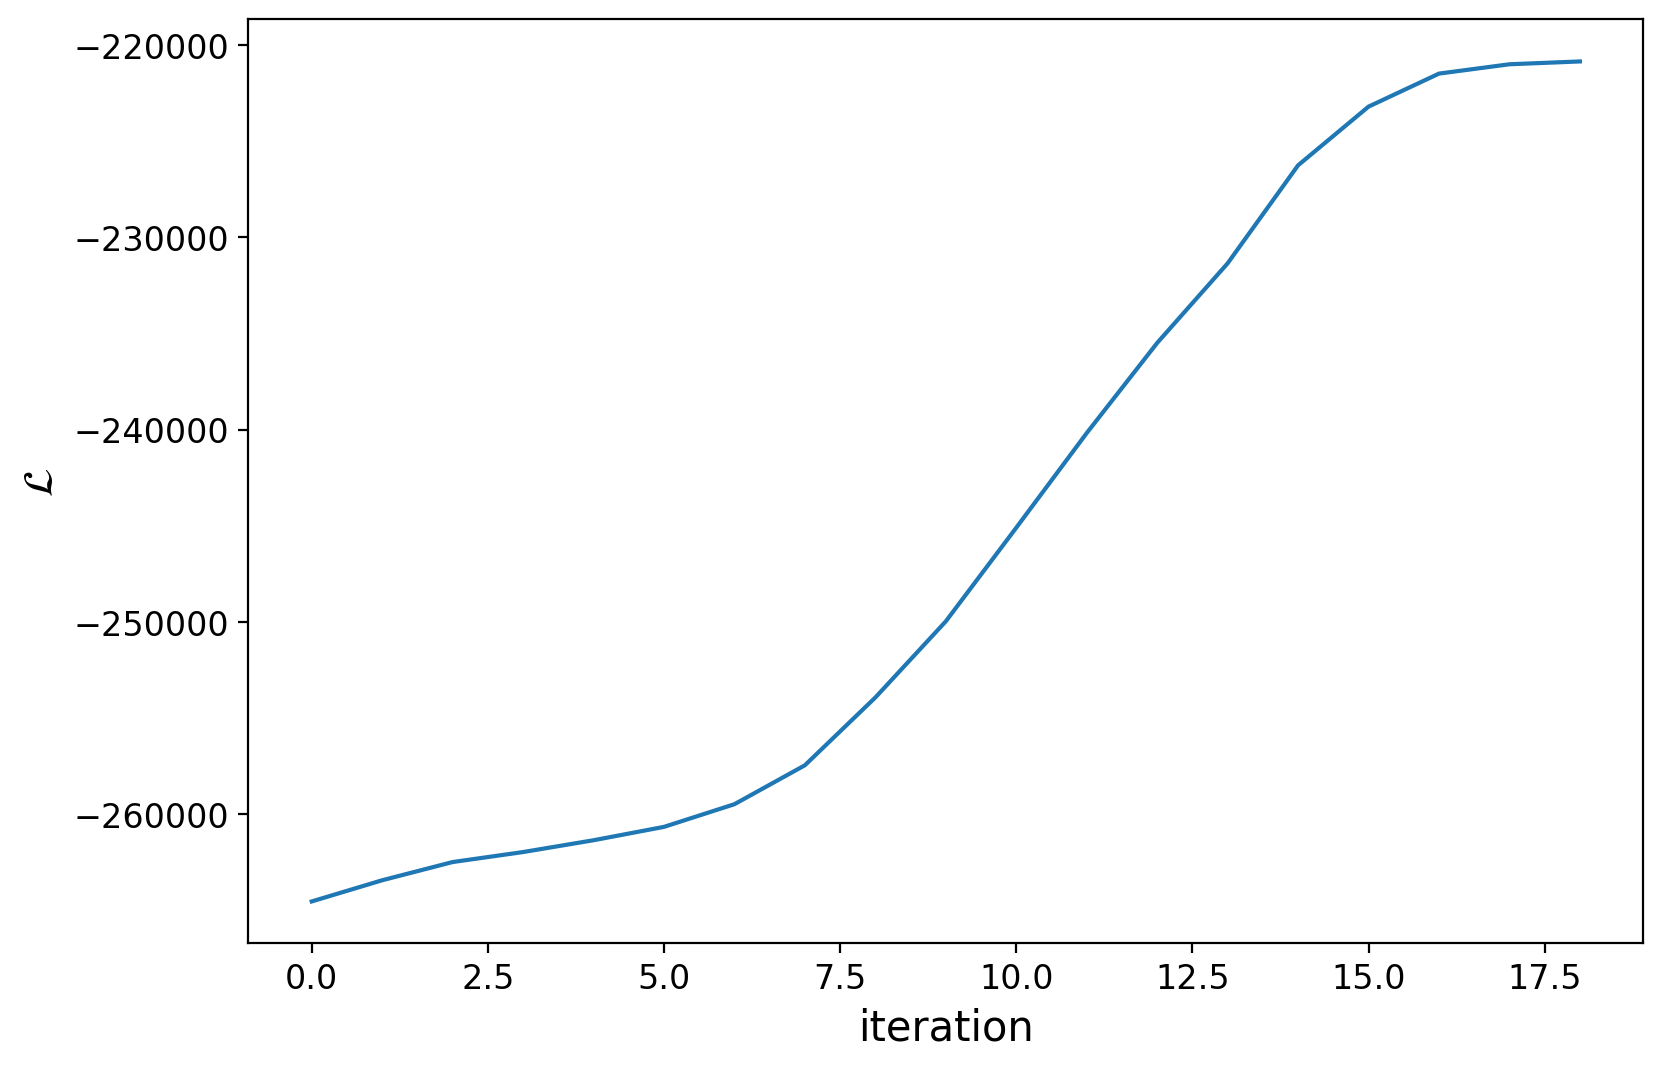

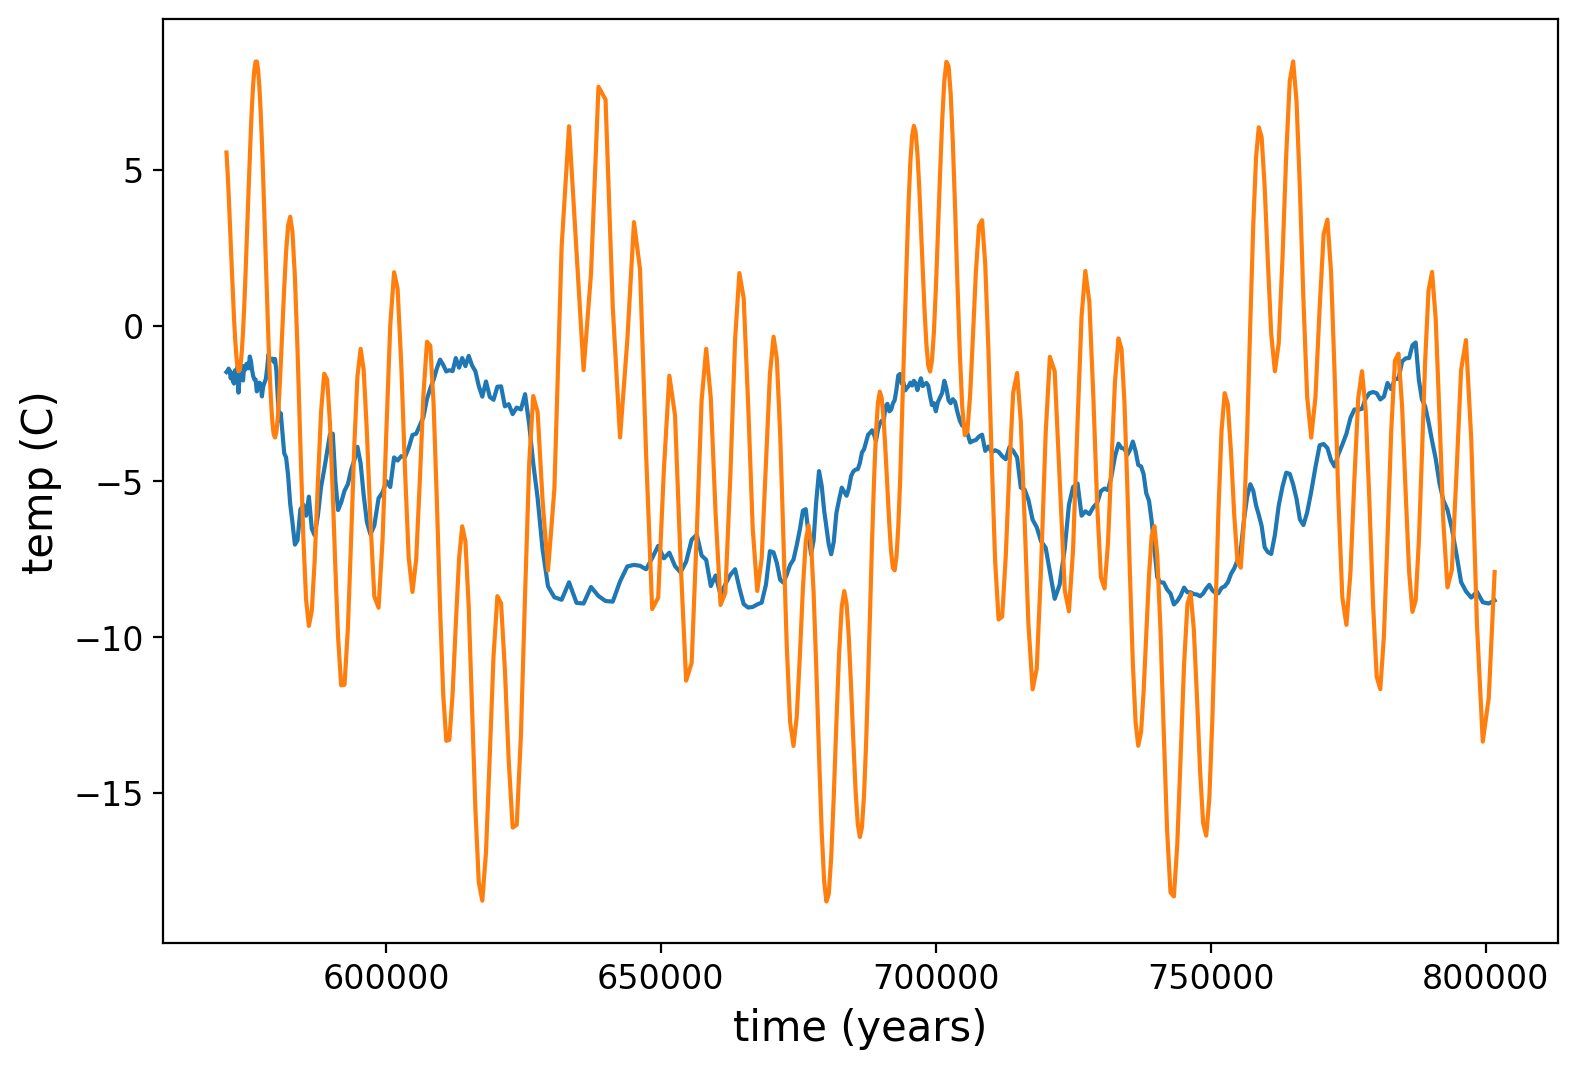

In [25]:
#>>>RUN: L22.3-runcell04

def proposal(x,n=5000):
    return x + np.random.normal(x.shape[0])*1e-3

def prior(like,x):
    #Adjust the likelihood by the prior
    prior=0
    if(x[1] < x[3]) or (x[3] < x[5]) or (x[1] < x[5]):
        prior=1
    return like+np.log(prior)
    
def func(x,t):
    return x[0]*np.sin(x[1]/10000.*t) +  x[2]*np.sin(x[3]/10000*t) +  x[4]*np.sin(x[5]/10000*t) + x[6]

xinit = np.array([5.,1.,5.,2.,-5.,10.,-5.])
accepted, rejected, likelihood = metropolis_hastings(log_like,prior,proposal,acceptance,xinit,data,150000)
print(len(accepted))

plt.plot(likelihood)
plt.xlabel("iteration")
plt.ylabel("$\mathcal{L}$")
plt.show()

plt.plot(times[0:400],amps[0:400])
plt.plot(times[0:400],func(xinit,times)[0:400])
plt.xlabel('time (years)')
plt.ylabel('temp (C)')
plt.show()


In [26]:
#>>>RUN: L22.3-runcell05

def mc_update(walkers, otherwalkers, logp0, Npars, idata, ifunc, a=2.0,iPrint=False):
    Nw = len(walkers)
    No = len(otherwalkers)

    # Calculates random gradient for the affine linear transformation 
    Z = (((a - 1.0) * np.random.rand(Nw) + 1.0) ** 2.0) / a
    if iPrint:
        print("Rand:",Z)
    
    # gets random indices of the othe rwalkers
    rint = np.random.randint(No, size=(Nw,))
    if iPrint:
        print("Rand Indx:",rint)
    
    # Propose new positions from the linear transformation
    qt1 = otherwalkers[rint] - Z[:, np.newaxis] * (otherwalkers[rint] - walkers)
    if iPrint:
        print("Rand Updates:", qt1)
    
    # Calculate the posterior probability of the new position
    logp1 = log_like(qt1, idata,ifunc)
    #logp1 = prior(logp1,qt1)
    
    #Now do the usual Markov update
    #p_diff = (Npars - 1) * np.log(Z) + logp - logp0
    p_diff = logp1 - logp0

    rshape=np.random.rand(p_diff.shape[0])
    # Determine if the new positions are accepted
    accept = p_diff > np.log(np.random.rand(p_diff.shape[0]))
    return qt1, logp1, accept

#now let's solve a 1 parameter problem
#try to predict a gaussian centered at 10
def tmpfunc(x,t):
    out=[]
    for pX in x:
        val=pX*np.ones(t.shape)
        out.append(val)
    out = np.array(out)
    return out

def log_like(x,data,ifunc):
    delta = ifunc(x,data[:,0])-data[:,1]*np.ones(x.shape)
    return -1.*np.sum(delta**2,axis=1)

Nwalkers=10
Npars=1
toydata  = np.random.normal(10,2,(10,2))
allWalks = np.array([1 + np.random.randn(Npars) for i in range(Nwalkers)])
logp0    = log_like(allWalks, toydata,tmpfunc)

print("Inital Walks:\n",allWalks,"\nInitial p-vals:\n",logp0)
print("Update first 5:")
newWalks, newlogp, accept = mc_update(allWalks[0:5], allWalks[5:10], logp0[0:5], Npars, toydata, tmpfunc,iPrint=True)
print("Updated Walks:\n",newWalks,"\nUpdated p-vals:\n",newlogp)

print("Update second 5:")
newWalks, newlogp, accept = mc_update(allWalks[5:10], allWalks[0:5], logp0[5:10], Npars, toydata, tmpfunc)
print("Updated Walks:\n",newWalks,"\nUpdated p-vals:\n",newlogp)


Inital Walks:
 [[ 1.12822003]
 [ 1.95774327]
 [ 1.6607573 ]
 [-0.16594993]
 [-0.315056  ]
 [-1.34563295]
 [ 0.93347828]
 [ 0.71874881]
 [-0.39142496]
 [ 0.27798538]] 
Initial p-vals:
 [ -812.32897275  -676.34631353  -723.44927357 -1051.96476101
 -1081.72609218 -1299.58512569  -846.24740484  -884.52638008
 -1097.14140632  -965.98871063]
Update first 5:
Rand: [1.10625179 1.65588882 1.83441377 0.74391763 1.33000989]
Rand Indx: [1 3 2 1 3]
Rand Updates: [[ 1.14891169]
 [ 3.49853646]
 [ 2.44678216]
 [ 0.11559425]
 [-0.28985349]]
Updated Walks:
 [[ 1.14891169]
 [ 3.49853646]
 [ 2.44678216]
 [ 0.11559425]
 [-0.28985349]] 
Updated p-vals:
 [ -808.76965544  -460.28777635  -602.62708969  -996.98146741
 -1076.66448463]
Update second 5:
Updated Walks:
 [[-3.76349126]
 [ 0.75841747]
 [ 0.89254291]
 [-0.24167431]
 [ 0.86081723]] 
Updated p-vals:
 [-1894.08707984  -877.38536114  -853.47364902 -1067.02365772
  -859.0971751 ]


In [27]:
#>>>RUN: L22.3-runcell06

def proposal(q, logp, data, Nwalk, Npars, iFunc):
    half = int(Nwalk / 2)
    first, second = slice(half), slice(half, Nwalk)

    # Alternate slices of the data fixing and updating
    for S0, S1 in [(first, second), (second, first)]:
        # Use stretch move to calculate the proposal
        q_new, logp_new, acc = mc_update(q[S0], q[S1], logp[S0], Npars, data, iFunc)

        # Add accepted values into the chains
        if np.any(acc):
            logp[S0][acc] = logp_new[acc]
            q[S0][acc]    = q_new[acc]

    return q, logp

#def metropolis_hastings(iLikelihood,iPrior,iProposal,iAcceptance,xinit,data,niterations):
def metropolis_hastings_ensemble(xinit, logpinit, data, Npars, Nwalk, Nstep,iFunc):
    samples = np.ndarray((Nwalk, Nstep, Npars))
    samples[:, 0, :] = np.array(xinit)

    lnprob = np.ndarray((Nwalk, Nstep))
    lnprob[:, 0] = np.array(logpinit)

    # Iterate over the Markov steps
    for i in range(1, Nstep):
        if (i % 500)==0:
            print("Steps:",i)
        q, p = proposal(samples[:,i-1,:], lnprob[:,i-1], data, Nwalk, Npars, iFunc)
        samples[:,i,:] = np.array(q)
        lnprob[:,i] = np.array(p)
    
    return samples, lnprob

# Set up MCMC parameters
Npars = xinit.shape[0]
Nwalk = 100
Nstep = 2500 #larger Nstep used in related video

def log_like(x,data,iFunc):
    return -1.*np.sum((iFunc(x,data[:,0])-data[:,1])**2,axis=1)

def func(x,t):
    out=[]
    for pX in x:
        val=pX[0]*np.sin(pX[1]/10000.*t) +  pX[2]*np.sin(pX[3]/10000*t) +  pX[4]*np.sin(pX[5]/10000*t) + pX[6]
        out.append(val)
    out = np.array(out)
    return out

q0    = np.array([xinit + 1.0e-4*np.random.randn(Npars) for i in range(Nwalk)])
logp0 = log_like(q0, data, func)
accepted, likelihood = metropolis_hastings_ensemble(q0,logp0,data,Npars,Nwalk,Nstep,func)

Steps: 500
Steps: 1000
Steps: 1500
Steps: 2000


Substituting symbol L from STIXNonUnicode
Substituting symbol L from STIXNonUnicode


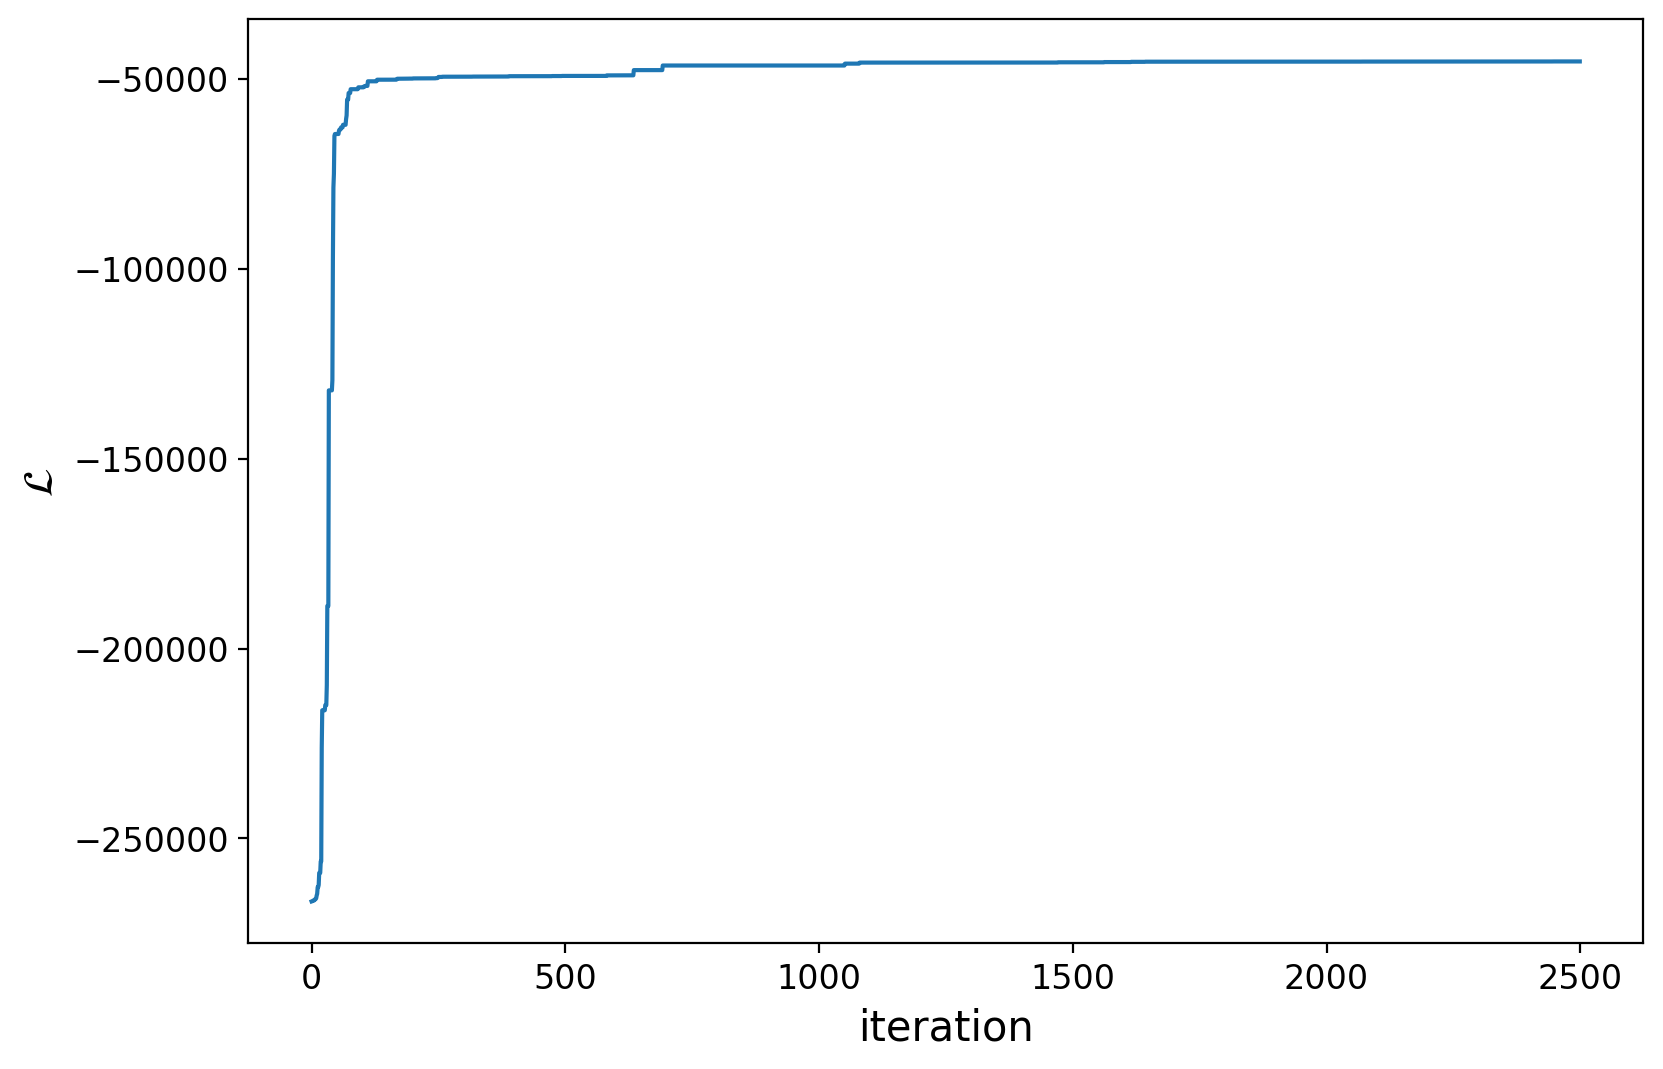

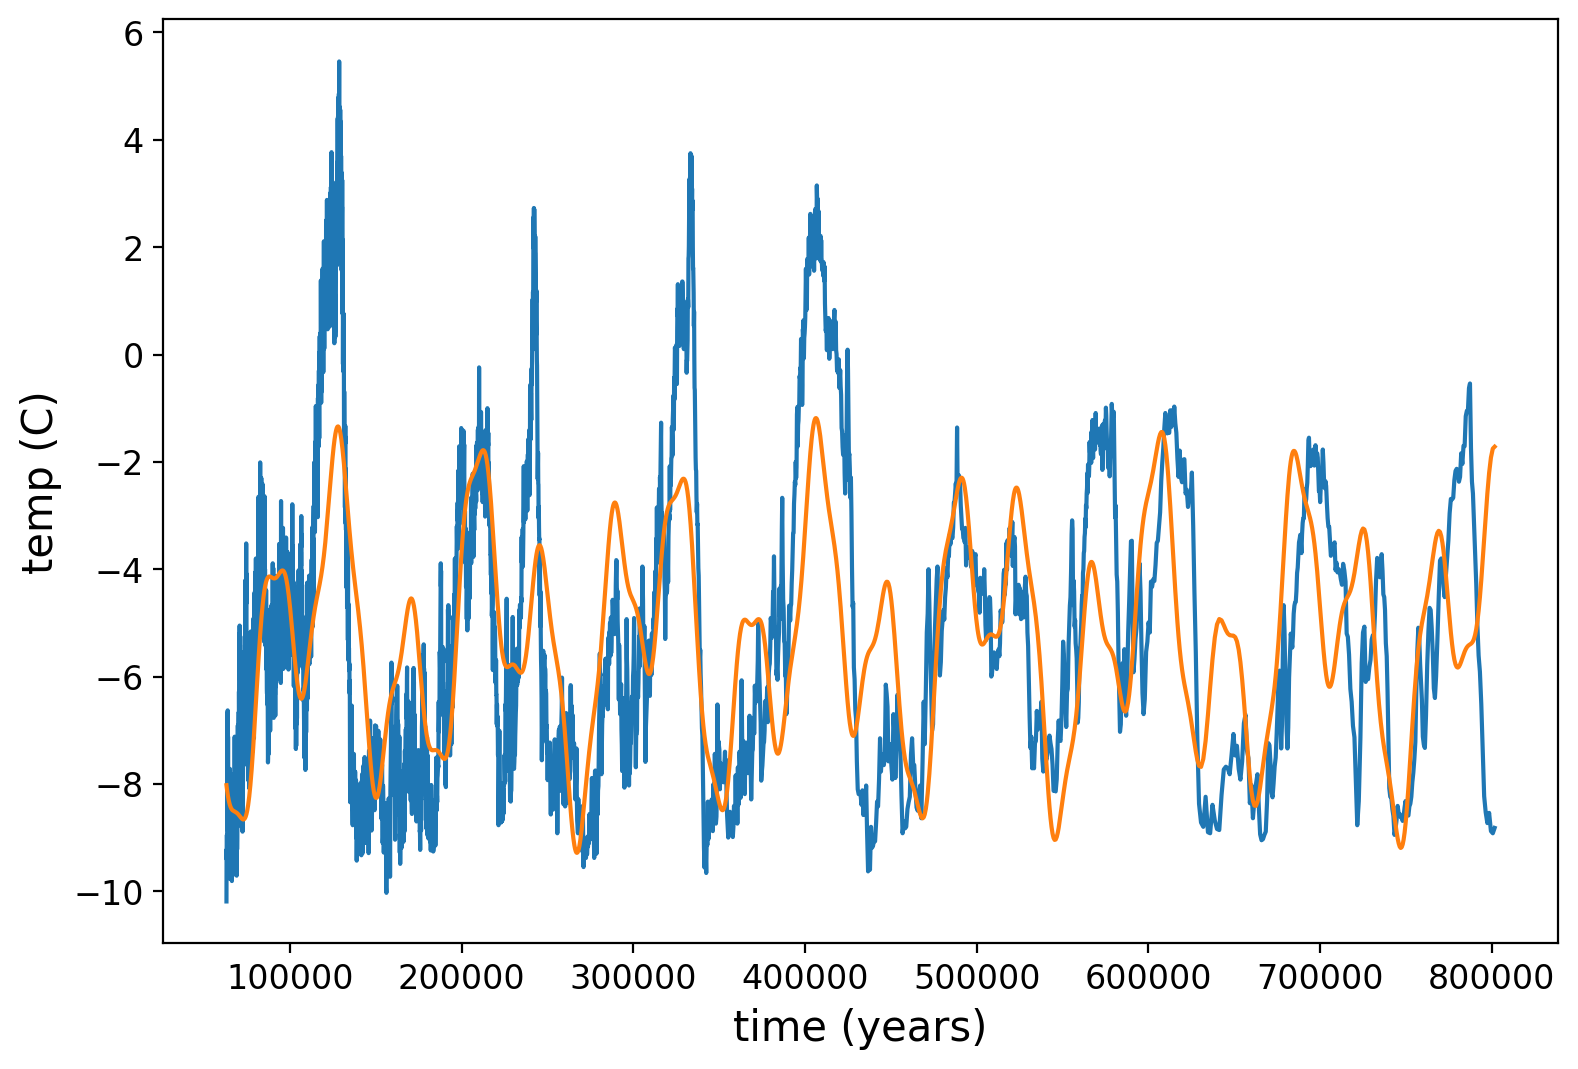

In [28]:
#>>>RUN: L22.3-runcell07

lproj = np.max(likelihood,axis=0)
plt.plot(lproj)
plt.xlabel("iteration")
plt.ylabel("$\mathcal{L}$")
plt.show()

maxval=np.argmax(lproj)
maxy=np.argmax(likelihood[:,maxval])
bestpars=np.array([accepted[maxy,maxval]])
output=func(bestpars,times)

plt.plot(times[0:4000],amps[0:4000])
plt.plot(times[0:4000],output.flatten()[0:4000])
plt.xlabel('time (years)')
plt.ylabel('temp (C)')
plt.show()


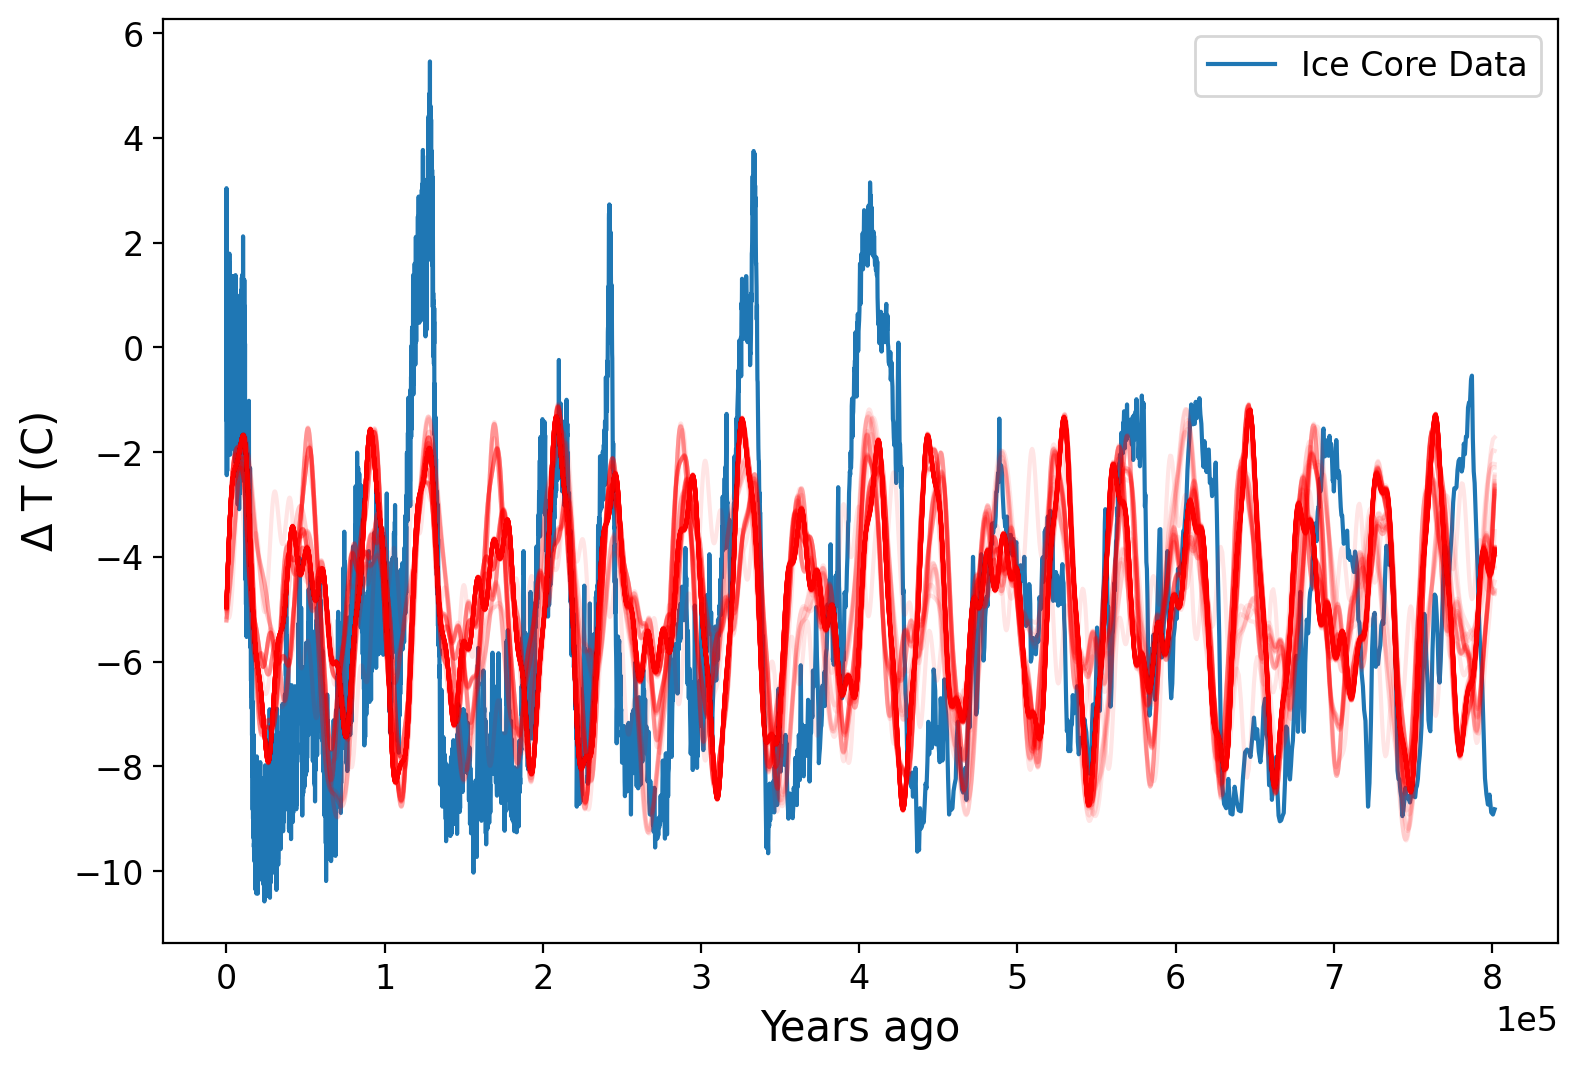

In [29]:
#>>>RUN: L22.3-runcell08

def plotter(accepted,times,amps):
    plt.ion()
    plt.plot(times,amps,label='Ice Core Data')
    output=func(accepted[:,-1],times)
    for i0 in range(100):
        plt.plot(times, output[i0], color="r", alpha=0.1)
    plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
    plt.xlabel('Years ago')
    plt.ylabel(r'$\Delta$ T (C)')
    plt.legend()
    plt.show()
    
plotter(accepted,times,amps)

(49900, 7)


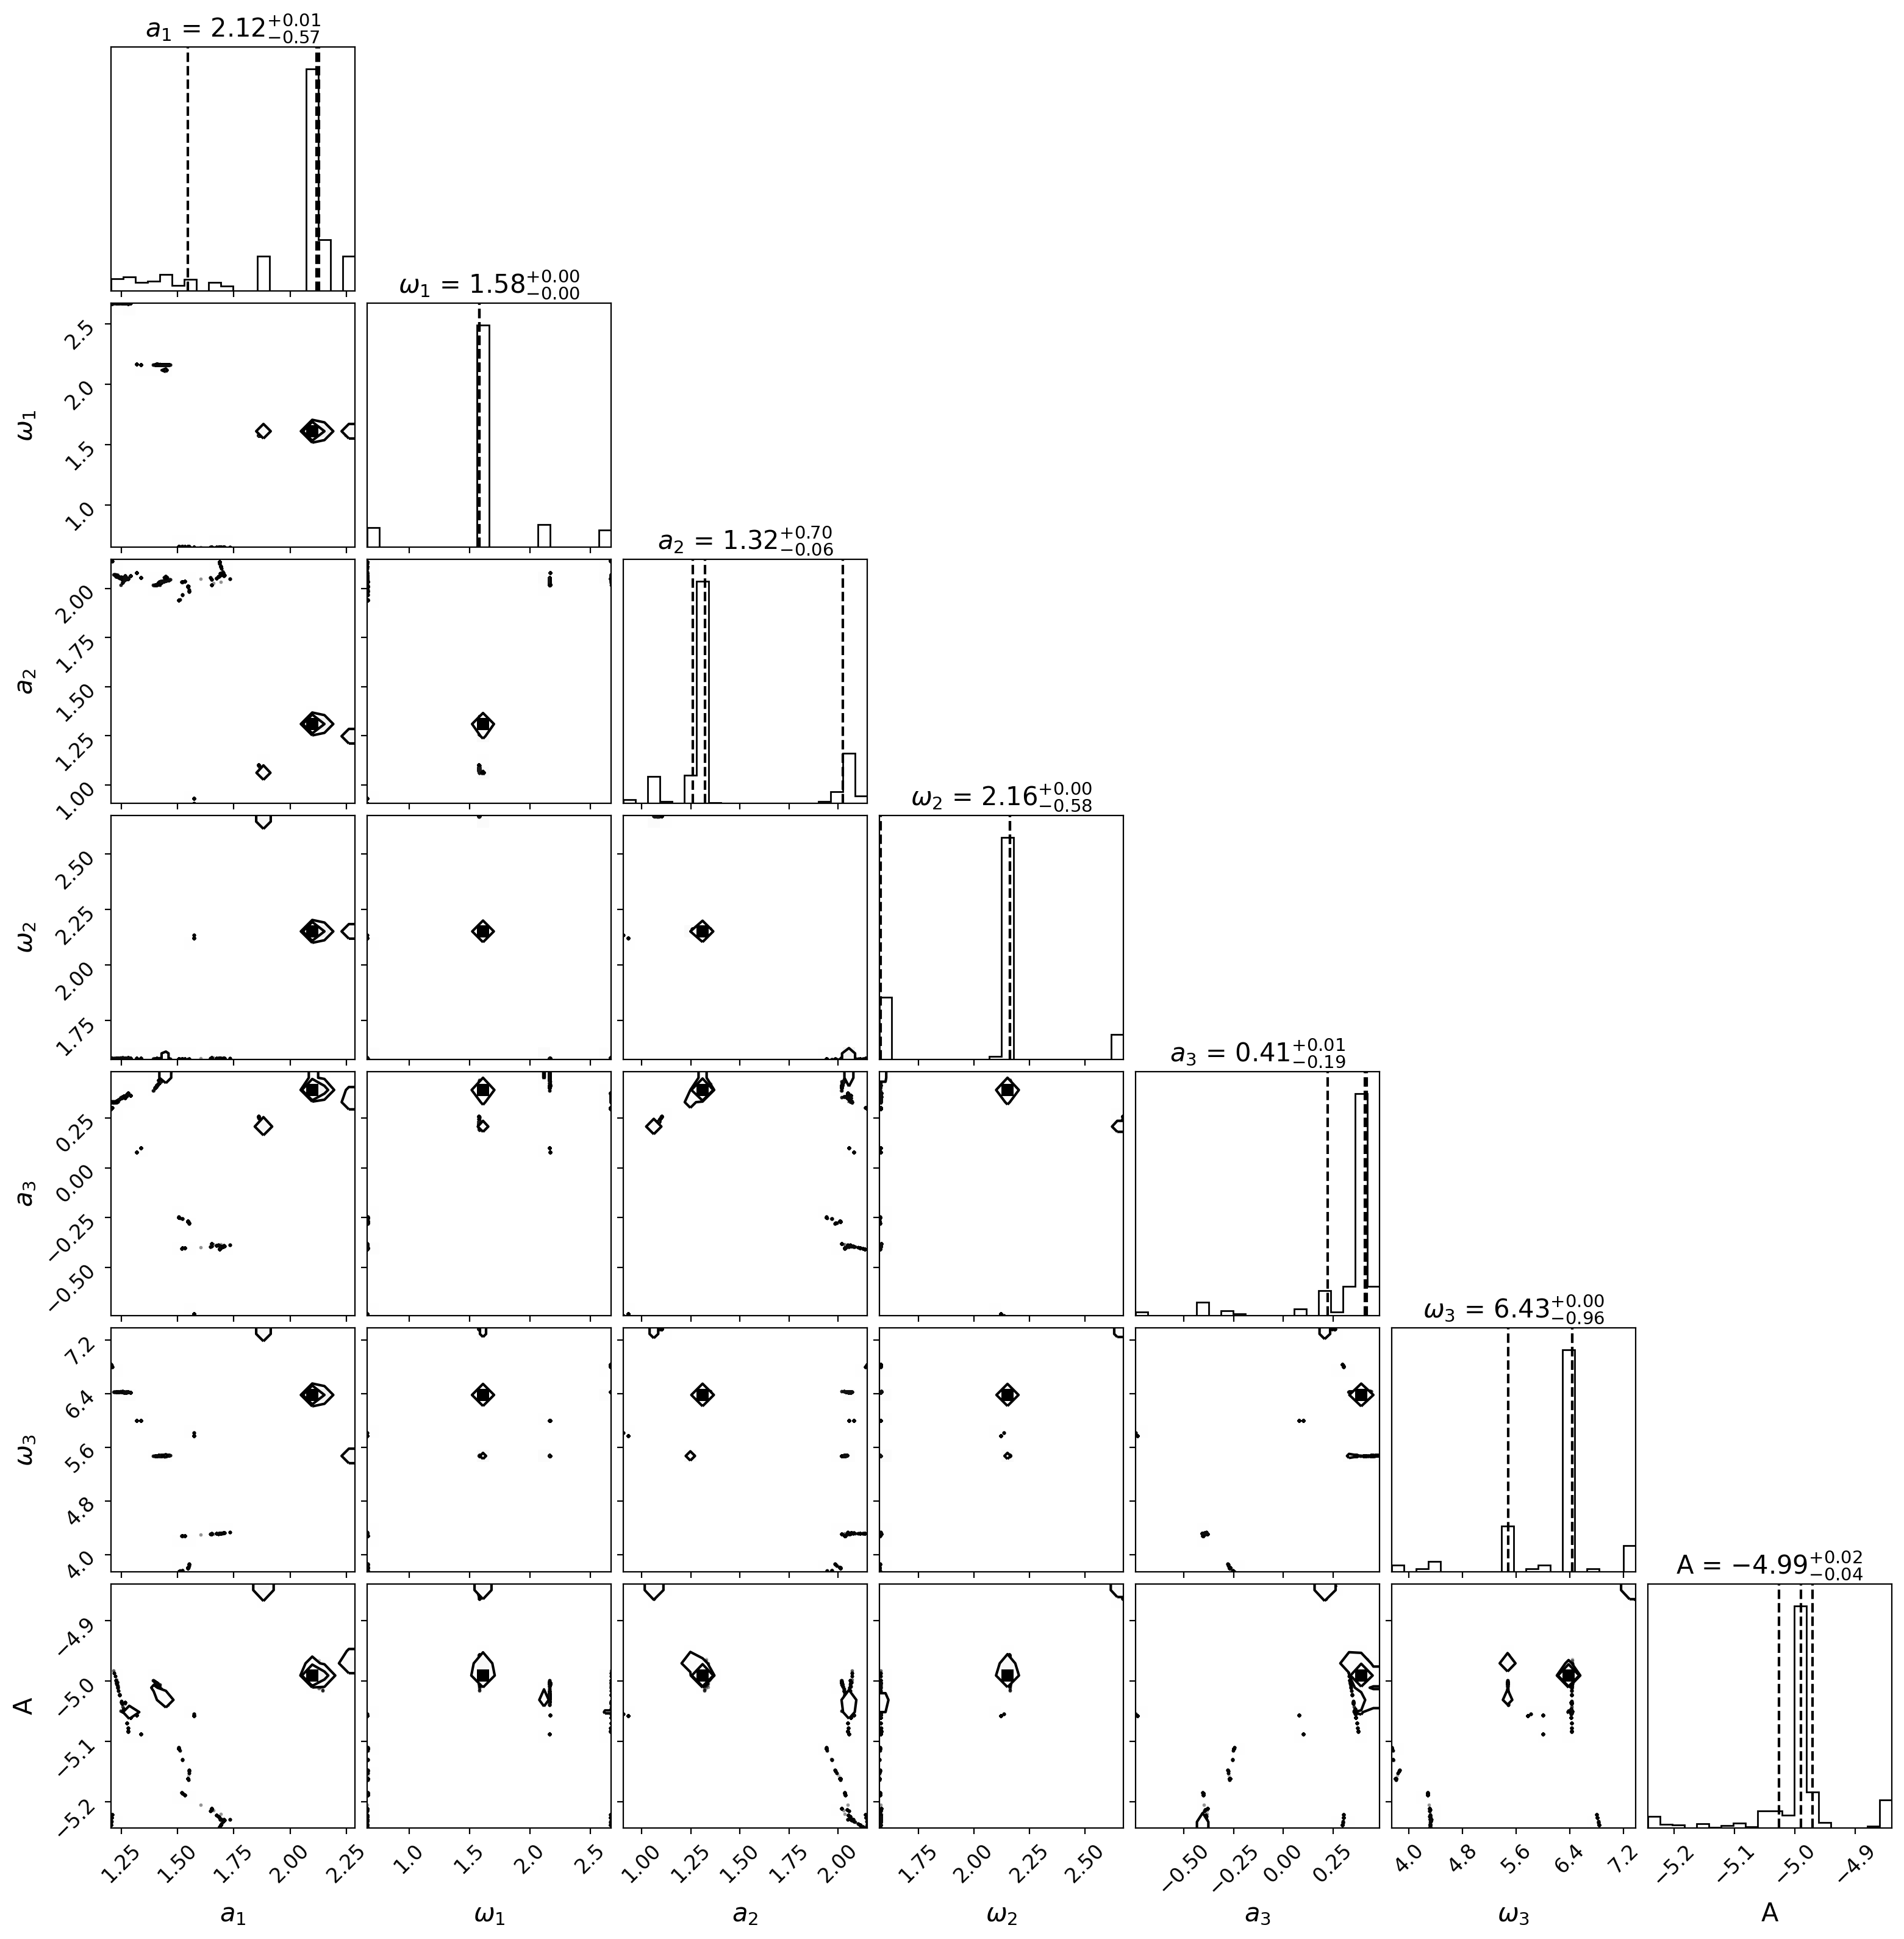

In [30]:
#>>>RUN: L22.3-runcell09

import corner 
labels = ['$a_{1}$','$\omega_{1}$','$a_{2}$','$\omega_{2}$','$a_{3}$','$\omega_{3}$','A']
samples=accepted[:,-500:-1]
samples=np.reshape(samples,(samples.shape[0]*samples.shape[1],samples.shape[2]))
print(samples.shape)
fig = corner.corner(samples,show_titles=True,labels=labels,plot_datapoints=True,quantiles=[0.16, 0.5, 0.84])


In [31]:
#>>>RUN: L22.3-runcell10

def prior(like,x):
    #Adjust the likelihood by the prior
    prior=np.ones(x.shape[0])
    idx = np.where((x[:,1] < x[:,3]) | (x[:,3] < x[:,5]) | (x[:,1] < x[:,5]))
    like[idx]+=np.log(prior[idx])
    return like

def mc_update(walkers, otherwalkers, logp0, Npars, idata, ifunc, a=2.0,iPrint=False):
    Nw = len(walkers)
    No = len(otherwalkers)

    # Calculates random gradient for the affine linear transformation 
    Z = (((a - 1.0) * np.random.rand(Nw) + 1.0) ** 2.0) / a
    rint = np.random.randint(No, size=(Nw,))
    qt1 = otherwalkers[rint] - Z[:, np.newaxis] * (otherwalkers[rint] - walkers)    
    # Calculate the posterior probability of the new position
    logp1 = log_like(qt1, idata,ifunc)
    logp1 = prior(logp1,qt1)
    
    #Now do the usual Markov update
    #p_diff = (Npars - 1) * np.log(Z) + logp - logp0
    p_diff = logp1 - logp0

    rshape=np.random.rand(p_diff.shape[0])
    accept = p_diff > np.log(np.random.rand(p_diff.shape[0]))
    return qt1, logp1, accept

Nwalk = 100
Nstep = 2500 #larger Nstep used in related video
q0    = np.array([xinit + 1.0e-4*np.random.randn(Npars) for i in range(Nwalk)])
logp0 = log_like(q0, data, func)
accepted, likelihood = metropolis_hastings_ensemble(q0,logp0,data,Npars,Nwalk,Nstep,func)

Steps: 500
Steps: 1000
Steps: 1500
Steps: 2000


(49900, 7)


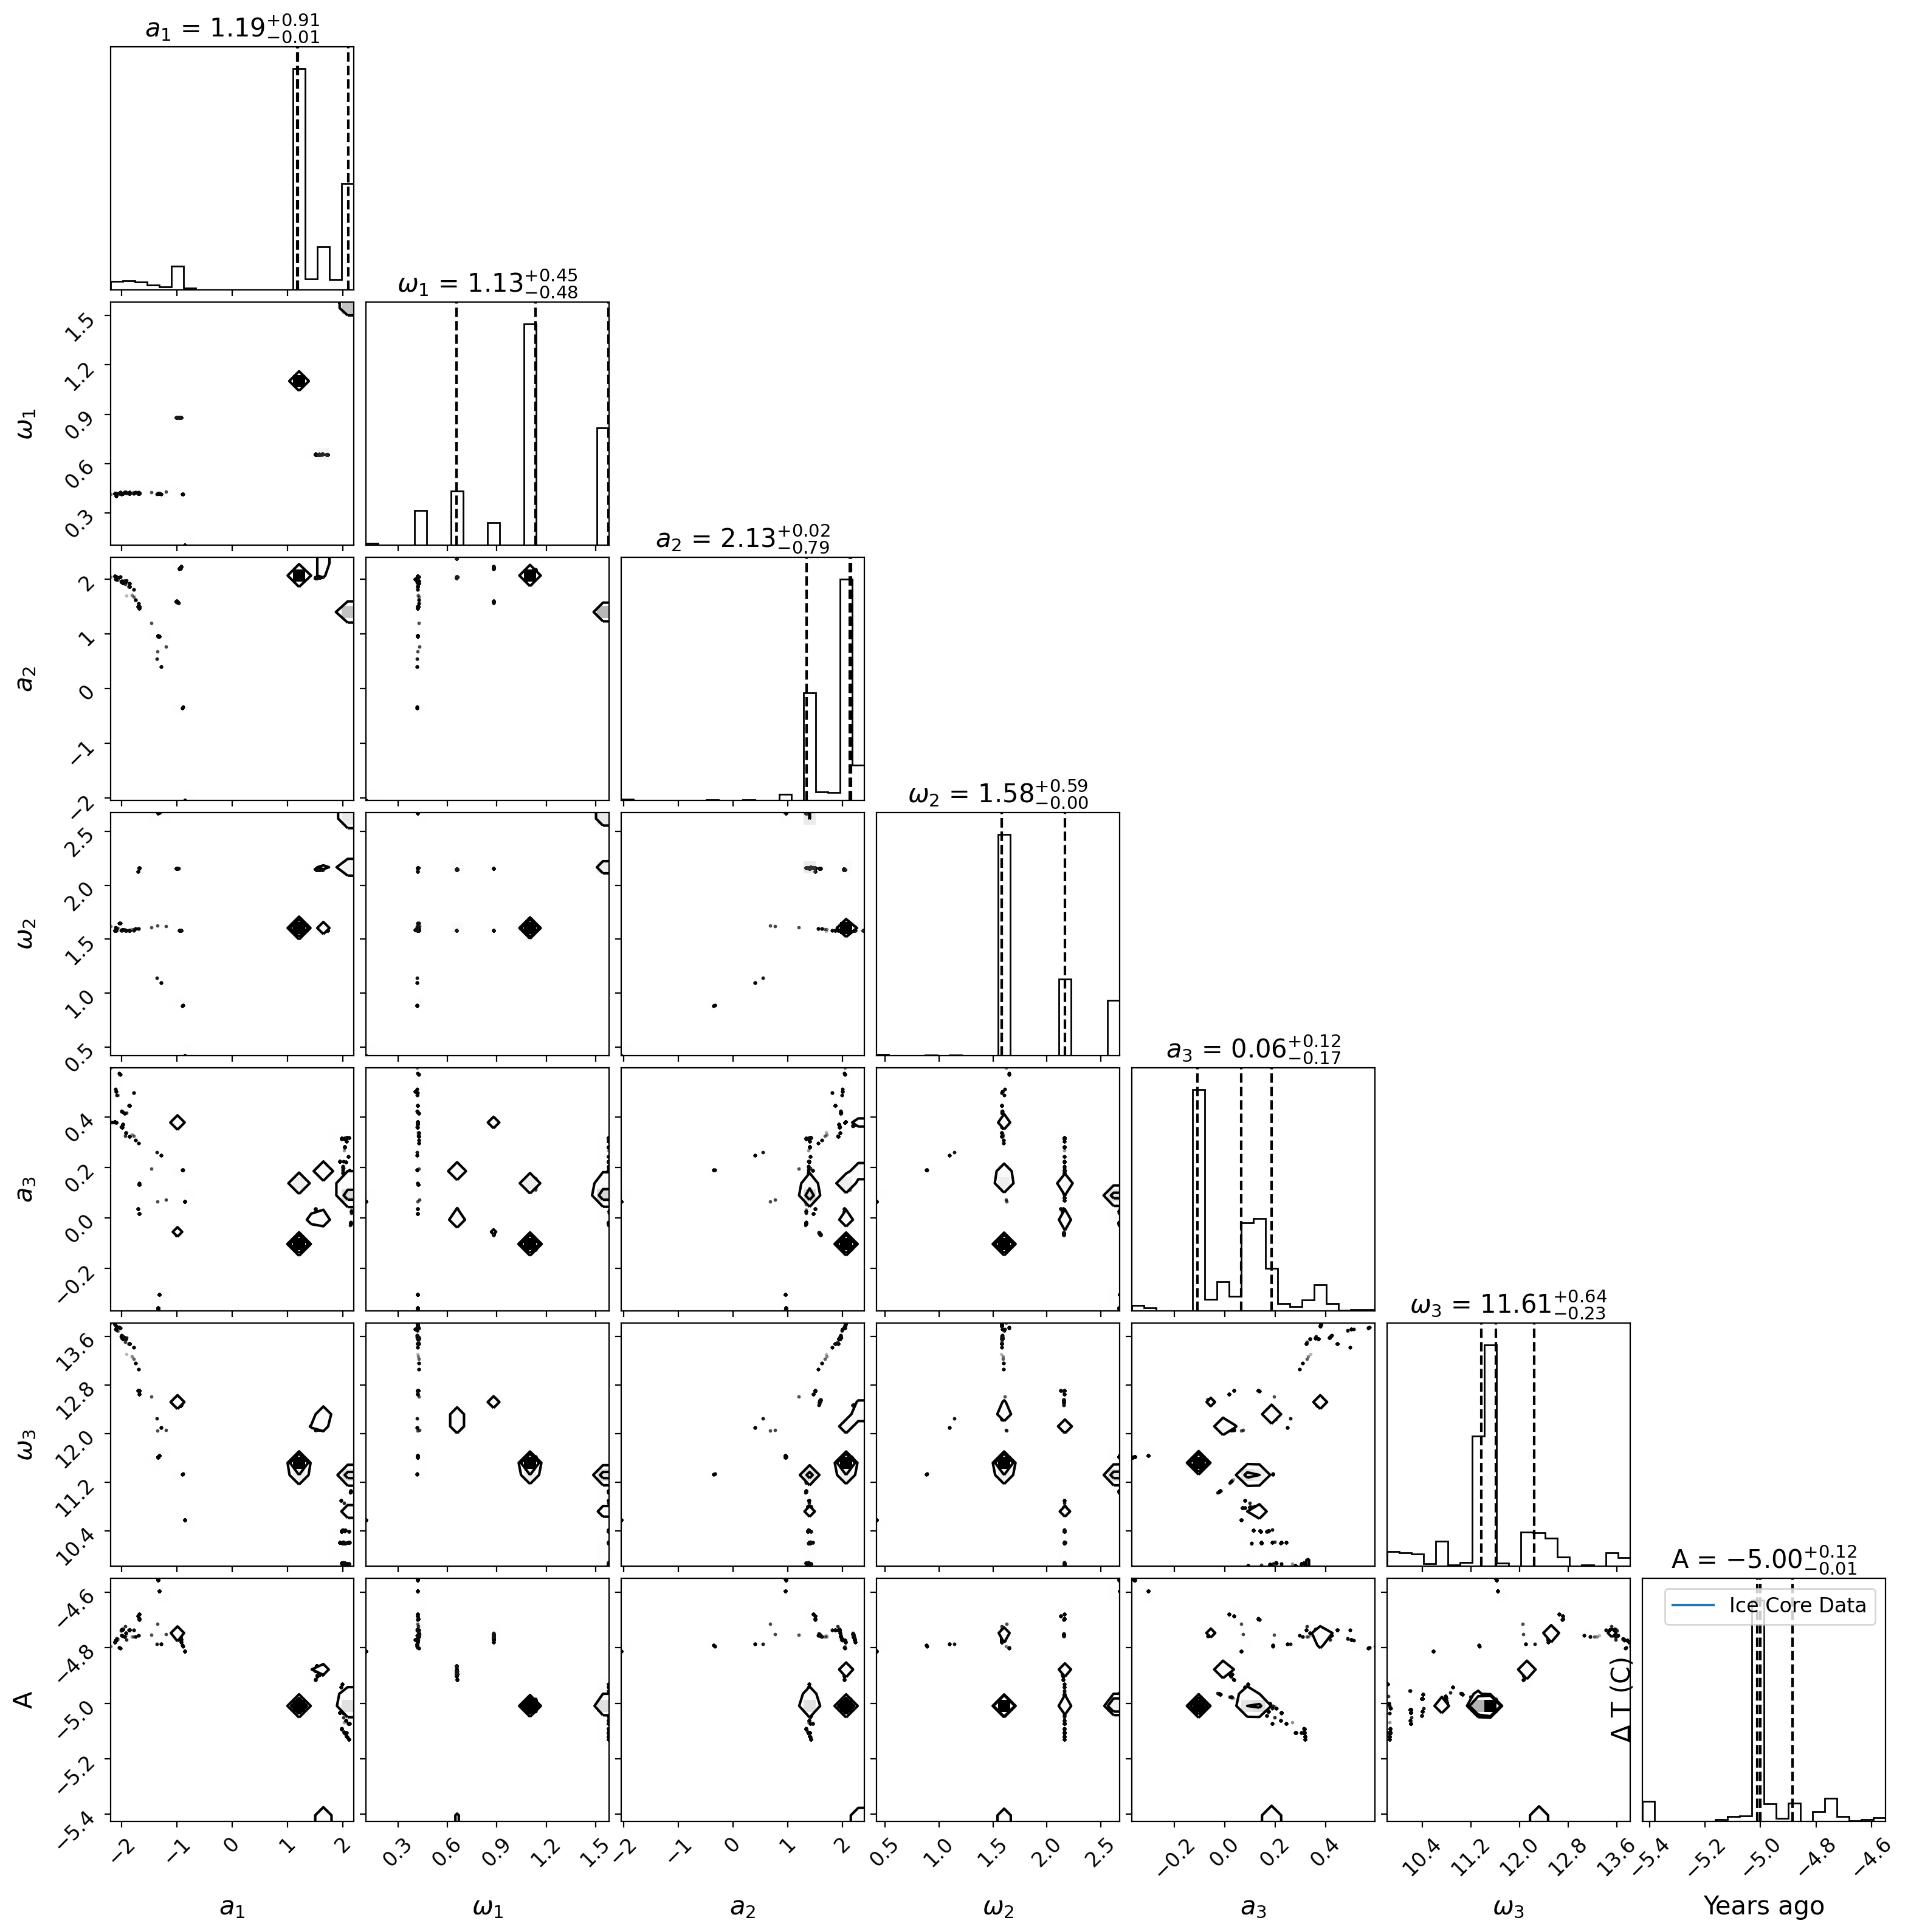

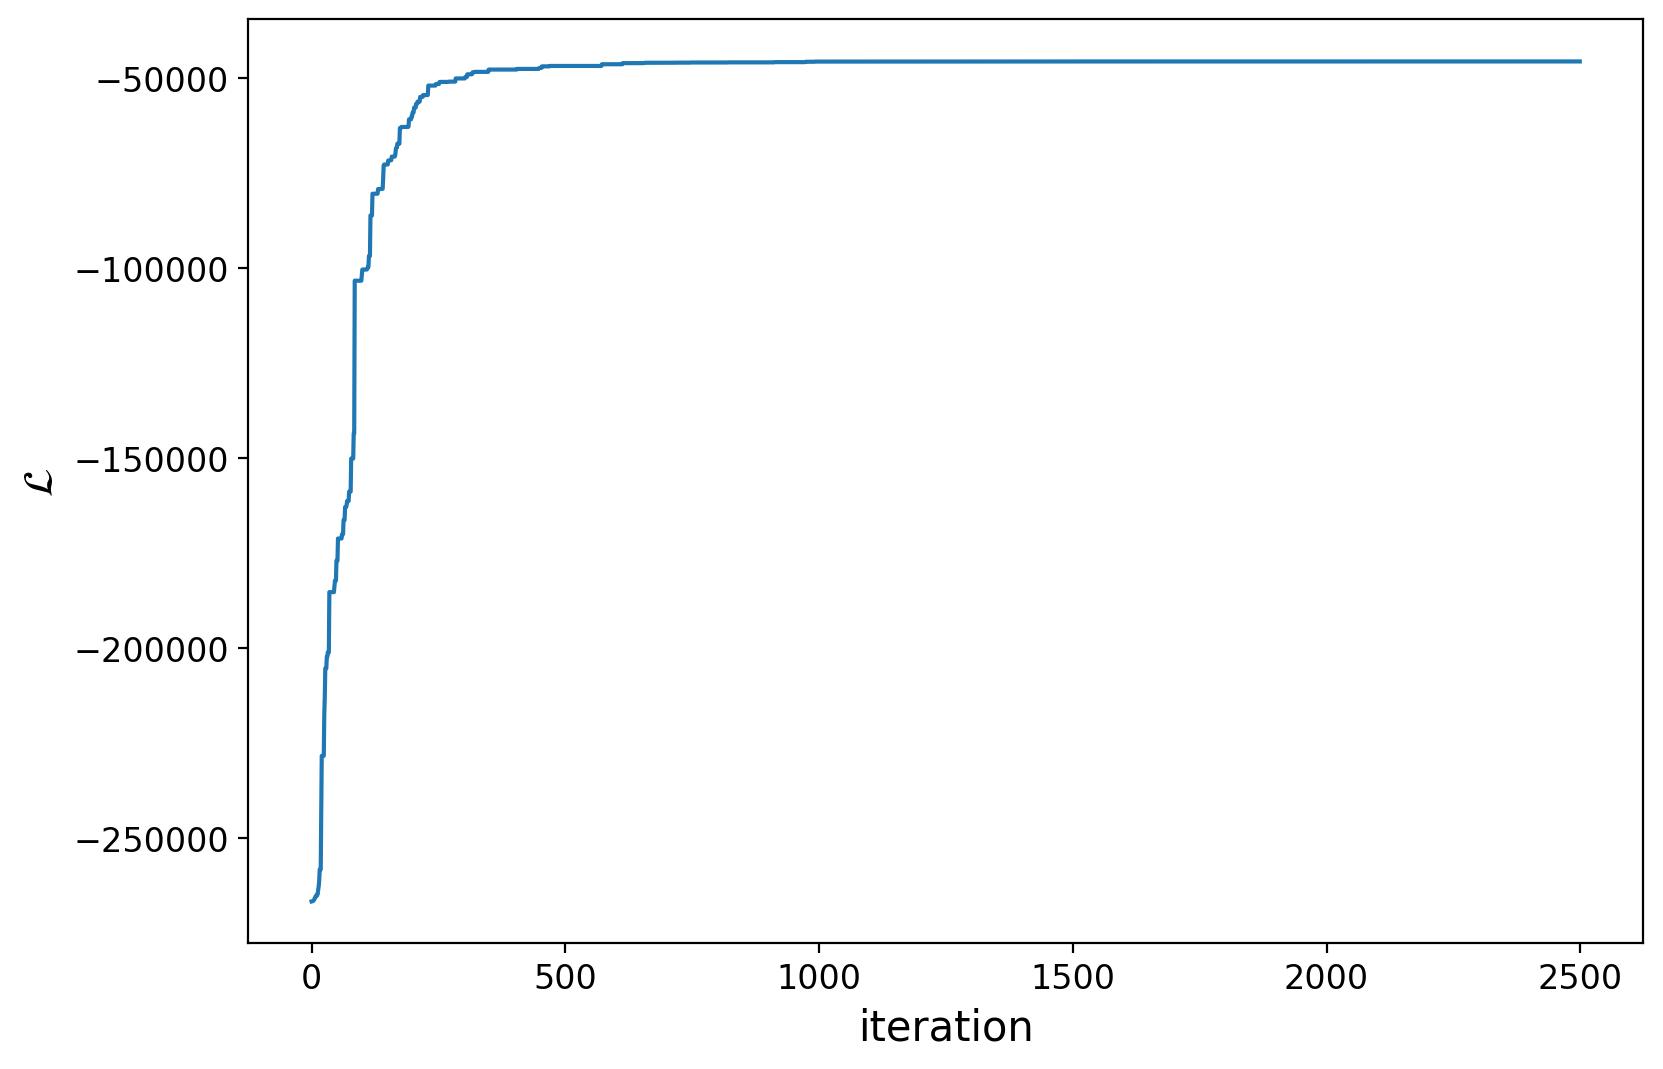

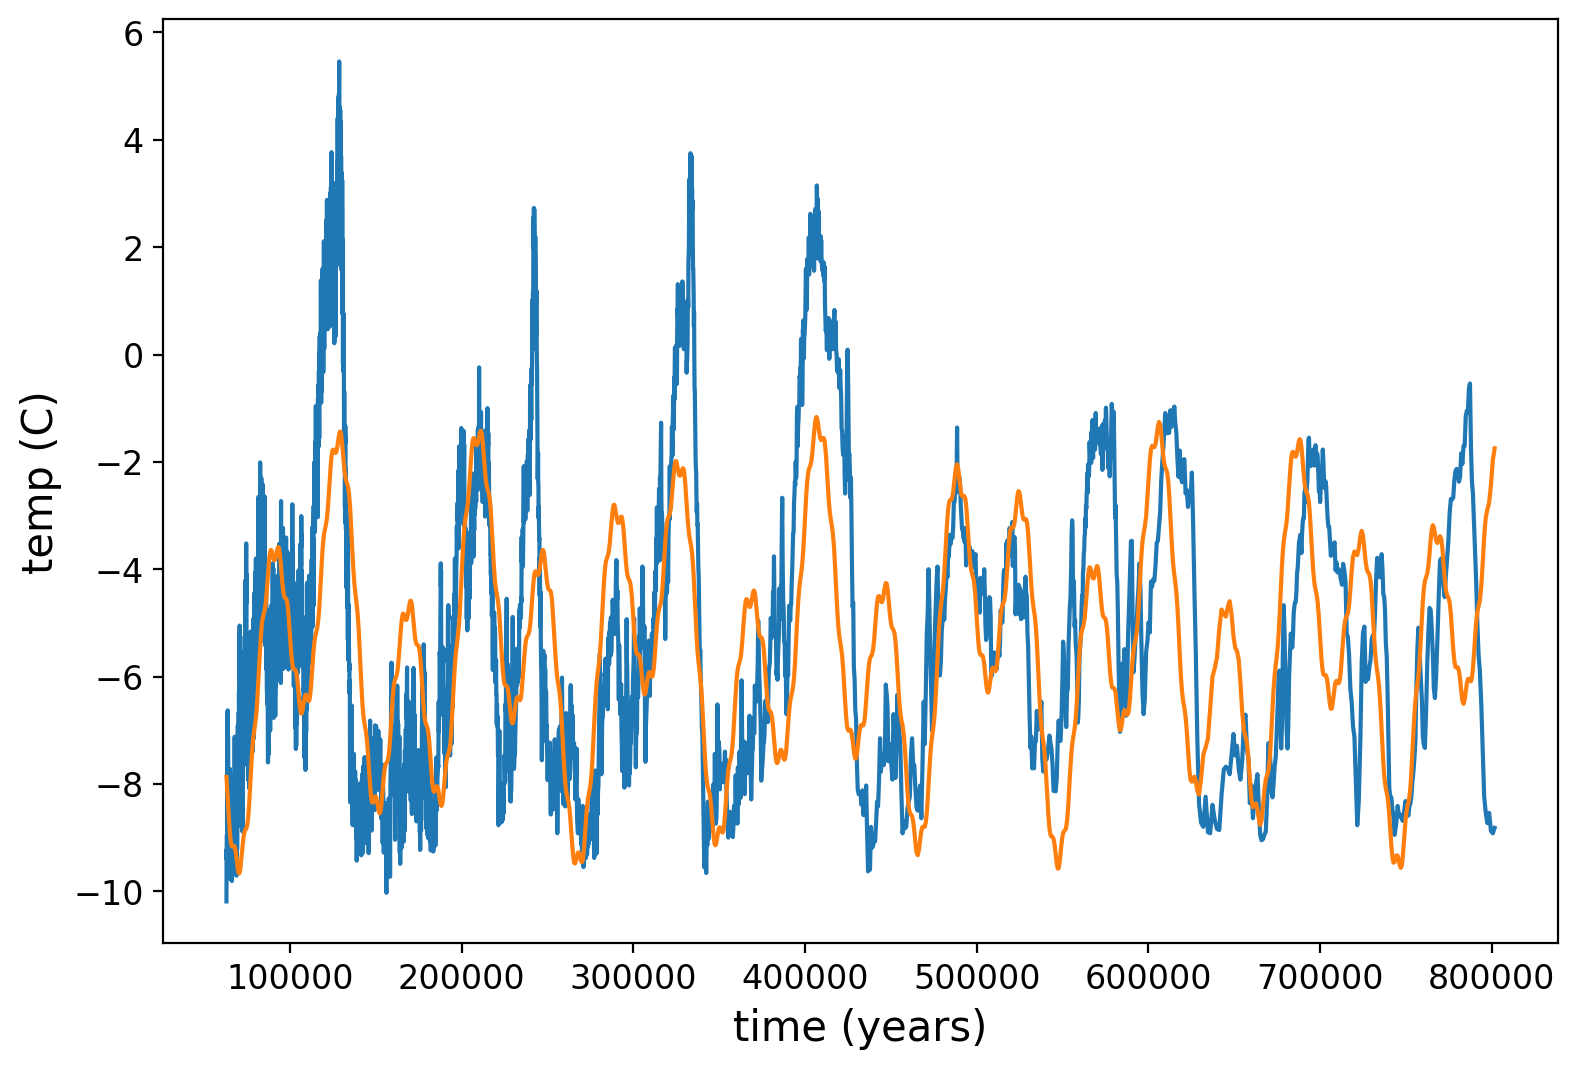

In [32]:
#>>>RUN: L22.3-runcell11

import corner 
labels = ['$a_{1}$','$\omega_{1}$','$a_{2}$','$\omega_{2}$','$a_{3}$','$\omega_{3}$','A']
samples=accepted[:,-500:-1]
samples=np.reshape(samples,(samples.shape[0]*samples.shape[1],samples.shape[2]))
print(samples.shape)
fig = corner.corner(samples,show_titles=True,labels=labels,plot_datapoints=True,quantiles=[0.16, 0.5, 0.84])

plotter(accepted,times,amps)

lproj = np.max(likelihood,axis=0)
plt.plot(lproj)
plt.xlabel("iteration")
plt.ylabel("$\mathcal{L}$")
plt.show()

maxval=np.argmax(lproj)
maxy=np.argmax(likelihood[:,maxval])
bestpars=np.array([accepted[maxy,maxval]])
output=func(bestpars,times)

plt.plot(times[0:4000],amps[0:4000])
plt.plot(times[0:4000],output.flatten()[0:4000])
plt.xlabel('time (years)')
plt.ylabel('temp (C)')
plt.show()

[-8.82 -8.92 -8.88 ...  3.04  1.84  0.88] [8.016620e+05 8.005890e+05 7.995010e+05 ... 5.505624e+01 4.681203e+01
 3.837379e+01]
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 145
    # data points      = 5788
    # variables        = 7
    chi-square         = 49757.8495
    reduced chi-square = 8.60713536
    Akaike info crit   = 12466.1957
    Bayesian info crit = 12512.8405
    R-squared          = 0.27678620
[[Variables]]
    p0:  2.11981589 +/- 0.05577432 (2.63%) (init = 2)
    p1:  1.57976464 +/- 9.4686e-04 (0.06%) (init = 1.6)
    p2:  1.32004538 +/- 0.05564302 (4.22%) (init = 1.76)
    p3:  2.16317137 +/- 0.00152045 (0.07%) (init = 2.16)
    p4: -0.06279571 +/- 0.05463433 (87.00%) (init = -0.1)
    p5:  10.5920424 +/- 0.03206288 (0.30%) (init = 10.6)
    p6: -4.97763577 +/- 0.03949568 (0.79%) (init = -5)
[[Correlations]] (unreported correlations are < 0.100)
    C(p0, p6) = -0.1793
    C(p2, p6) = -0.1014


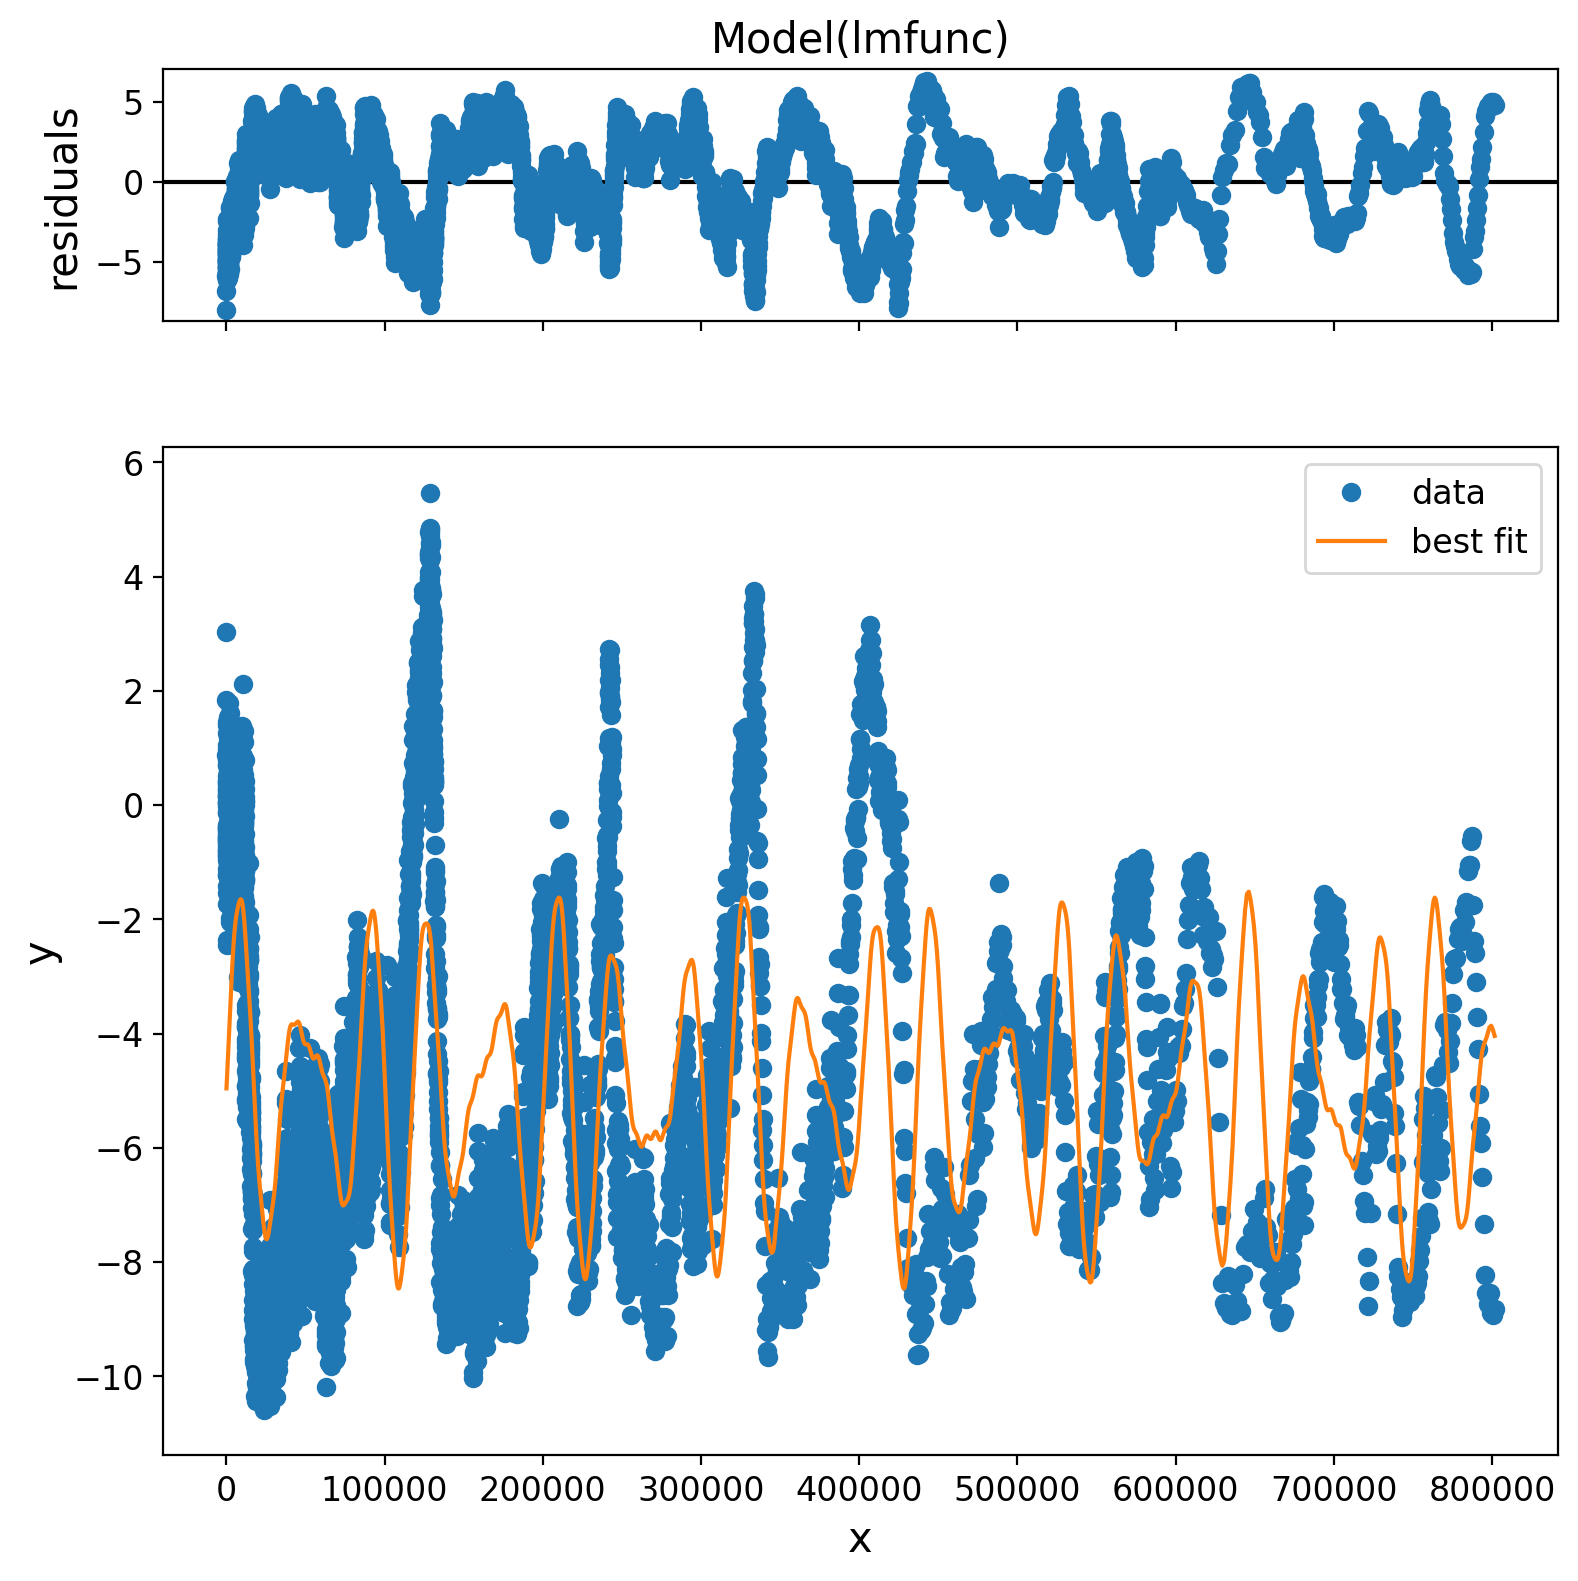

In [33]:
#>>>RUN: L22.3-runcell12

xinit = np.array([2.,1.6,1.76,2.16,-0.1,10.6,-5.])

def lmfunc(x,p0,p1,p2,p3,p4,p5,p6):
    #val=pX[0]*np.sin(pX[1]/10000.*t) +  pX[2]*np.sin(pX[3]/10000*t) +  pX[4]*np.sin(pX[5]/10000*t) + pX[6]
    return p0*np.sin(p1/10000.*x) +  p2*np.sin(p3/10000.*x) +  p4*np.sin(p5/10000.*x) + p6

model  = lmfit.Model(lmfunc)
print(data[:,1],data[:,0])
params = model.make_params(p0=xinit[0],p1=xinit[1],p2=xinit[2],p3=xinit[3],p4=xinit[4],p5=xinit[5],p6=xinit[6])
result = model.fit(data=data[:,1], params=params, x=data[:,0])
result.plot()
lmfit.report_fit(result)

<a name='exercises_23_3'></a>     

| [Top](#section_23_0) | [Restart Section](#section_23_3) |


### <span style="border:3px; border-style:solid; padding: 0.15em; border-color: #90409C; color: #90409C;">Exercise 22.3.1</span>

Run the fit with only 6 walkers, but still 2500 steps. What is the value of the likelihood that the code converges to? Think about how this compares to the convergence of the earlier code, where 100 walkers were used. Is this doing a good enough job?

Run several trials and report your answer for the typical maximum likelihood as a number (it will be negative) with precision `1e4`.


<br>

Steps: 500
Steps: 1000
Steps: 1500
Steps: 2000
Steps: 500
Steps: 1000
Steps: 1500
Steps: 2000


Maximum Liikelihood: (array([[[ 4.99996744e+00,  1.00011861e+00,  4.99976365e+00, ...,
         -5.00032980e+00,  9.99978886e+00, -5.00017806e+00],
        [ 4.99996744e+00,  1.00011861e+00,  4.99976365e+00, ...,
         -5.00032980e+00,  9.99978886e+00, -5.00017806e+00],
        [ 4.99996744e+00,  1.00011861e+00,  4.99976365e+00, ...,
         -5.00032980e+00,  9.99978886e+00, -5.00017806e+00],
        ...,
        [ 6.49038836e+00,  2.33345628e-03,  6.65443421e+00, ...,
         -2.62639739e+00,  1.10796140e+01, -5.31723081e+00],
        [ 6.49038836e+00,  2.33345628e-03,  6.65443421e+00, ...,
         -2.62639739e+00,  1.10796140e+01, -5.31723081e+00],
        [ 6.49038836e+00,  2.33345628e-03,  6.65443421e+00, ...,
         -2.62639739e+00,  1.10796140e+01, -5.31723081e+00]],

       [[ 4.99990587e+00,  1.00016670e+00,  4.99974832e+00, ...,
         -5.00009742e+00,  9.99986758e+00, -4.99996556e+00],
        [ 4.99975984e+00,  1.00031710e+00,  4.99955118e+00, ...,
         -5.0002

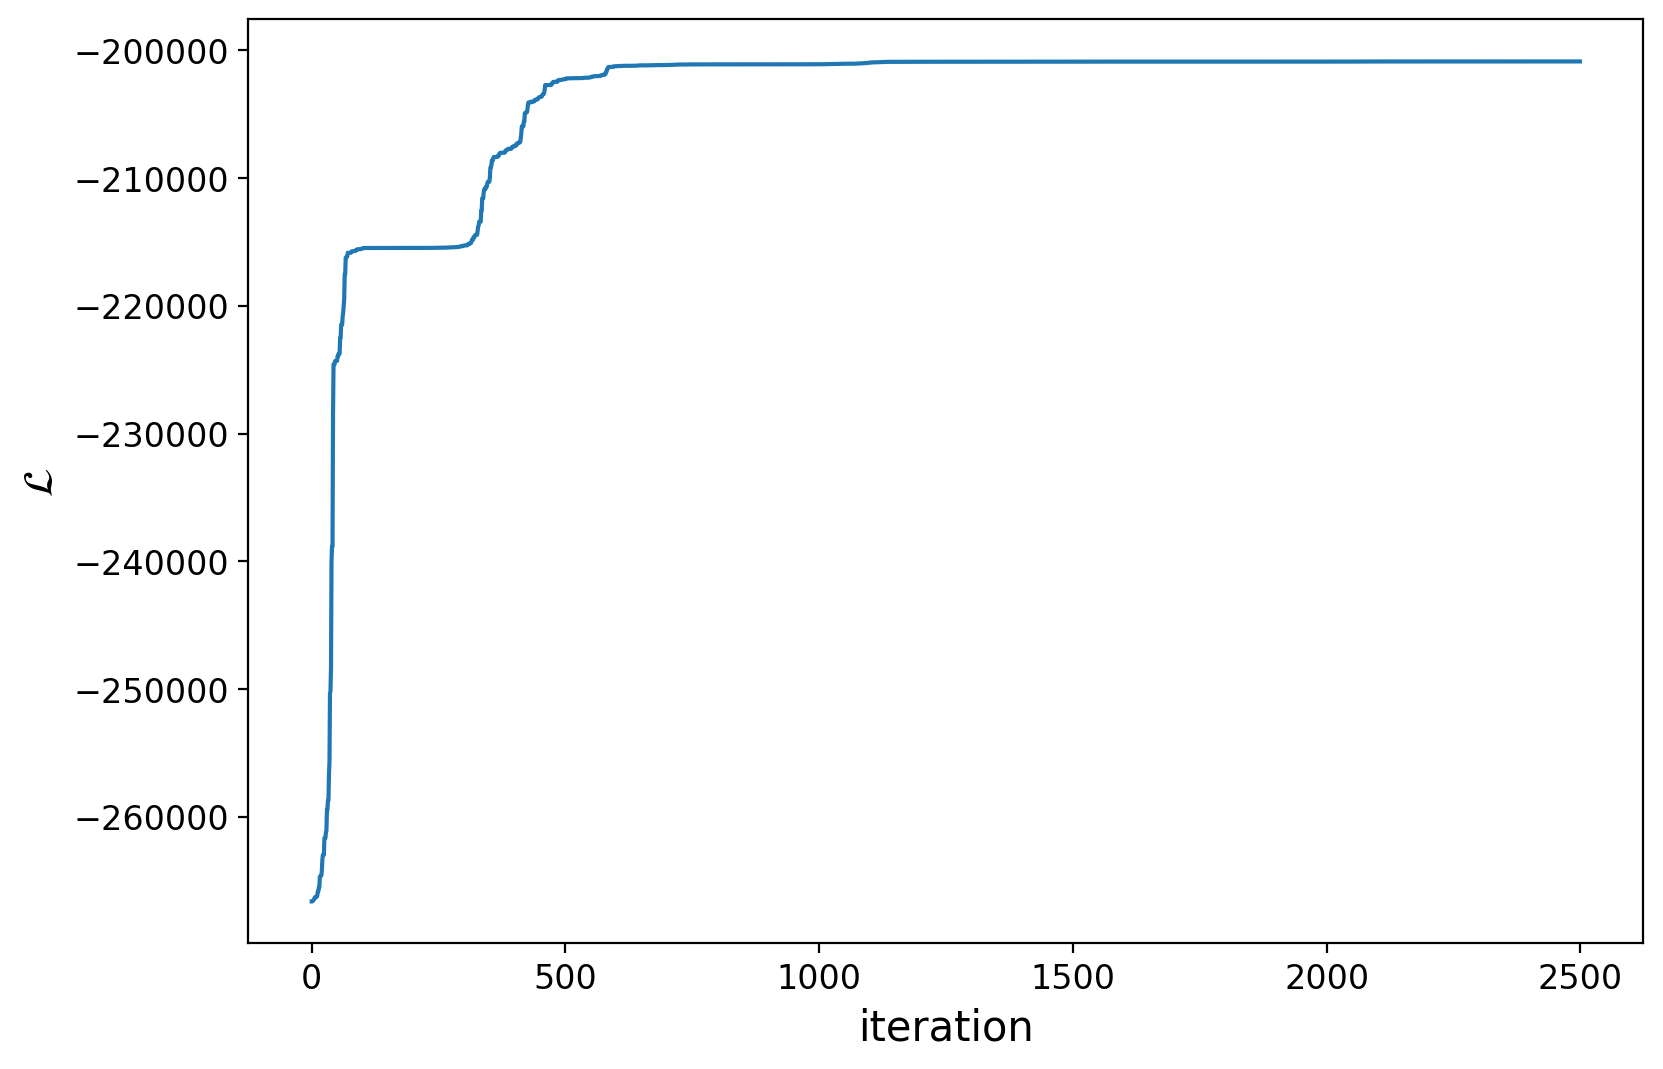

In [34]:
#>>>EXERCISE: L22.3.1

Nwalk = 6
Nstep = 2500
xinit = np.array([5.,1.,5.,2.,-5.,10.,-5.])
q0    = np.array([xinit + 1.0e-4*np.random.randn(Npars) for i in range(Nwalk)])
logp0 = log_like(q0, data, func)
accepted, likelihood = metropolis_hastings_ensemble(q0,logp0,data,Npars,Nwalk,Nstep,func)

lproj = np.max(likelihood,axis=0)
max_likelihood = metropolis_hastings_ensemble(q0, logp0, data,Npars, Nwalk, Nstep, func)

print("Maximum Liikelihood:", max_likelihood)
plt.plot(lproj)
plt.xlabel("iteration")
plt.ylabel("$\mathcal{L}$")
plt.show()

### <span style="border:3px; border-style:solid; padding: 0.15em; border-color: #90409C; color: #90409C;">Exercise 22.3.2</span>

Let's run MCMC on some data that has discontinuities, and see if we can get a good fit using a step-function. There are several steps to understanding and implementing this. In this problem we will describe the data and fit function, with the goal of defining a prior.

<h3>Step 1: Generate Data</h3>

Generate three sets of random data, that will ultimately create a tiered box shape. Run the following code to visualize this shape:

<pre>
np.random.seed(40)
vals=np.random.rand(1000)*10
vals=np.append(vals,np.random.rand(1000)*5 + 2.5)
vals=np.append(vals,np.random.rand(1000)*2+4.)
hist,bin_edges=np.histogram(vals,bins=np.arange(0,10.5,0.25))
bin_centers=0.5*(bin_edges[:-1]+bin_edges[1:])
plt.errorbar(bin_centers,hist,np.sqrt(hist),fmt='o', color='k')
plt.xlabel("x")
plt.ylabel("events")
plt.show()
</pre>

<h3>Step 2: Define a Fit Function</h3>

The function we will try to fit is given by:

<pre>
def func(x,t):
    out=[]
    for pX in x:
        val=pX[0]*np.heaviside(t-pX[4],1) + \
            pX[1]*np.heaviside(t-pX[5],1) + \
            pX[2]*np.heaviside(t-pX[6],1) + \
            pX[3]*np.heaviside(t-pX[7],1) + pX[8]
        out.append(val)
    out = np.array(out)
    return out
</pre>

Optionally, plot the fit function for some random parameter choices, to see what it looks like:

<pre>
# Define a single set of parameters
# Format: [height1, height2, height3, height4, position1, position2, position3, position4, offset]
params = np.array([
    [2, -1, 3, -2, 1, 3, 5, 7, 0]  # Example parameter set
])

# Define the t values
t_values = np.linspace(0, 10, 1000)  # t goes from 0 to 10 with 1000 points

# Calculate the output of the function for this single set of parameters
output = func(params, t_values)

# Plot the result
plt.figure(figsize=(10, 6))
plt.plot(t_values, output[0], label="Parameter Set")
plt.xlabel('t')
plt.ylabel('Function Value')
plt.title('Plot of func for a Single Parameter Set')
plt.legend()
plt.grid(True)
plt.show()
</pre>


<h3>Step 3: Define a Prior</h3>

The prior places constraints on the parameters of the model. It will have the following form:

<pre>
def prior(like,x):
    #Adjust the likelihood by the prior
    prior=np.zeros(x.shape[0])
    idx = np.where(###YOUR CODE HERE: ENTER CONSTRAINTS)
    like[idx]+=np.log(prior[idx])
    
    #ADD OTHER CONSTRAINTS
    idx = np.where(###YOUR CODE HERE: ENTER CONSTRAINTS)
    like[idx]+=np.log(prior[idx])
    return like
</pre>


**Here is where the question comes in.** Consider the constraints below. Select ALL options that are beneficial to add to the prior, based on the form of the data and model we are trying to fit. Note: some options may seem useful, but are not ideal because

A) The step positions should be strictly increasing (i.e., each step occurs at a farther position than the previous one):\
`idx = np.where((x[:,4] > x[:,5]) | (x[:,5] > x[:,6]) | (x[:,6] > x[:,7]))`

B) The step heights should be non-negative, meaning the model should not have any downward steps:\
`idx = np.where((x[:,0] < 0) | (x[:,1] < 0) | (x[:,2] < 0) | (x[:,3] < 0))`

C) The difference between consecutive step positions should be at least 1 to ensure that the steps are well-separated:\
`idx = np.where((x[:,5] - x[:,4] < 1.0) | (x[:,6] - x[:,5] < 1.0) | (x[:,7] - x[:,6] < 1.0))`

D) The step positions should be non-negative, meaning all steps should occur at positive positions:\
`idx = np.where((x[:,4] < 0) | (x[:,5] < 0) | (x[:,6] < 0) | (x[:,7] < 0))`

E) The sum of the step heights should be equal to a specific value (e.g., 10) to ensure the total height of the function is fixed:\
`idx = np.where(np.abs(x[:,0] + x[:,1] + x[:,2] + x[:,3] - 10) > 1e-6)`

F) The step heights should alternate in sign, ensuring that each step is followed by a drop, creating an oscillating pattern:
`idx = np.where((x[:,0] * x[:,1] > 0) | (x[:,1] * x[:,2] > 0) | (x[:,2] * x[:,3] > 0))`

G) The step positions should be within a specific range (e.g., between 1 and 5) to limit the function’s domain:\
`idx = np.where((x[:,4] < 1) | (x[:,4] > 5) | (x[:,5] < 1) | (x[:,5] > 5) | (x[:,6] < 1) | (x[:,6] > 5) | (x[:,7] < 1) | (x[:,7] > 5))`

H) The constant offset should be non-negative to ensure that the function does not drop below a certain baseline:\
`idx = np.where(x[:,8] < 0)`


<br>

### <span style="border:3px; border-style:solid; padding: 0.15em; border-color: #90409C; color: #90409C;">Exercise 22.3.3</span>

Now run MCMC to fit the step-function that we have defined, and compare with fitting performed by lmfit. You will need to define the `prior` in the code below, based on your answer to the previous question. Which does a better job? 

A) MCMC is better.\
B) lmfit is better.\
C) They both perform the same.

<br>

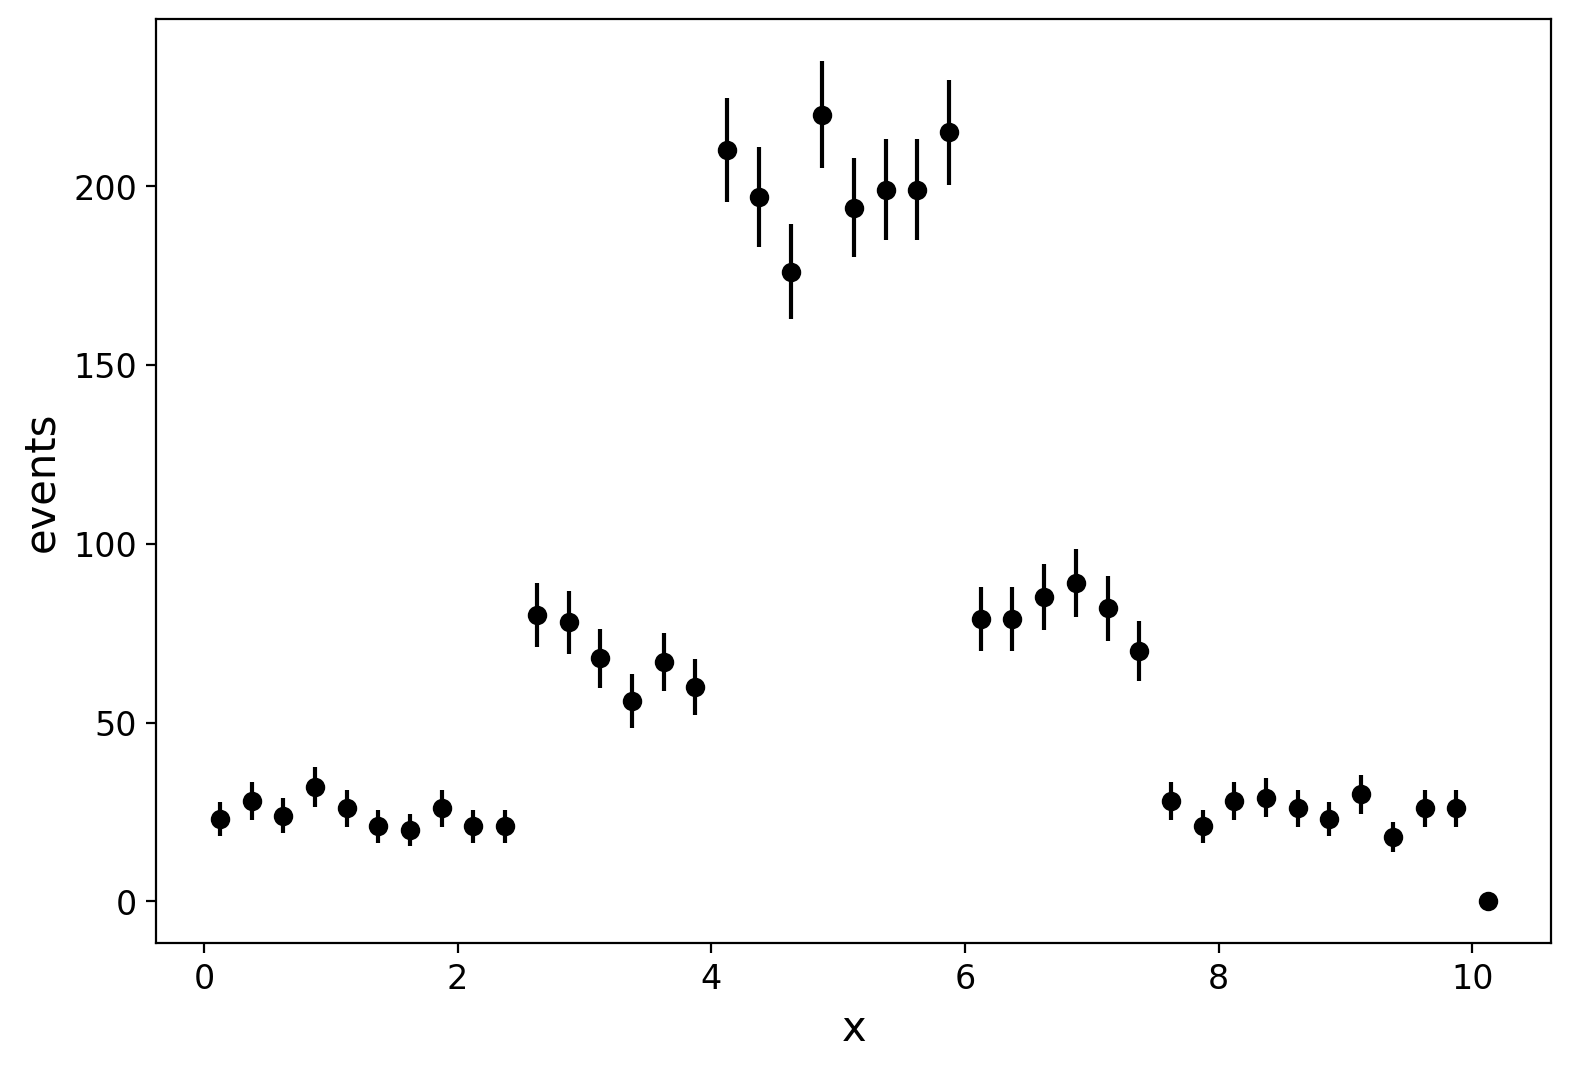

Steps: 500
Steps: 1000
Steps: 1500
Steps: 2000
Steps: 2500
Steps: 3000
Steps: 3500
Steps: 4000
Steps: 4500


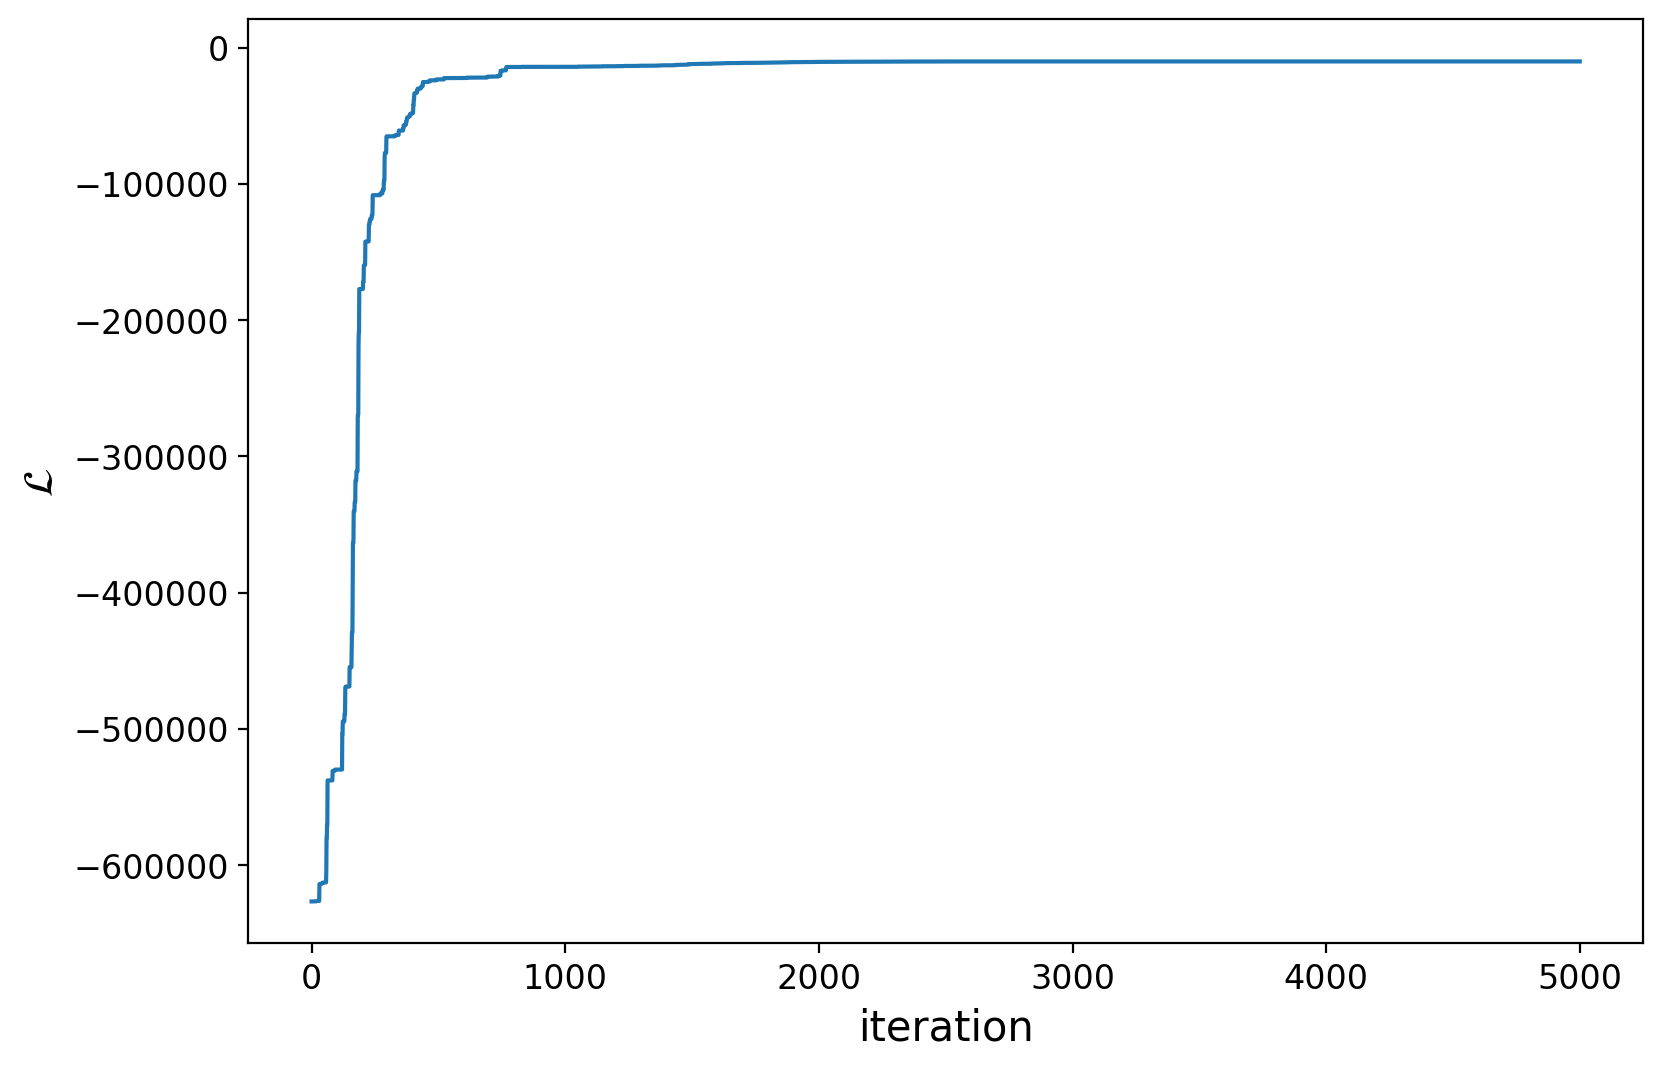

[[ 160.07276675    1.00642021 -121.09965559  -57.49086273    3.93374989
     4.96107672    6.03237084    7.44755458   40.6870083 ]]


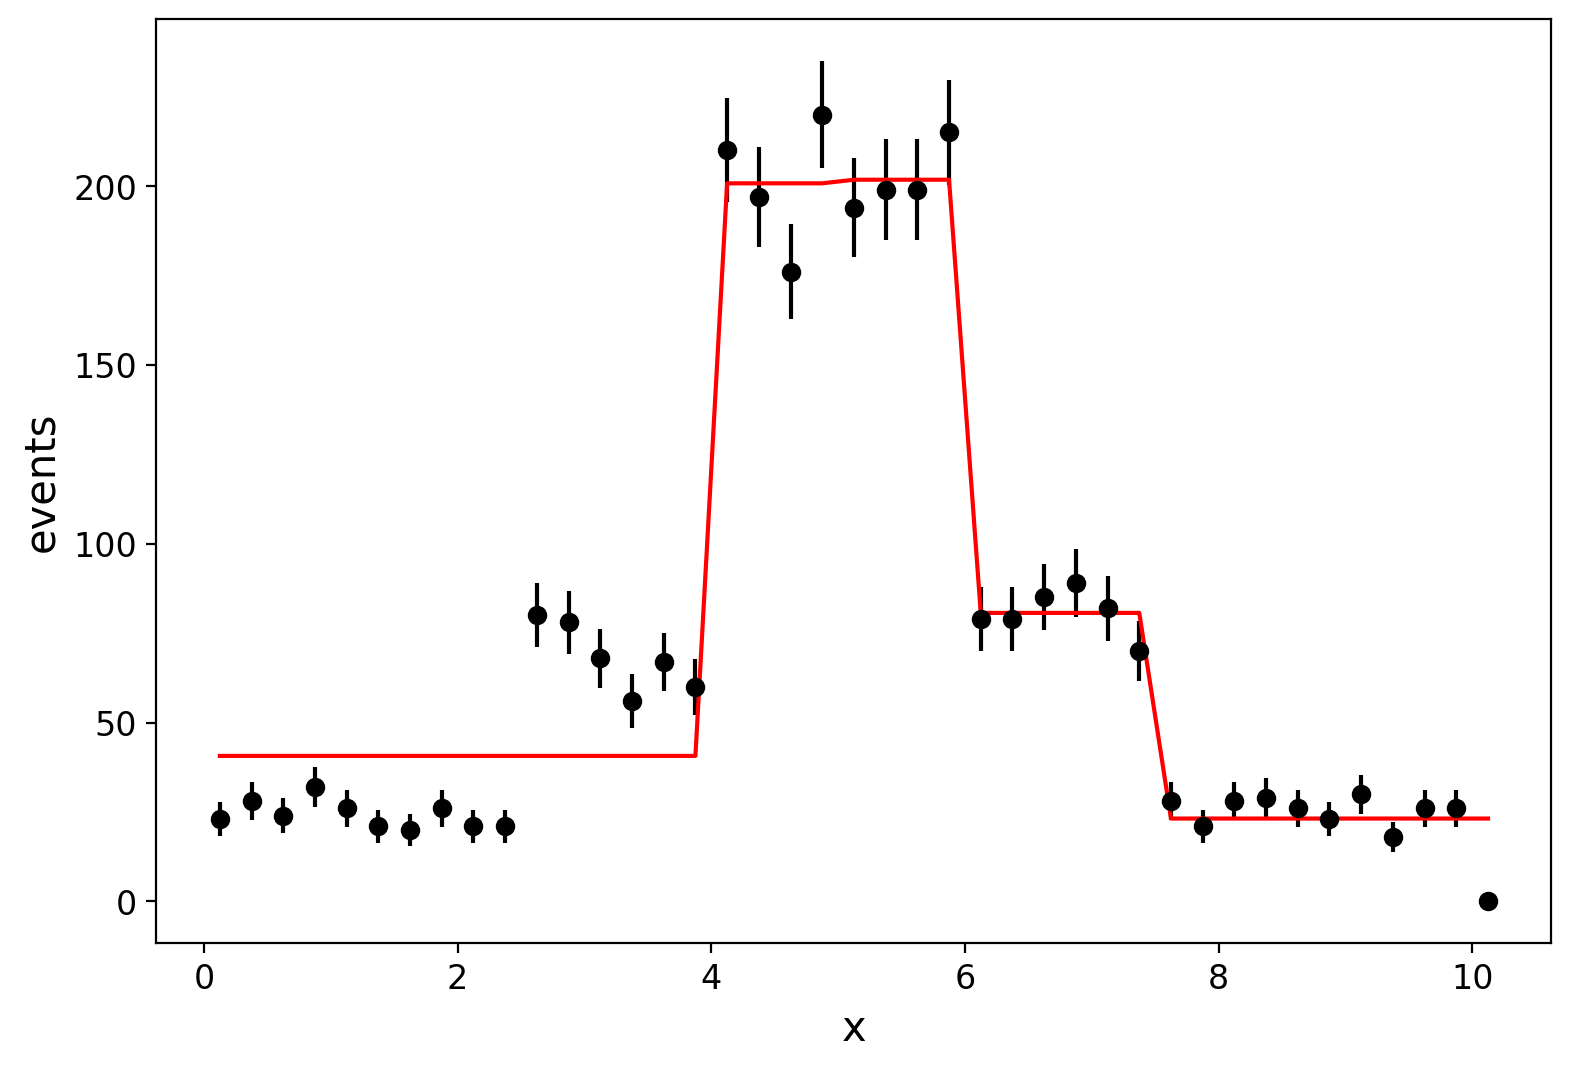

[ 23.  28.  24.  32.  26.  21.  20.  26.  21.  21.  80.  78.  68.  56.
  67.  60. 210. 197. 176. 220. 194. 199. 199. 215.  79.  79.  85.  89.
  82.  70.  28.  21.  28.  29.  26.  23.  30.  18.  26.  26.   0.] [ 0.125  0.375  0.625  0.875  1.125  1.375  1.625  1.875  2.125  2.375
  2.625  2.875  3.125  3.375  3.625  3.875  4.125  4.375  4.625  4.875
  5.125  5.375  5.625  5.875  6.125  6.375  6.625  6.875  7.125  7.375
  7.625  7.875  8.125  8.375  8.625  8.875  9.125  9.375  9.625  9.875
 10.125]
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 21
    # data points      = 41
    # variables        = 9
    chi-square         = 154065.210
    reduced chi-square = 4814.53781
    Akaike info crit   = 355.493926
    Bayesian info crit = 370.916074
    R-squared          = 0.17186964
##  Warning: uncertainties could not be estimated:
    p4:  at initial value
    p5:  at initial value
    p6:  at initial value
    p7:  at initial value
[[Variables]]
    p0: -3.500

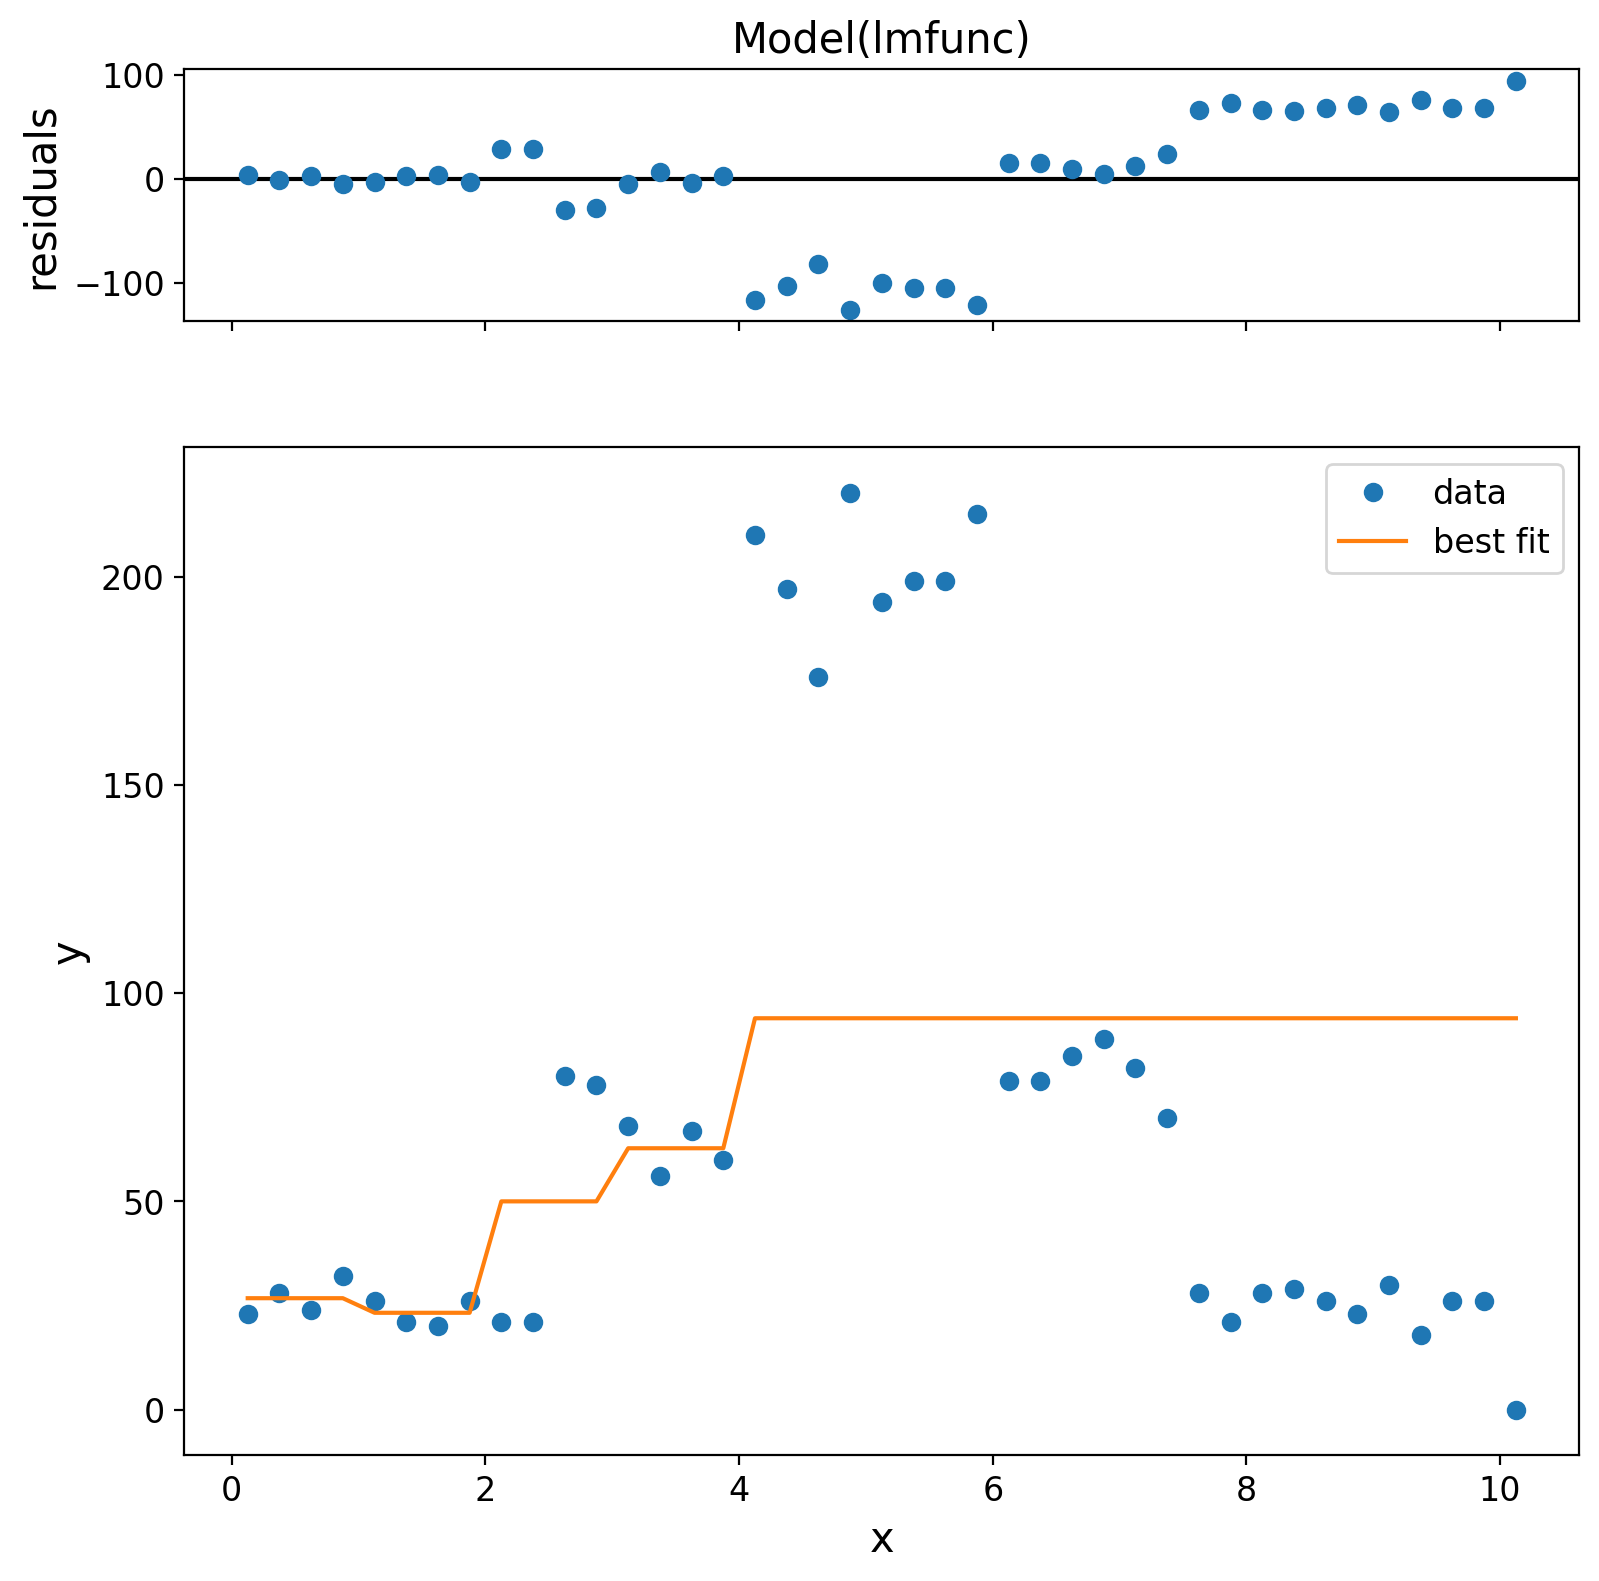

In [35]:
#>>>EXERCISE: L22.3.3

#Generate the data -> just run this code if 
#you want to see what it looks like first
#-----------------------------------------------
np.random.seed(40)
vals=np.random.rand(1000)*10
vals=np.append(vals,np.random.rand(1000)*5 + 2.5)
vals=np.append(vals,np.random.rand(1000)*2+4.)
hist,bin_edges=np.histogram(vals,bins=np.arange(0,10.5,0.25))
bin_centers=0.5*(bin_edges[:-1]+bin_edges[1:])
plt.errorbar(bin_centers,hist,np.sqrt(hist),fmt='o', color='k')
plt.xlabel("x")
plt.ylabel("events")
plt.show()


#define the step-function used for fitting
#-----------------------------------------------
def func(x,t):
    out=[]
    for pX in x:
        val=pX[0]*np.heaviside(t-pX[4],1) + \
            pX[1]*np.heaviside(t-pX[5],1) + \
            pX[2]*np.heaviside(t-pX[6],1) + \
            pX[3]*np.heaviside(t-pX[7],1) + pX[8]
        out.append(val)
    out = np.array(out)
    return out

def log_like(x,data,iFunc):
    return -1.*np.sum((iFunc(x,data[:,0])-data[:,1])**2,axis=1)


#define the prior
#-----------------------------------------------
def prior(like,x):
    #Adjust the likelihood by the prior
    prior=np.zeros(x.shape[0])
    idx = np.where((x[:,5] - x[:,4] < 1) | (x[:,6] - x[:,5] < 1) | (x[:,7] - x[:,6] < 1))
    like[idx]+=np.log(prior[idx])
    
    #ADD OTHER CONSTRAINTS
    idx = np.where((x[:,4] < 0) | (x[:,5] < 0) | (x[:,6] < 0) | (x[:,7] < 0) )
    like[idx]+=np.log(prior[idx])
    return like


#redefine some functions that we have used already
#-----------------------------------------------
def mc_update(walkers, otherwalkers, logp0, Npars, idata, ifunc, a=2.0,iPrint=False):
    Nw = len(walkers)
    No = len(otherwalkers)

    # Calculates random gradient for the affine linear transformation
    Z = (((a - 1.0) * np.random.rand(Nw) + 1.0) ** 2.0) / a
    rint = np.random.randint(No, size=(Nw,))
    qt1 = otherwalkers[rint] - Z[:, np.newaxis] * (otherwalkers[rint] - walkers)
    # Calculate the posterior probability of the new position
    logp1 = log_like(qt1, idata,ifunc)
    logp1 = prior(logp1,qt1)

    #Now do the usual Markov update
    #p_diff = (Npars - 1) * np.log(Z) + logp - logp0
    p_diff = logp1 - logp0

    rshape=np.random.rand(p_diff.shape[0])
    accept = p_diff > np.log(np.random.rand(p_diff.shape[0]))
    return qt1, logp1, accept


def log_like(x,data,iFunc):
    return -1.*np.sum((iFunc(x,data[:,0])-data[:,1])**2,axis=1)


#run MCMC
#-----------------------------------------------
Npars = 9
Nwalk = 100
Nstep = 5000
xinit = np.array([100,100,-100,-100,1,2,3,4,100])
q0    = np.array([xinit + 1.0e-4*np.random.randn(Npars) for i in range(Nwalk)])
data = np.vstack((bin_centers,hist))
data = data.T
logp0 = log_like(q0, data, func)
accepted, likelihood = metropolis_hastings_ensemble(q0,logp0,data,Npars,Nwalk,Nstep,func)

lproj = np.max(likelihood,axis=0)
plt.plot(lproj)
plt.xlabel("iteration")
plt.ylabel("$\mathcal{L}$")
plt.show()

maxval=np.argmax(lproj)
maxy=np.argmax(likelihood[:,maxval])
bestpars=np.array([accepted[maxy,maxval]])
print(bestpars)
output=func(bestpars,bin_centers)

plt.errorbar(bin_centers,hist,np.sqrt(hist),fmt='o', color='k')
plt.plot(bin_centers,output.flatten(),color='red')
plt.xlabel("x")
plt.ylabel("events")
plt.show()


#fit with lmfit
#-----------------------------------------------
def lmfunc(x,p0,p1,p2,p3,p4,p5,p6,p7,p8):
    return p0*np.heaviside(x-p4,1) + p1*np.heaviside(x-p5,1) + p2*np.heaviside(x-p6,1) + p3*np.heaviside(x-p7,1)+p8

model  = lmfit.Model(lmfunc)
print(data[:,1],data[:,0])
params = model.make_params(p0=xinit[0],p1=xinit[1],p2=xinit[2],p3=xinit[3],p4=xinit[4],p5=xinit[5],p6=xinit[6],p7=xinit[7],p8=xinit[8])
result = model.fit(data=data[:,1], params=params, x=data[:,0])
result.plot()
lmfit.report_fit(result)